**NGC0628 CO Intensity estimation and filament mass density calculations**
**Need to Verify constant, equations, and units. Also, this considers whole galaxy when maybe it shouldnt. Error propogation can also be tracked more carefully**

Papers:
1) https://arxiv.org/pdf/2410.05397   (I_CO_2_1)
2) https://arxiv.org/pdf/1301.3498    (I-CO_2_1 to Mass)

In [512]:
#imports
import numpy as np
import os
from astropy.io import fits
import matplotlib.pyplot as plt
from astropy.stats import sigma_clipped_stats
from photutils.detection import DAOStarFinder
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils.aperture import CircularAperture
import AnalysisFuncs as AF
import matplotlib.pyplot as plt
import cv2


In [513]:
#Open F700W and F300W or F200W
#Need access to F200W image
original_image_path = r"/Users/jakehoffmann/Documents/JHU_Research/FilPHANGS_Main/FilPHANGS_Data/OriginalImages/ngc0628_F770W_JWST_Emission_starsub.fits"
with fits.open(original_image_path) as hdul:
    I_F770W = hdul[0].data
    header = hdul[0].header
    I_F770W = np.nan_to_num(I_F770W)
    I_F770W = np.clip(I_F770W, 0, None)  # Set negative values to zero

In [514]:
#Ngc0628 Parameters
inclination = 9 * np.pi / 180  # Inclination in radians
sSFR = 1.74 #get specific SFR*

In [515]:
#1) Subtract .22*F300W or .13*F200W from F700W
#Skip for now - done with starlight subtraction

In [516]:
#2) Multiply by cos(inclination)
I_F770W = I_F770W * np.cos(np.radians(inclination))

In [517]:
#3) Estimate log(C_F770W) and correct original image to account for this
log_C_F770W = -.21 * (np.log10(sSFR) + 10.14) #account for deviations from expeted relation due to SFR 
#-.21 or -.316!?
x = np.log(I_F770W) - log_C_F770W

/var/folders/5p/156pd2n9725b58sg8kk5wwv40000gn/T/ipykernel_14696/3407081400.py:4: RuntimeWarning: divide by zero encountered in log
  x = np.log(I_F770W) - log_C_F770W


In [518]:
#4)define y, x, and calulate log_I_CO_2_1
log_I_CO_2_1 = (.88)*(x - 1.44) + (1.36) #Use the derived fit after correction
I_CO_2_1 = 10**log_I_CO_2_1

In [519]:
#Define parameters for Molecular Mass
X_CO = 2*10**20 #CO to H2 conversion factor for milky Way #(from Bolatto et al. 2013). Should work for galaxies similar in character to the milky way- massive spiral galaxies with 
#large metallicities (elements heavier than hydrogen). This is due to similar amounts of evolution in star formation and other factors. 

#Positionally dependent X_CO? 

z = 657 #km/s redshift (Wikepedia)
DL = 9.84 #Distance to NGC 628 in Mpc
pc_pix = 5.24

In [520]:
#6) Calculate molecular mass
#Molecular Mass in Msol
# flux = np.sum(I_CO_2_1) #Sum of I_CO_2_1
# Molecular_Mass = 1.05*10**4 * ( X_CO/(2*10**20))*(flux*DL**2)/(1+z)

Molecular_Mass = 5.5 * I_CO_2_1 #Units of Solar mass per pc^2
Molecular_mass  = Molecular_Mass/(pc_pix**2) #divide by pixel area in pc^2
Total_Mass = np.sum(Molecular_Mass) #Sum of I_CO_2_1
print(f"Molecular Mass estimation: {Total_Mass:.2E} Msol")
print(f"Published Molecular mass: 2.0E+10 Msol")

Molecular Mass estimation: 1.50E+10 Msol
Published Molecular mass: 2.0E+10 Msol


**Application to 16pc Synthetic Map**

In [521]:
#Estimate filament Density from 16pc Synthetic Map
original_image_path = r"/Users/jakehoffmann/Documents/JHU_Research/FilPHANGS_Main/ngc0628_F770W_CDDss0016pc_ModelMap_SorcesRemoved.fits"
with fits.open(original_image_path) as hdul:
    I_F770W_16pc = hdul[0].data
    header = hdul[0].header
    I_F770W_16pc= np.nan_to_num(I_F770W_16pc)
    I_F770W_16pc = np.clip(I_F770W_16pc, 0, None)  # Set negative values to zero


In [522]:
#Skip Step 1
#2) Multiply by cos(inclination)
I_F770W_16pc = I_F770W_16pc * np.cos(np.radians(inclination))
#3) Estimate log(C_F770W)
log_C_F770W = -.21 * (np.log10(sSFR) + 10.14)  #This formula has a +/- in the paper...why?
#4)define y, x, and calulate log_I_CO_2_1
x = np.log(I_F770W_16pc) - log_C_F770W
log_I_CO_2_1_16pc = (.88)*(x - 1.44) + (1.36) #More +/- in equation...why?
#5) Get I_CO__2_1
I_CO__2_1_16pc = 10**log_I_CO_2_1_16pc
I_CO__2_1_16pc[I_F770W_16pc == 0] =0

/var/folders/5p/156pd2n9725b58sg8kk5wwv40000gn/T/ipykernel_14696/3286924247.py:7: RuntimeWarning: divide by zero encountered in log
  x = np.log(I_F770W_16pc) - log_C_F770W


In [523]:
#6) Calculate molecular mass and Get Density Statistics
Molecular_Mass = 5.5 * I_CO__2_1_16pc #Units of Solar mass per pix^2


Total_Mass = np.sum(Molecular_Mass) 
filament_area = pc_pix**2*np.count_nonzero(Molecular_Mass) #filament area pc^2
print(f"Average image density: {Total_Mass/filament_area} Msol/pc^2")
print(f"Total_Mass {Total_Mass:E}")
print(f"filament_area {filament_area:E}")

Average image density: 8.729857642622541 Msol/pc^2
Total_Mass 3.543969E+08
filament_area 4.059595E+07


In [524]:
import photutils 
#get centers of filaments 

# set the FWHM of the filament
fwhmval=3 #16pc scale at 5.24 parcecs per pixel --> 3 pixels 

import numpy as np
import matplotlib.pyplot as plt
from photutils.datasets import make_noise_image
from photutils.psf import CircularGaussianPRF, make_psf_model_image
from astropy.convolution import Gaussian2DKernel
from astropy.convolution import convolve
from astropy.io import fits
from skimage.morphology import skeletonize
import cv2

#Composite skeleton from SOAX. Gives coordinates of sources in model
original_image_path = "/Users/jakehoffmann/Documents/JHU_Research/FilPHANGS_Main/ngc0628_F770W/Composites/ngc0628_F770W_JWST_Emission_starsub_CDDss0016pc_Composites.fits"
with fits.open(original_image_path) as hdul:
    coords_data = hdul[0].data
    header_1 = hdul[0].header


#Dilate the composite map from soax and then skeletonize to get smooth, 1 pixel wide, filaments for the PSF model
kernel_size = 3
kernel = np.ones((kernel_size, kernel_size), np.uint8)
dilated_image = cv2.morphologyEx(coords_data, cv2.MORPH_CLOSE, kernel)
fil_centers = skeletonize(dilated_image)
assert(np.max(fil_centers) == 1)



In [525]:
#remove junctions
from skimage.morphology import skeletonize
import AnalysisFuncs as AF


#work with filament centers
skel_copy = np.copy(fil_centers)
min_area_pix = 75 #minimum area of a filament in pixels
junctions = AF.getSkeletonIntersection(np.array(255*skel_copy))
IntersectsRemoved = AF.removeJunctions(junctions, fil_centers, dot_size = 3) #check intersects removed
print(np.max(IntersectsRemoved))
assert(np.max(IntersectsRemoved) == 1)


fil_centers = IntersectsRemoved
IntersectsRemoved = IntersectsRemoved.astype(np.uint8)
labels, stats, num_labels = AF.identify_connected_components(np.array(IntersectsRemoved))
small_areas = AF.sort_label_id(num_labels, stats, min_area_pix)

for label_id in small_areas:

    # Extract the bounding box coordinates
    left = stats[label_id, cv2.CC_STAT_LEFT]
    top = stats[label_id, cv2.CC_STAT_TOP]
    width = stats[label_id, cv2.CC_STAT_WIDTH]
    height = stats[label_id, cv2.CC_STAT_HEIGHT]

    fil_centers[top:top+height, left:left+width] = 0
assert(np.max(fil_centers) == 1)


True


<>:106: SyntaxWarning: invalid escape sequence '\o'
<>:106: SyntaxWarning: invalid escape sequence '\o'
/var/folders/5p/156pd2n9725b58sg8kk5wwv40000gn/T/ipykernel_14696/949046635.py:106: SyntaxWarning: invalid escape sequence '\o'
  plt.xlabel("Surface Density (M$_\odot$/pc²)")


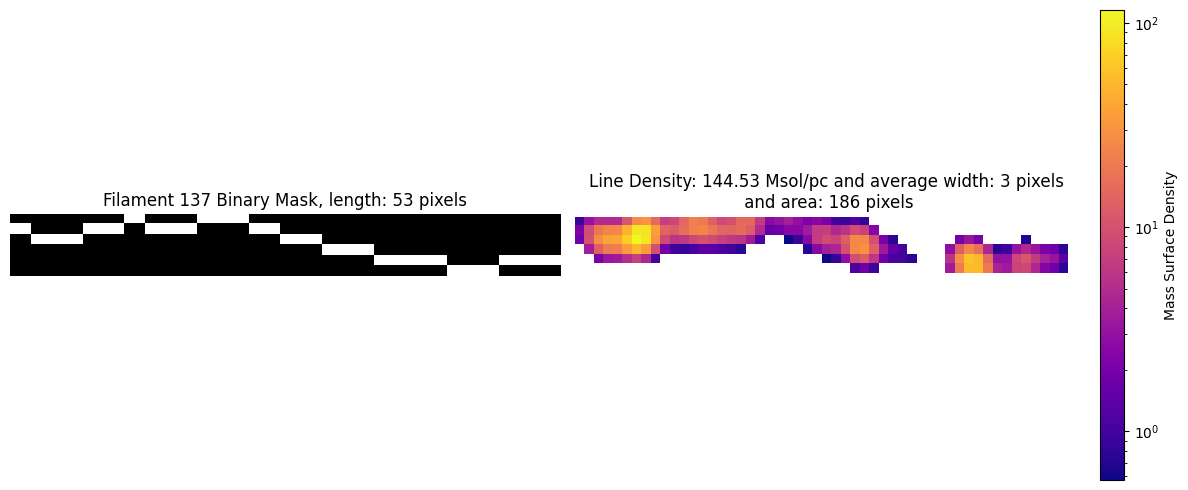

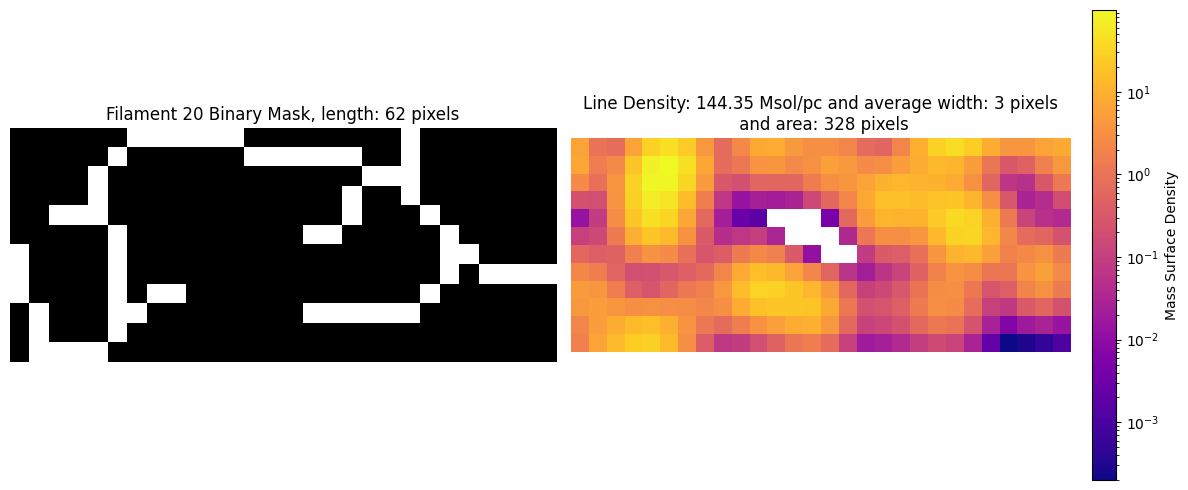

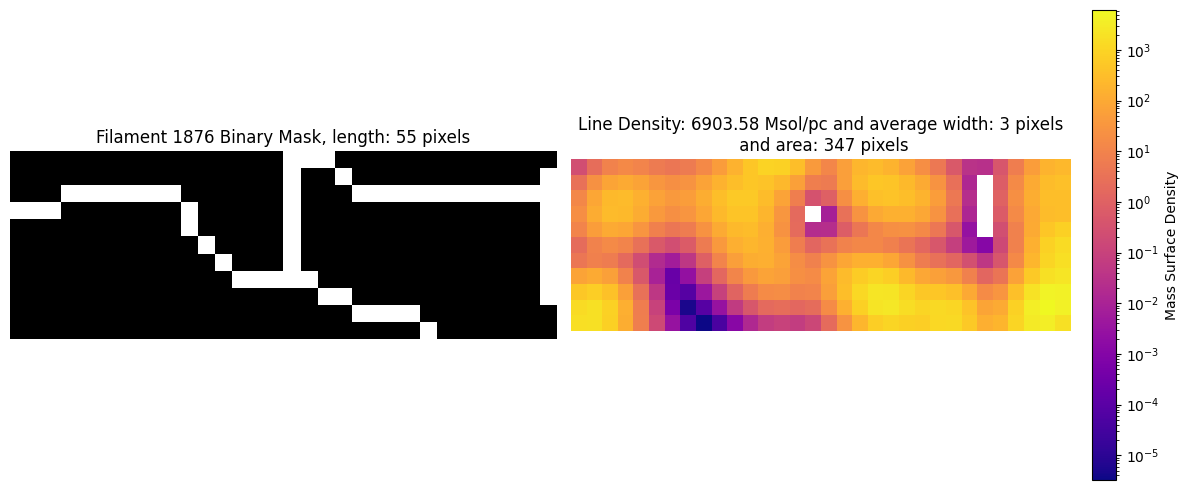

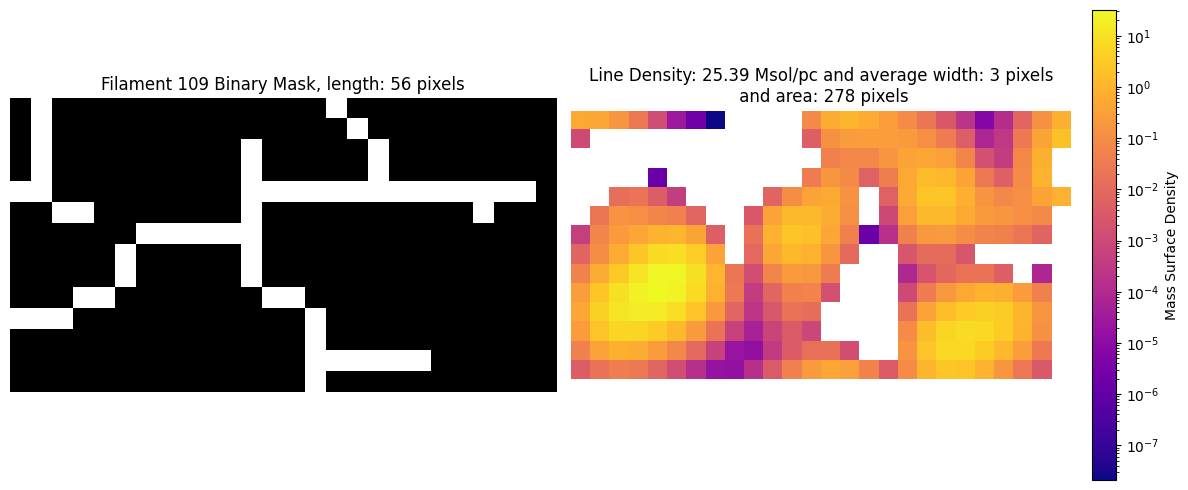

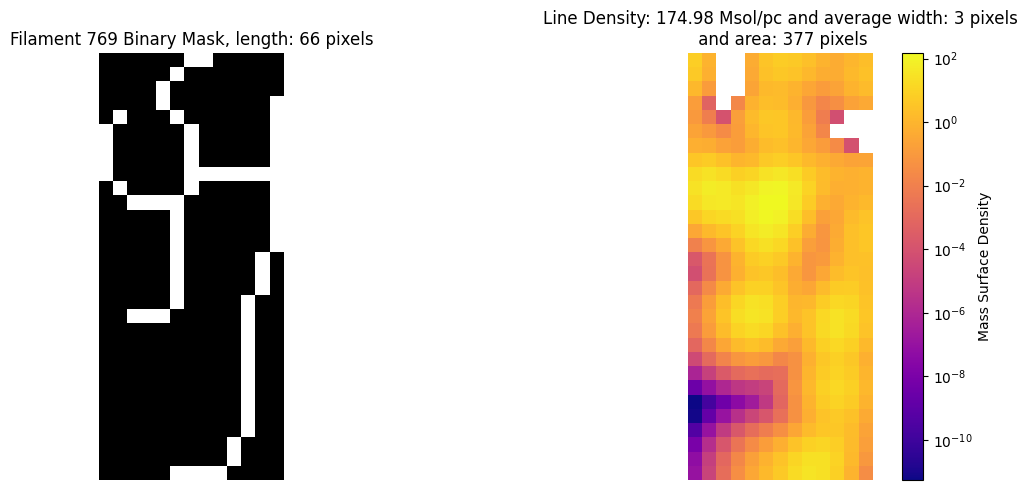

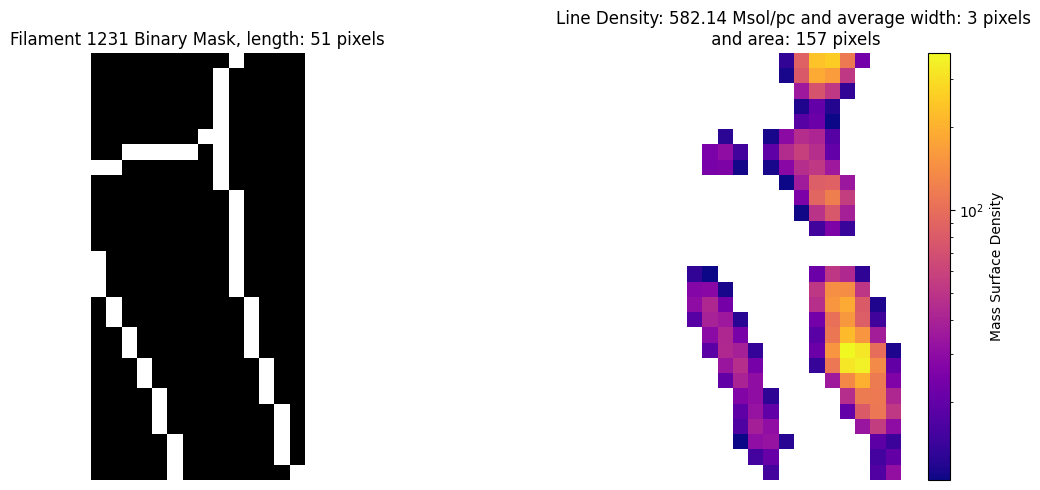

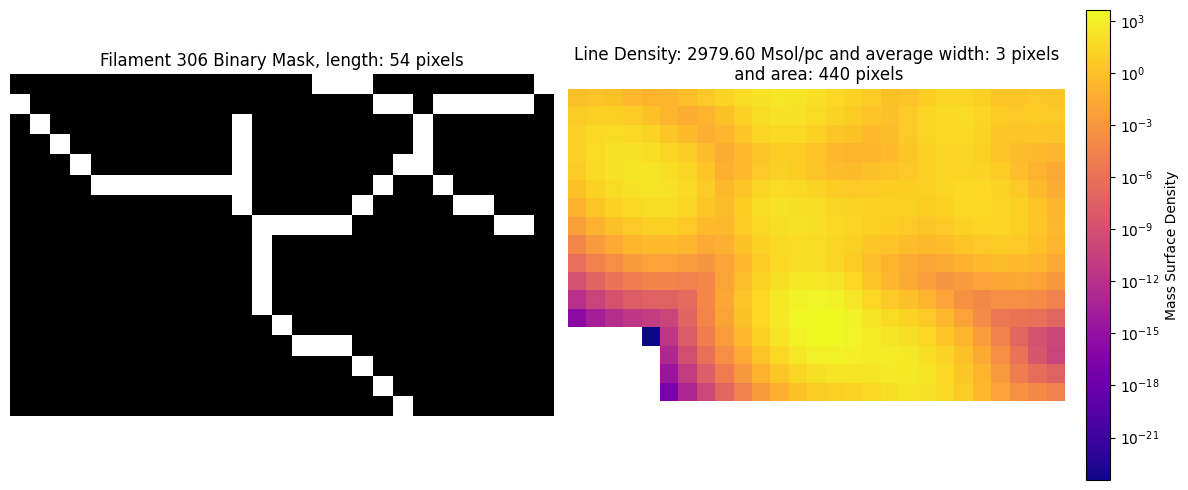

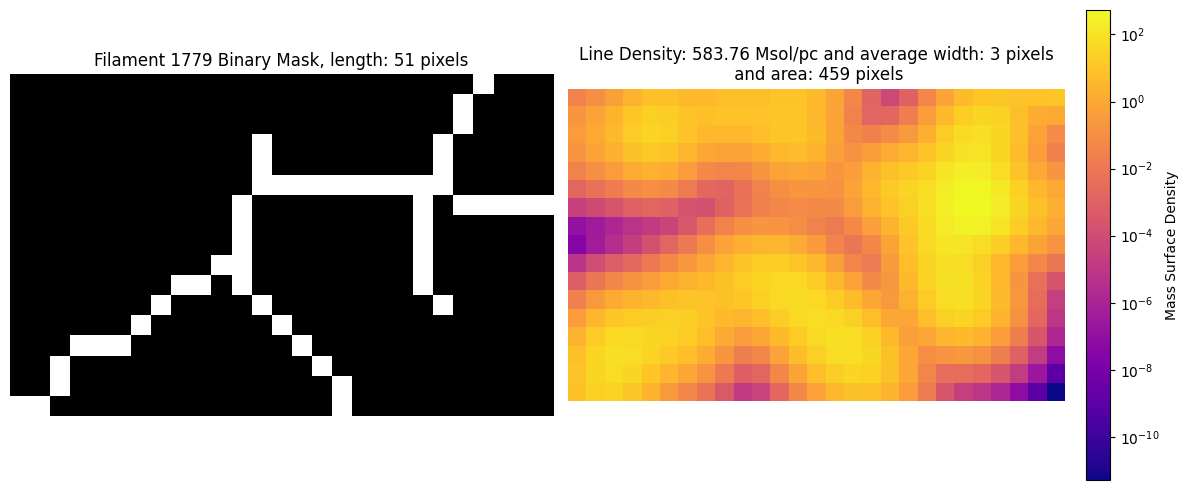

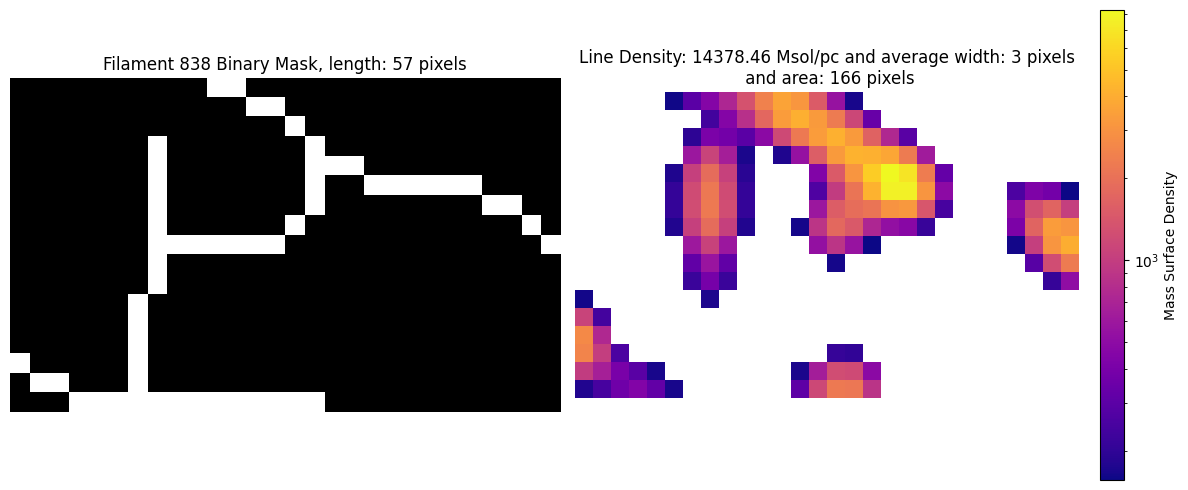

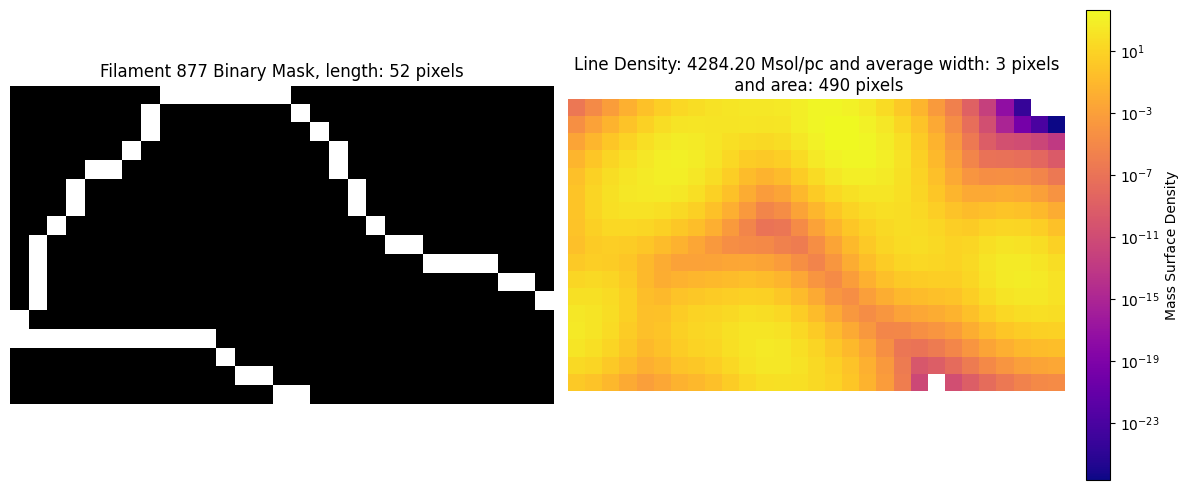

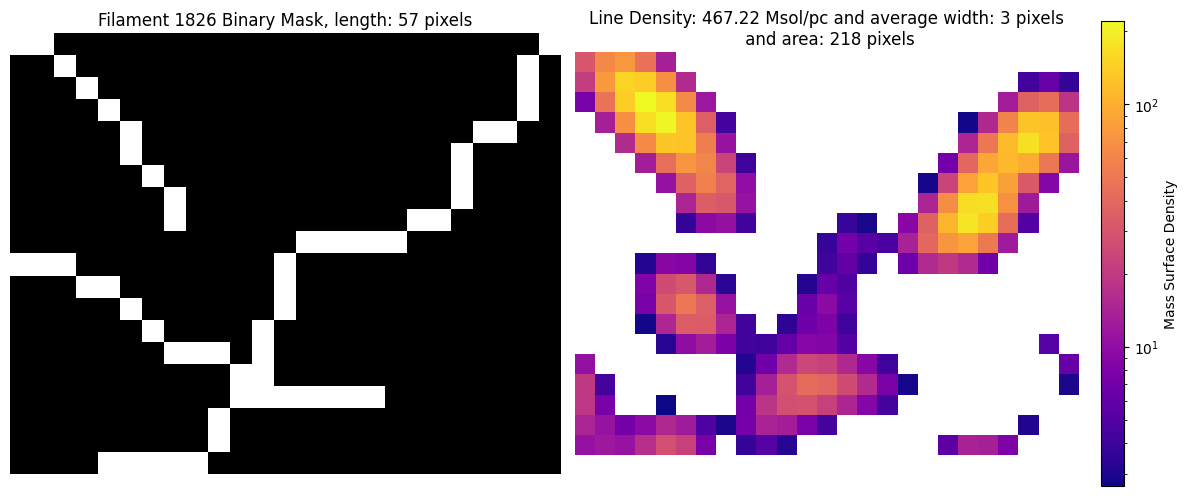

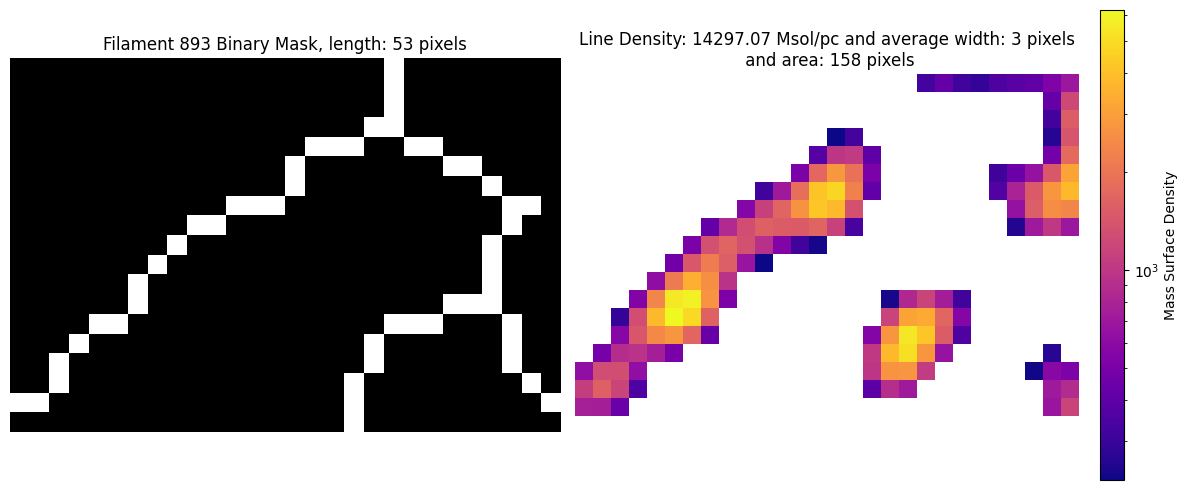

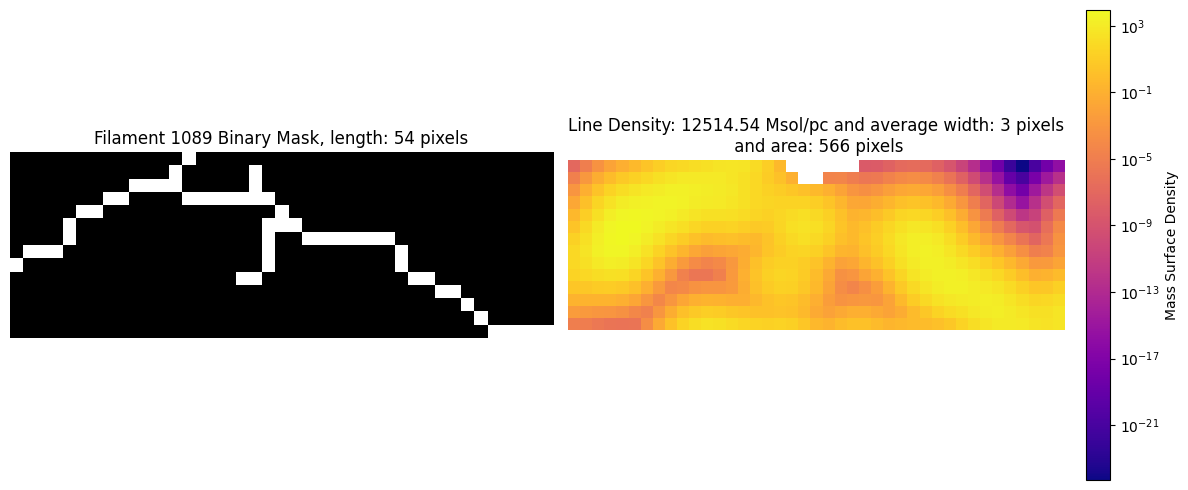

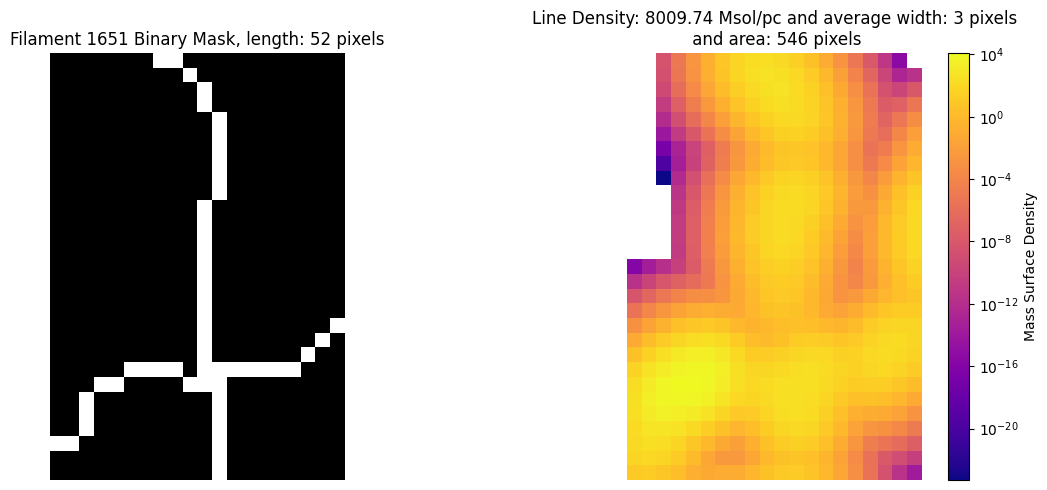

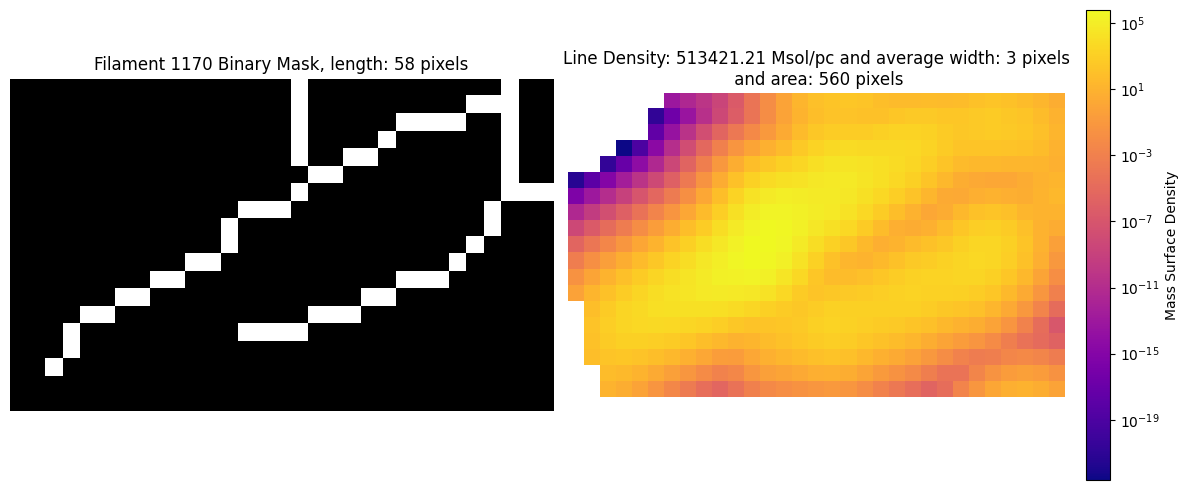

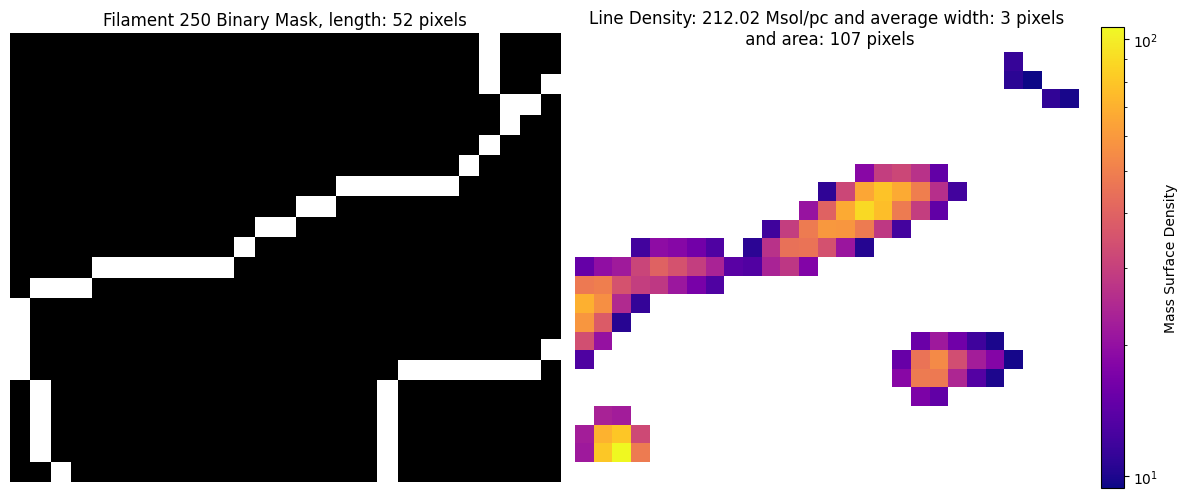

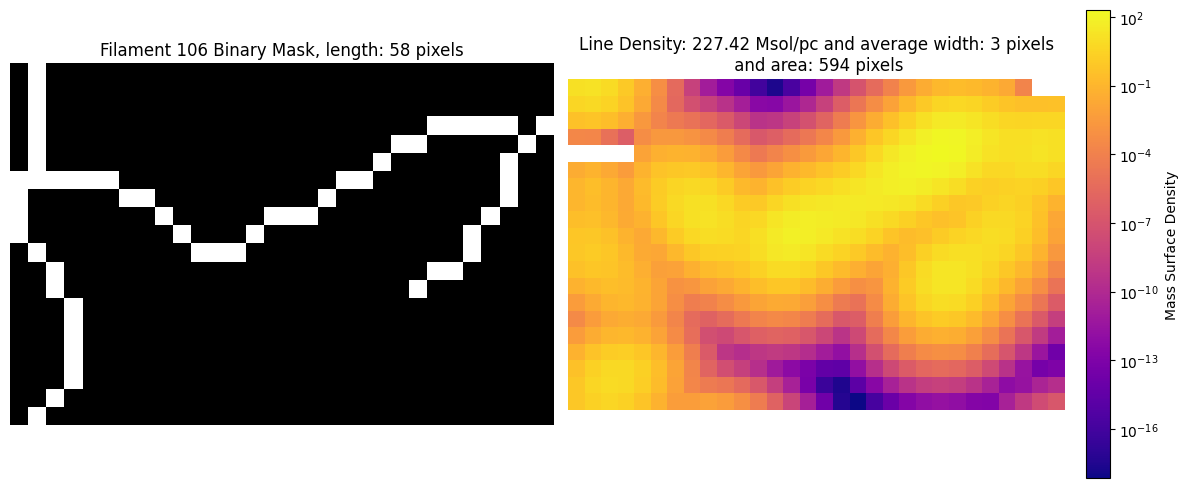

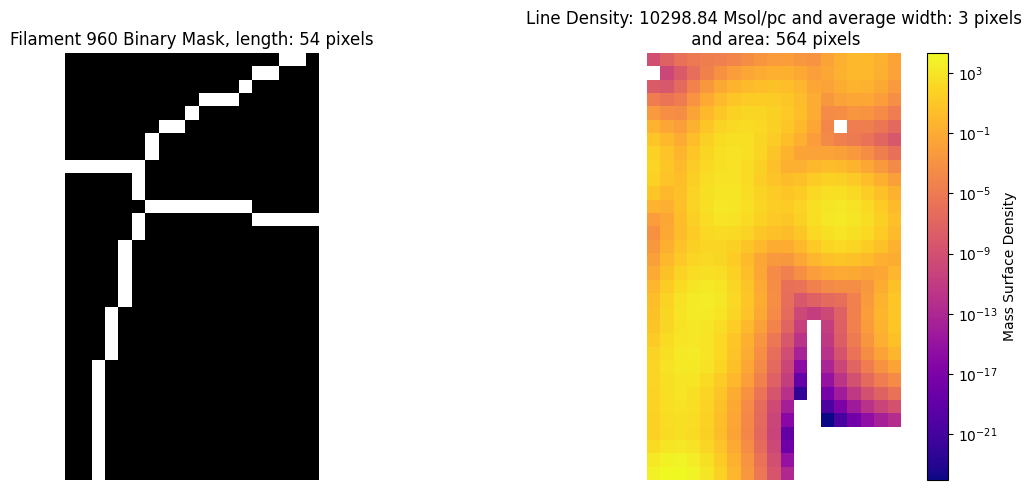

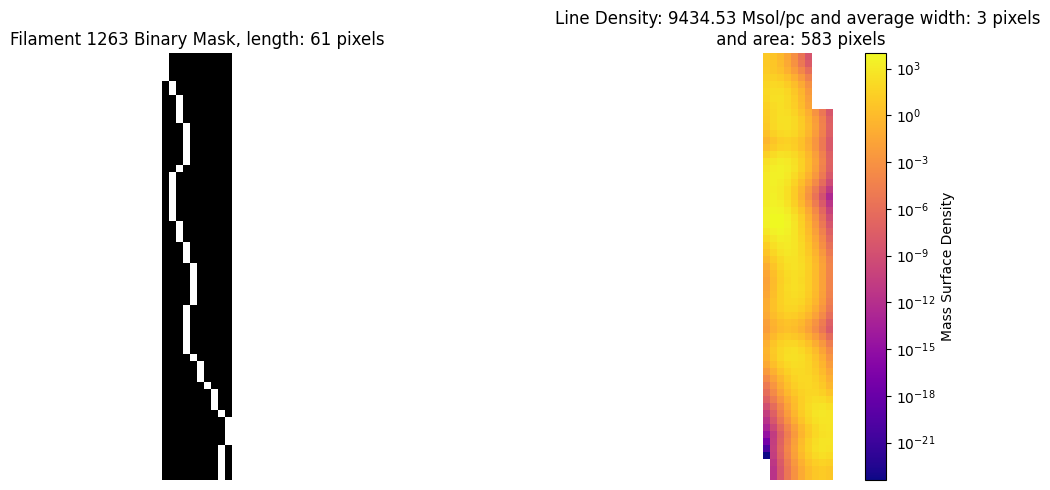

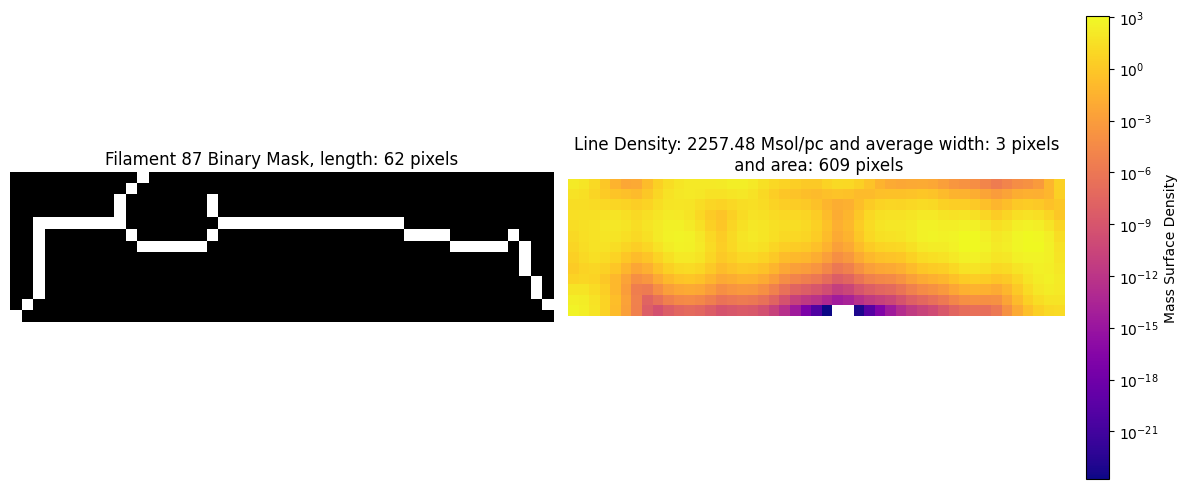

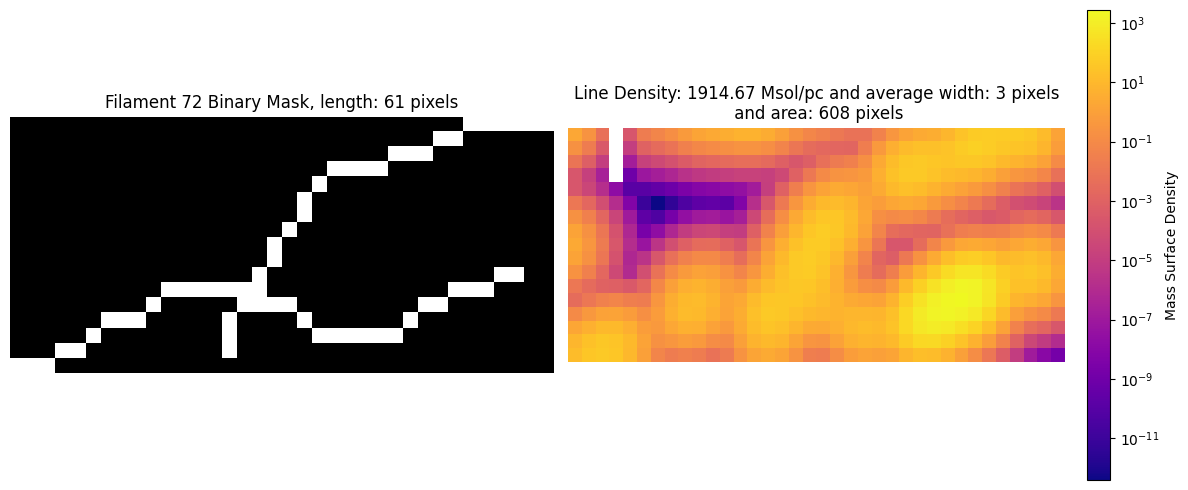

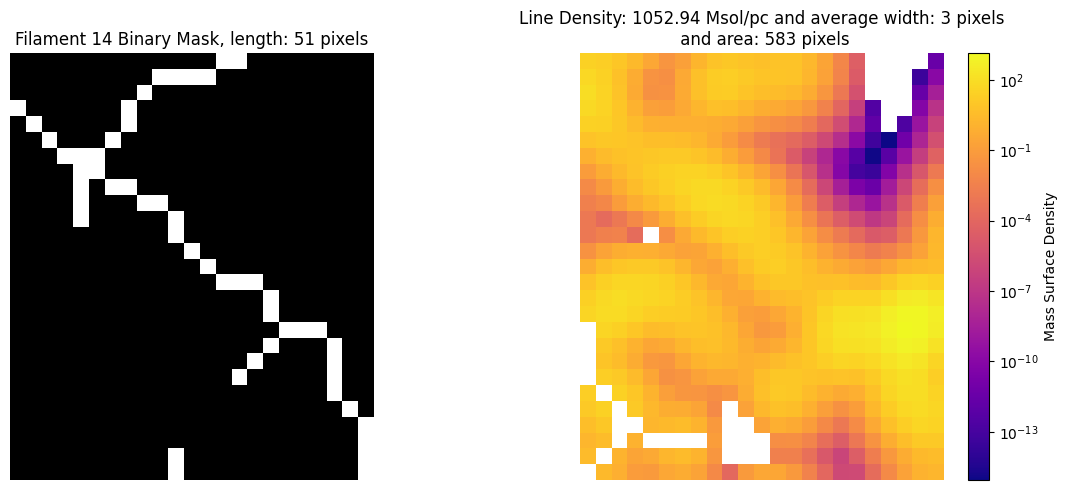

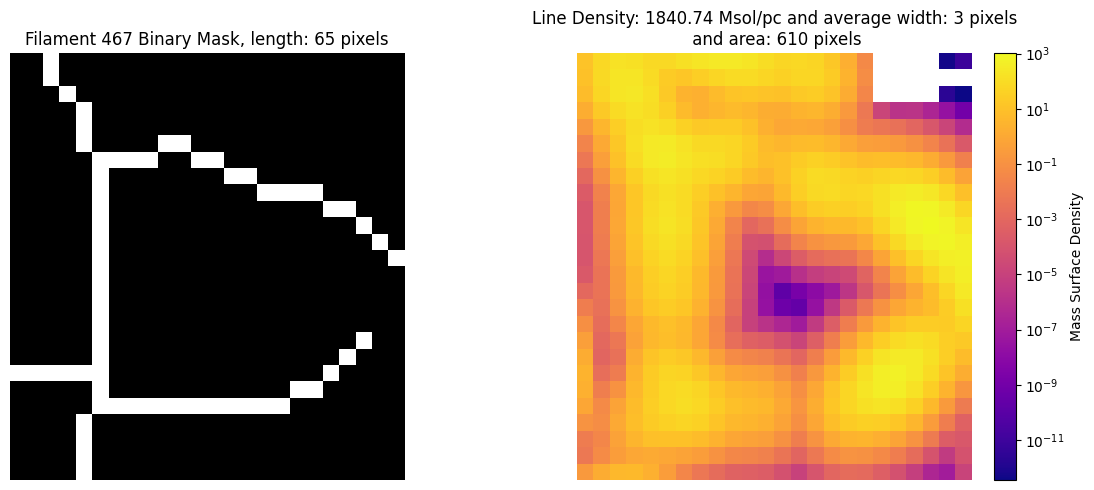

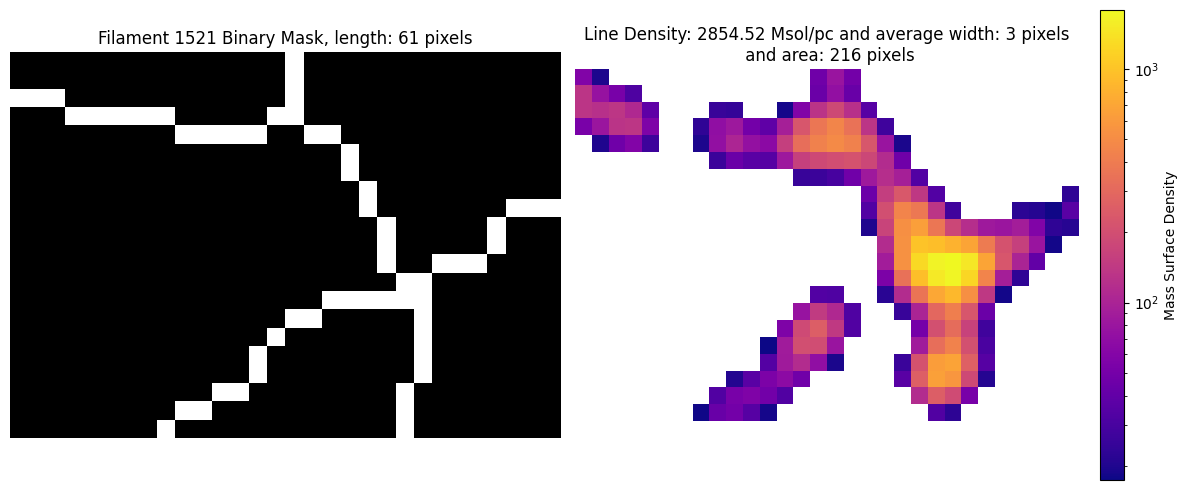

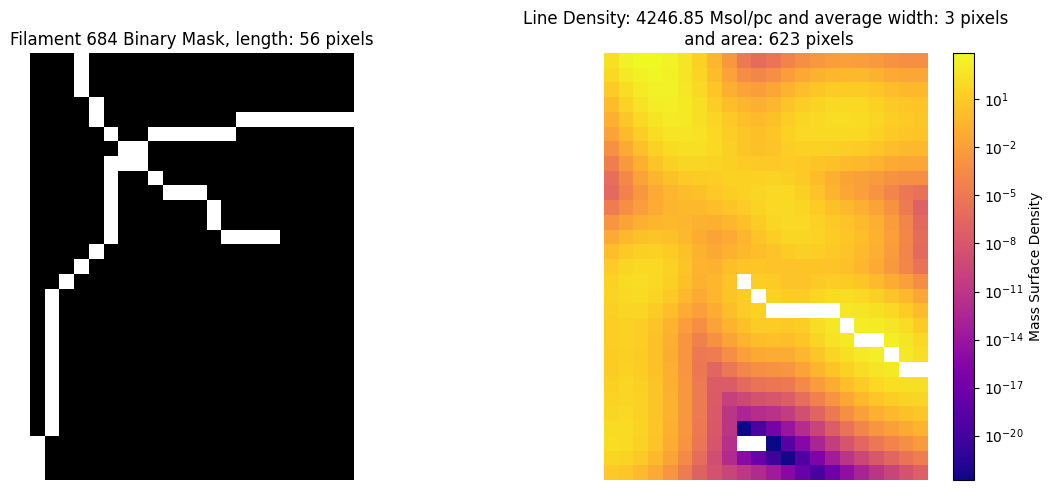

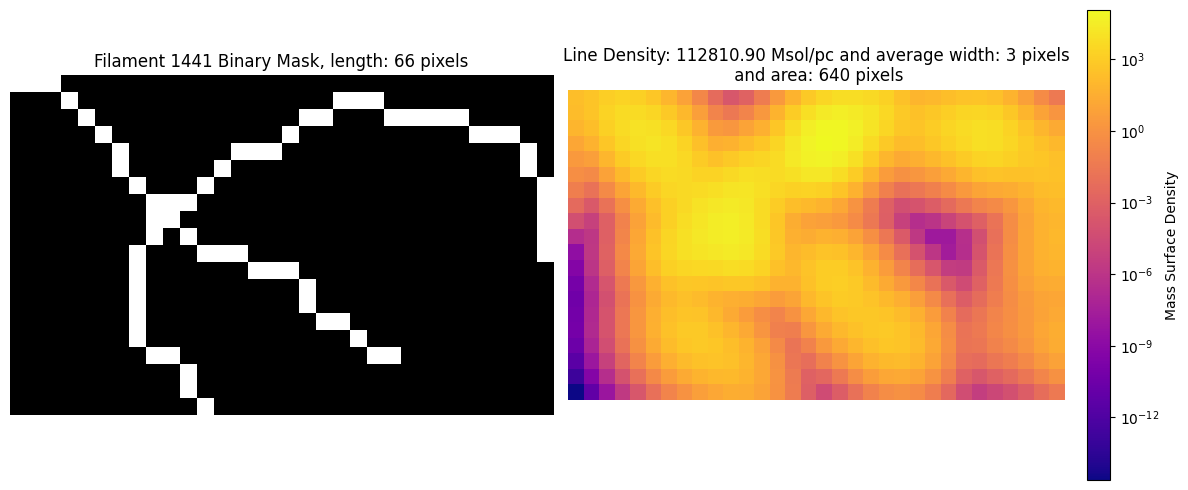

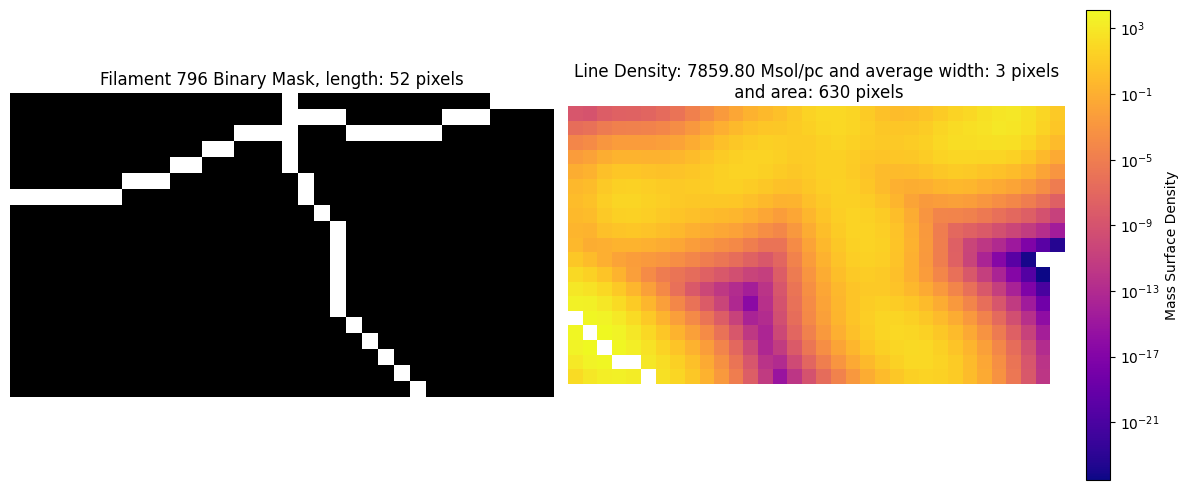

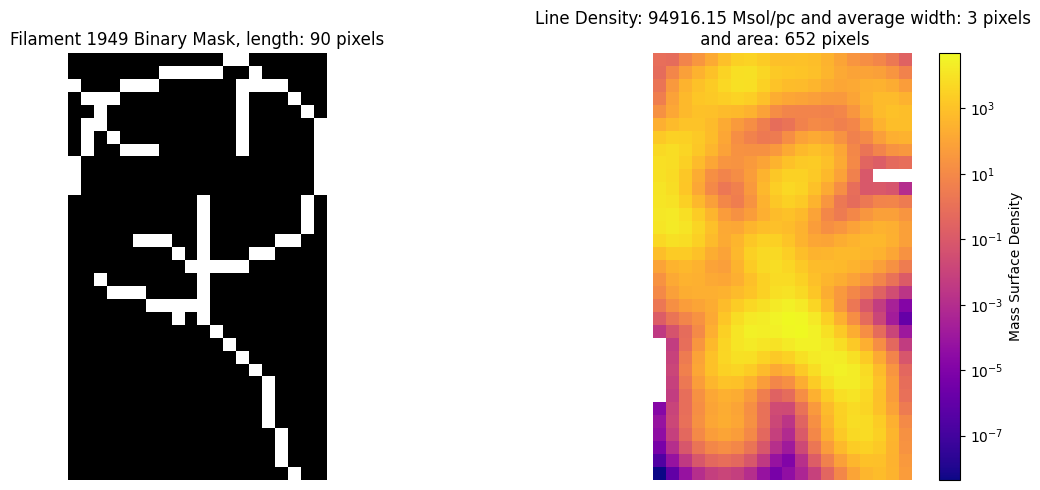

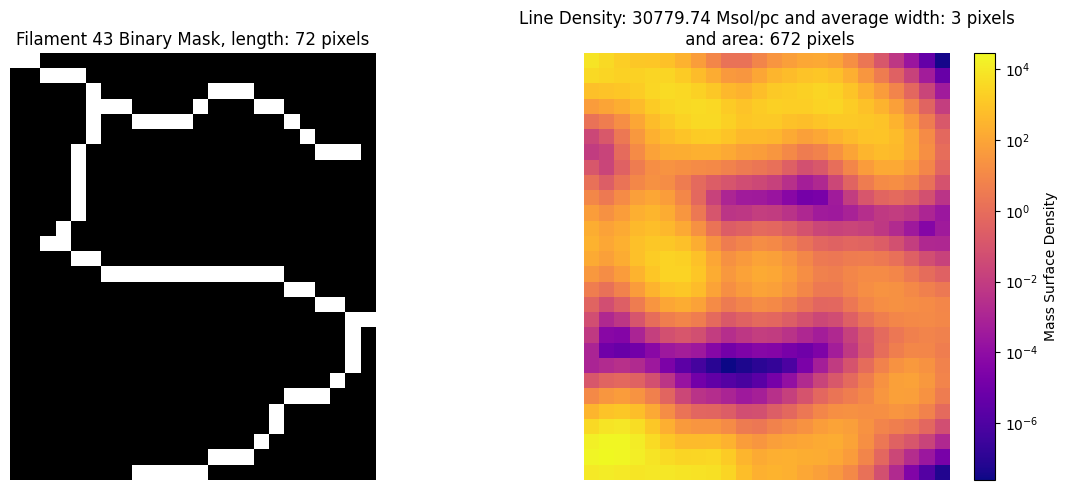

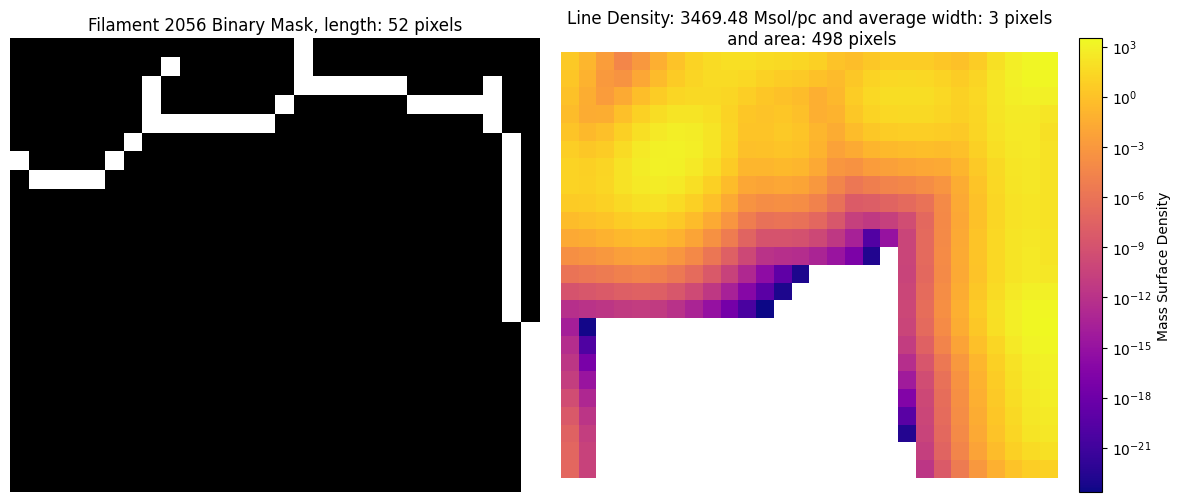

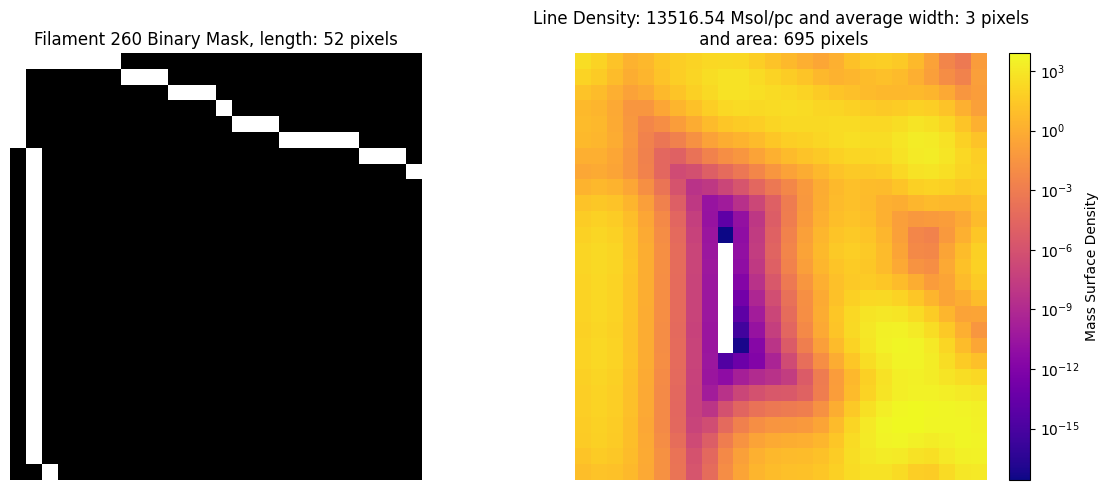

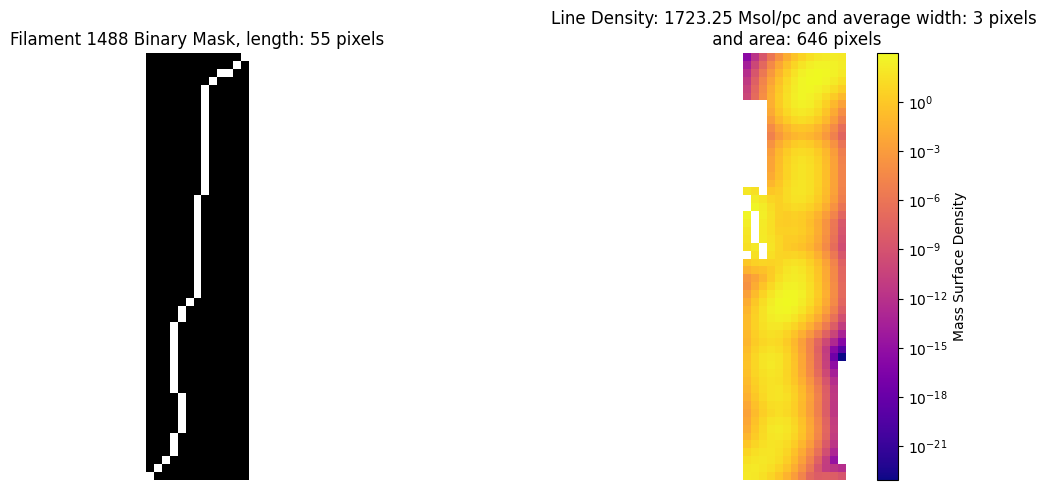

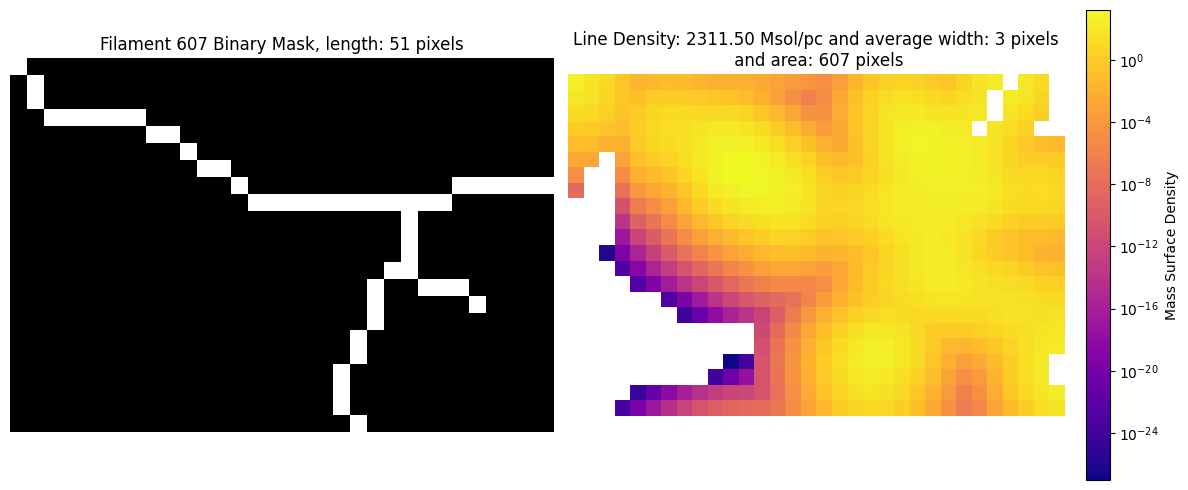

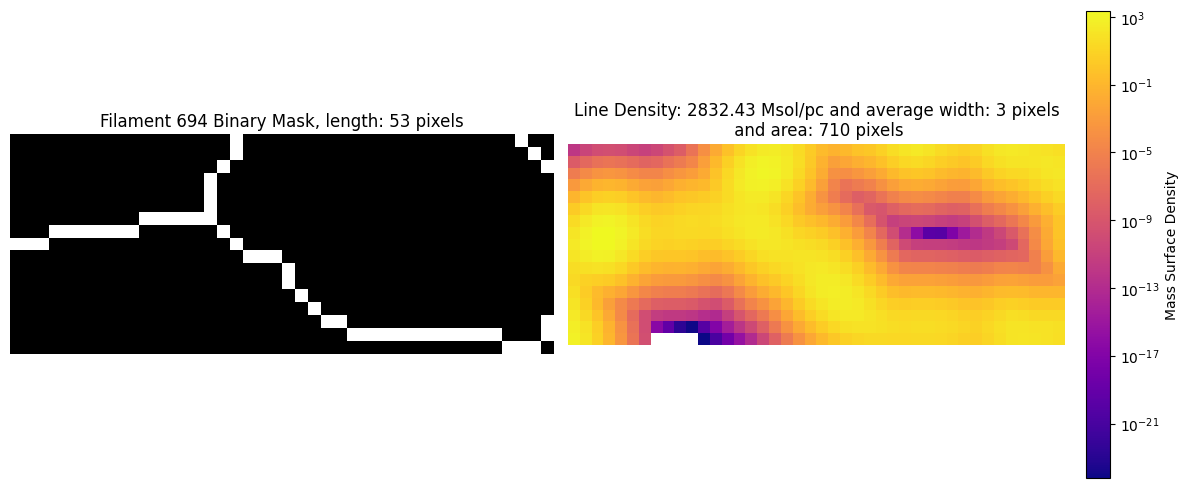

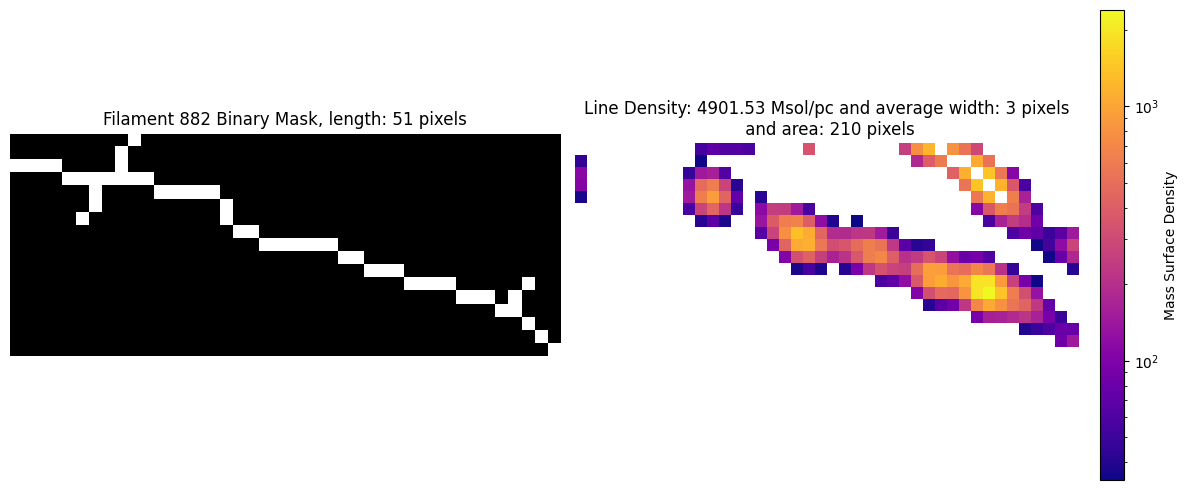

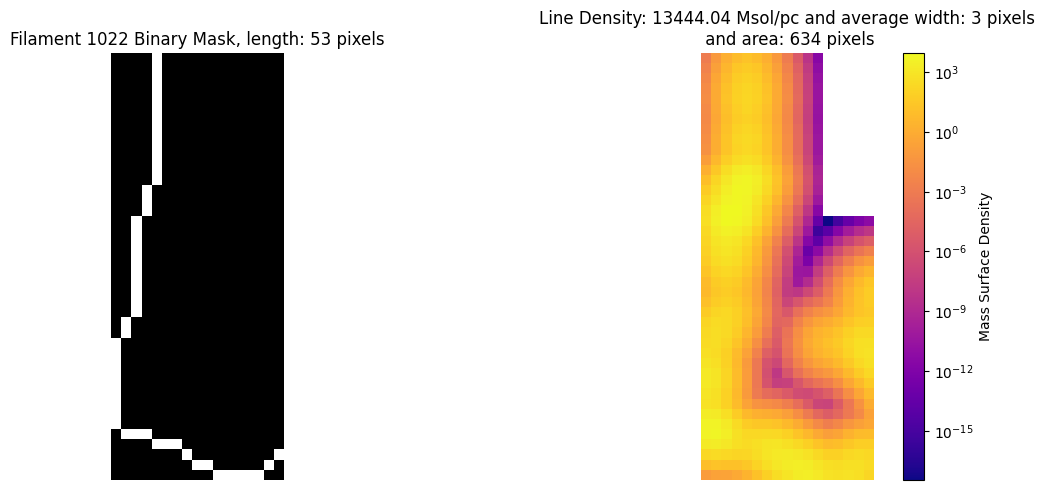

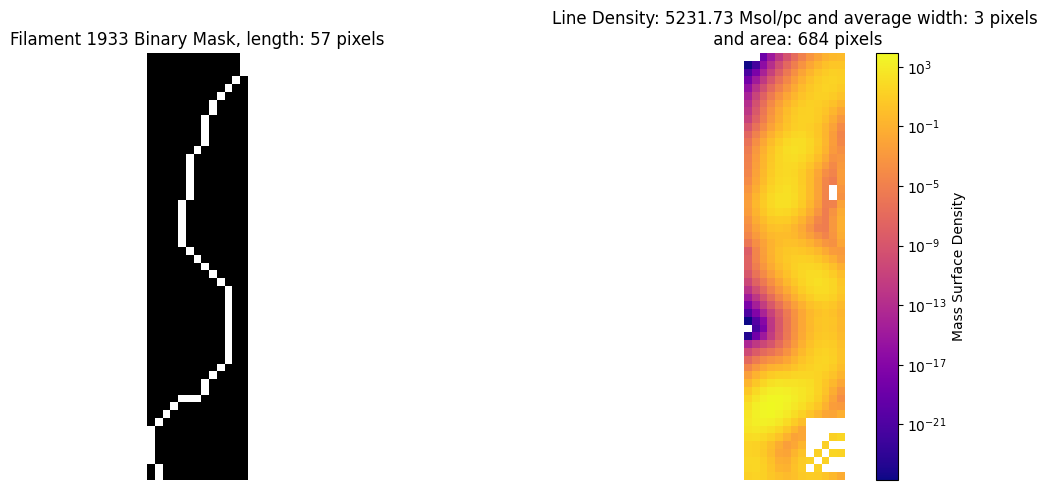

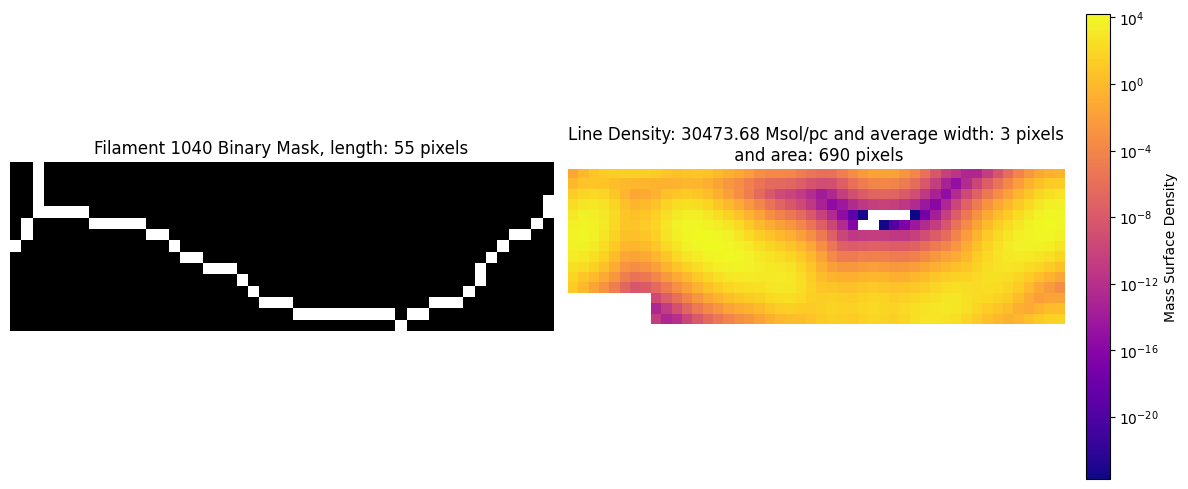

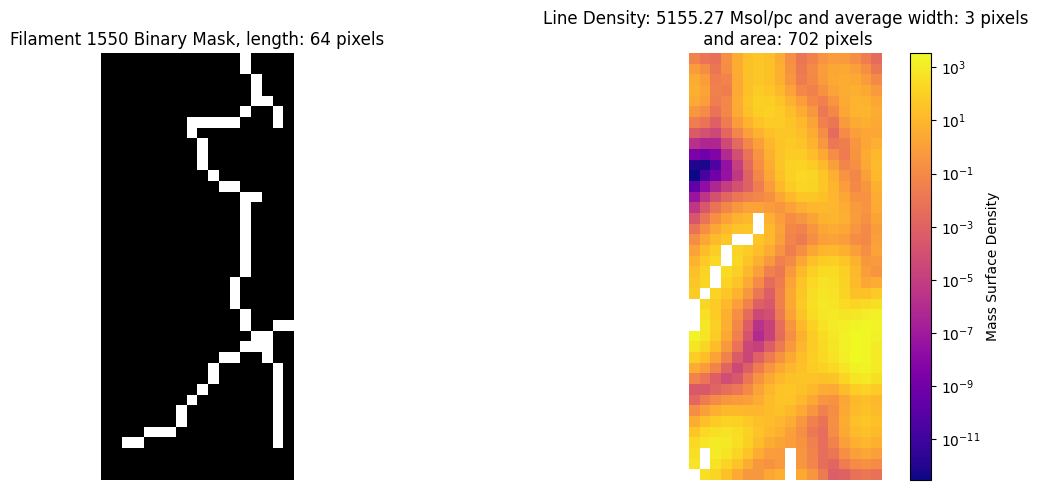

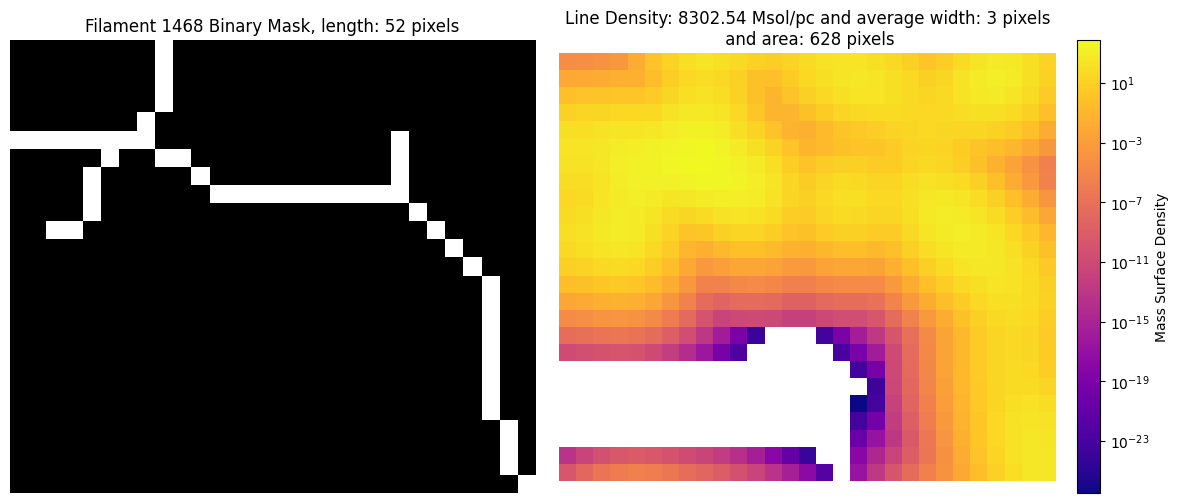

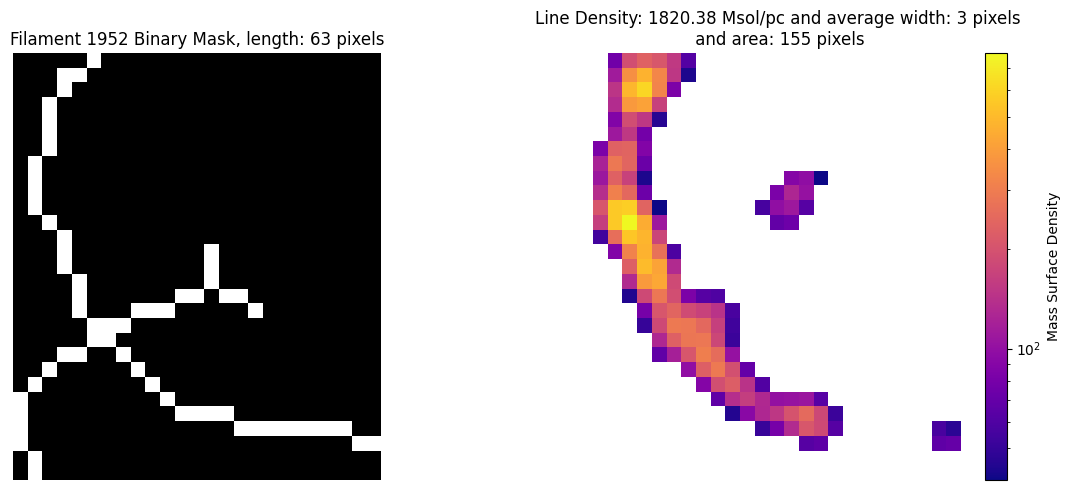

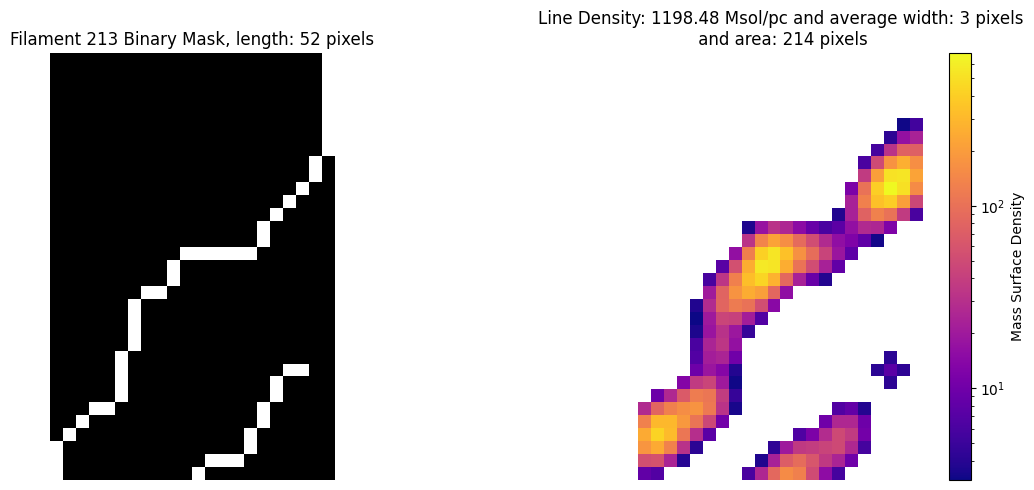

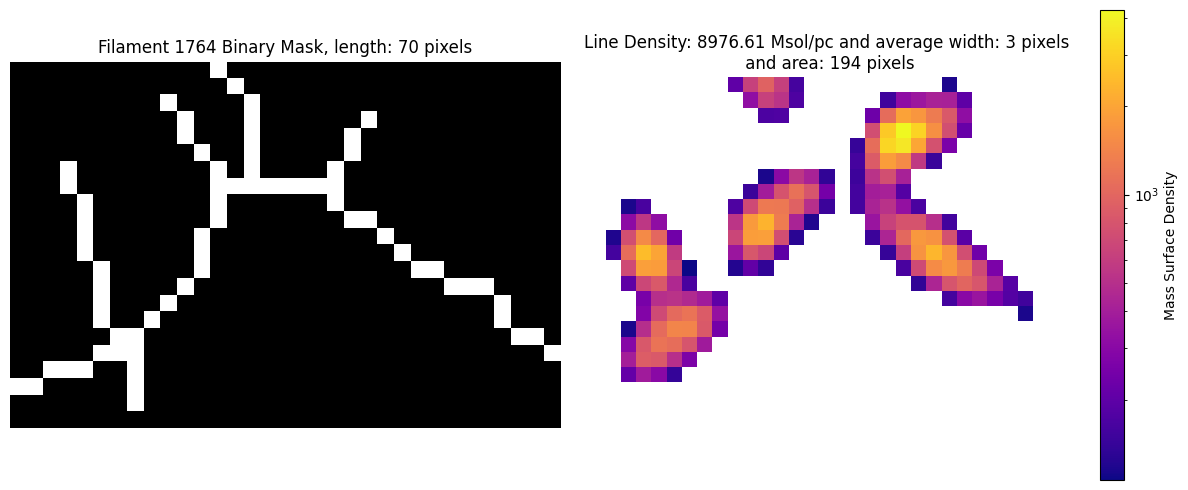

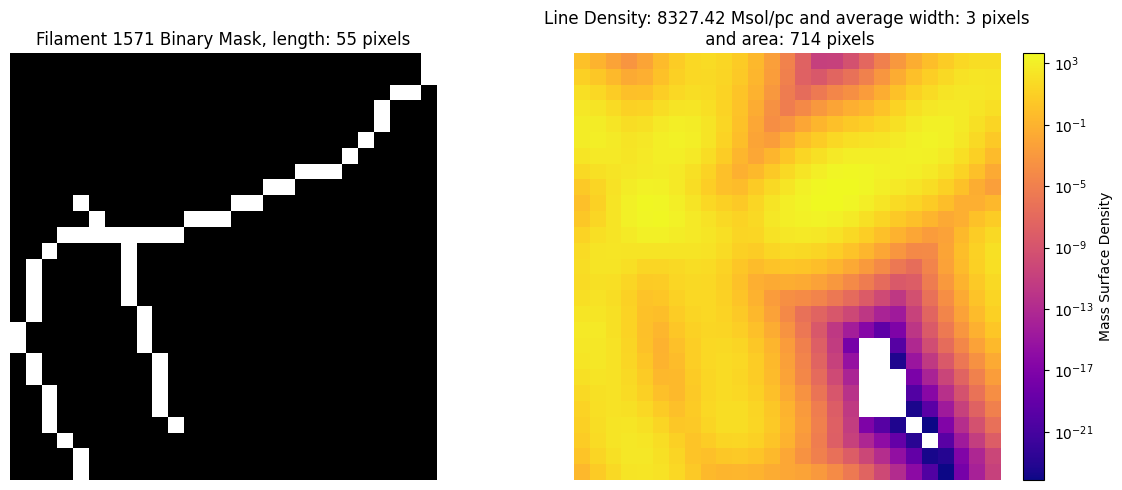

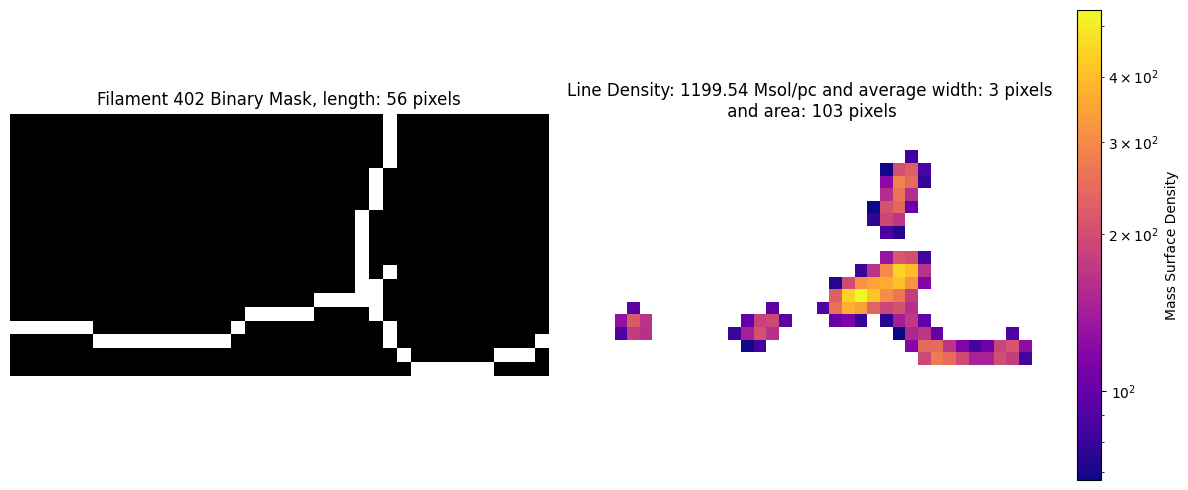

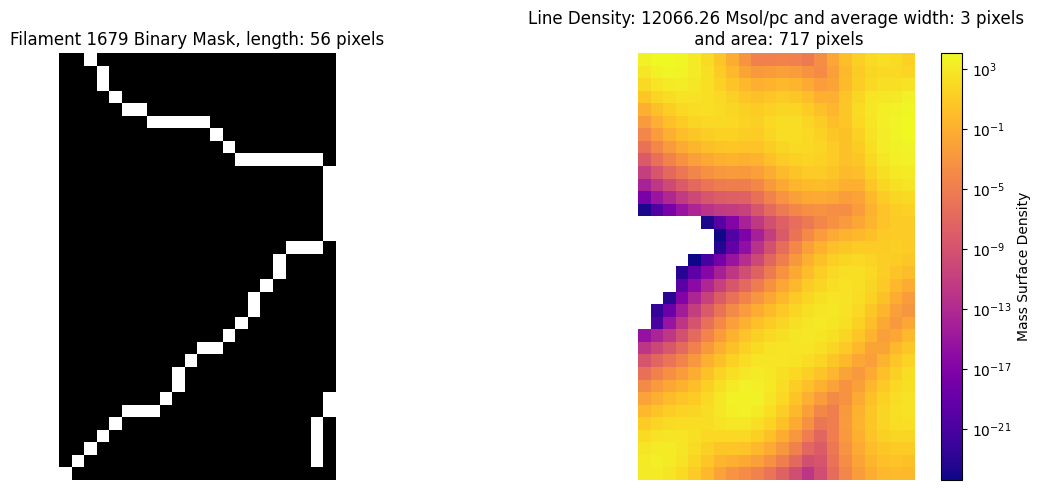

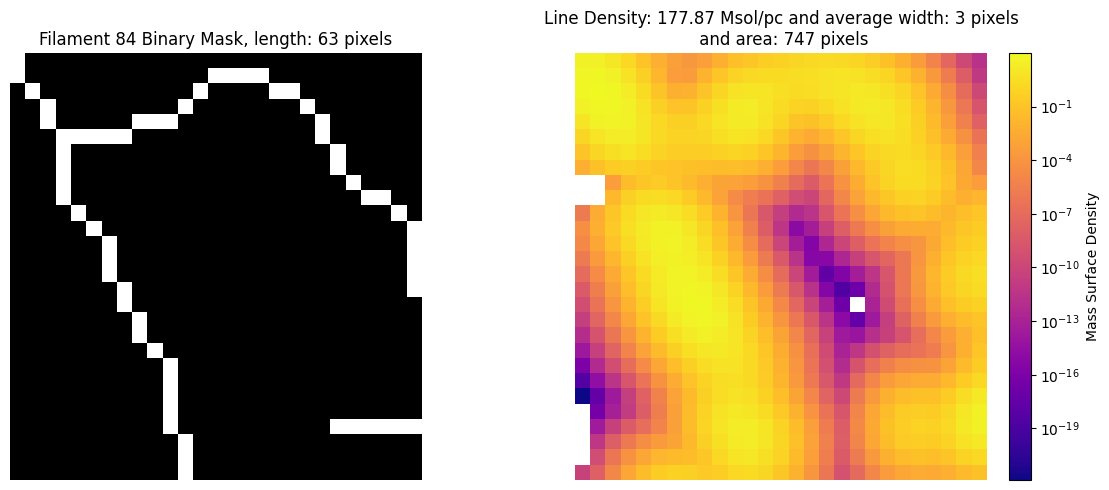

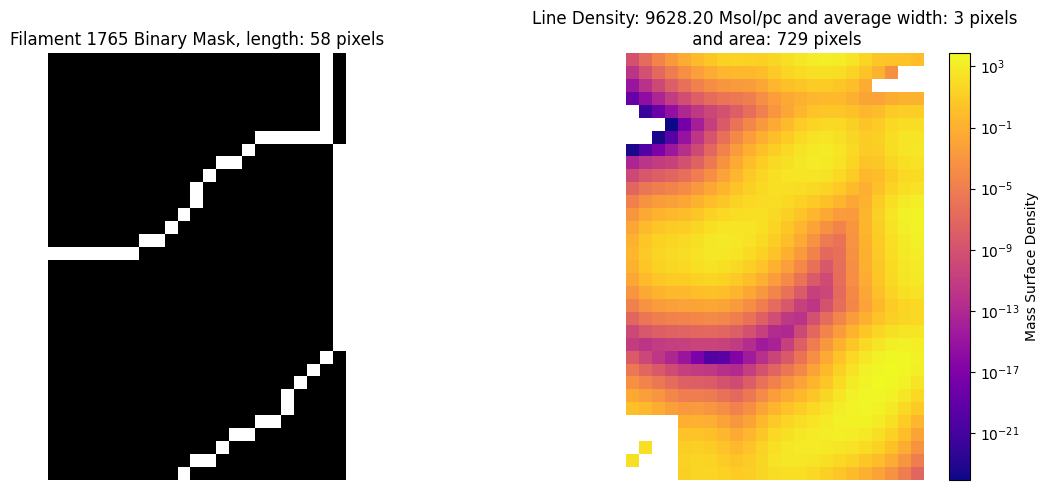

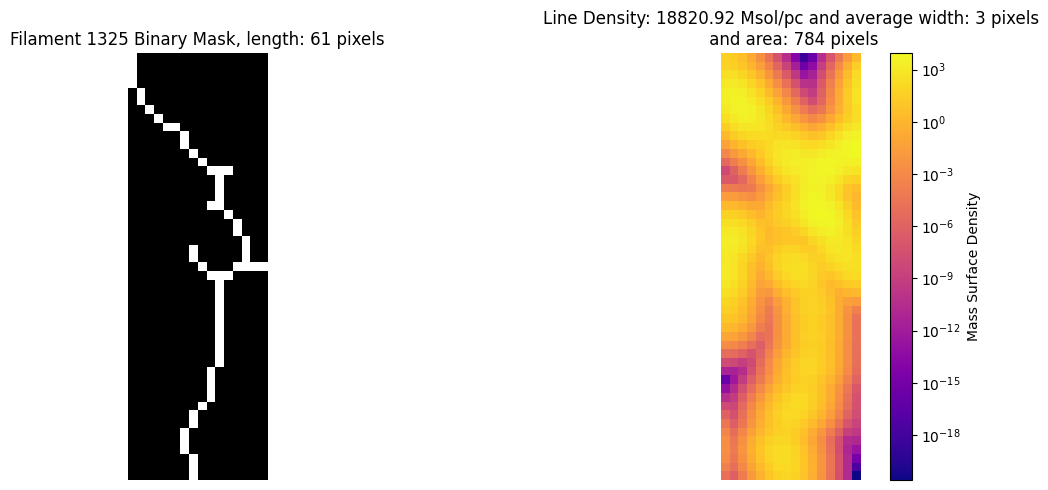

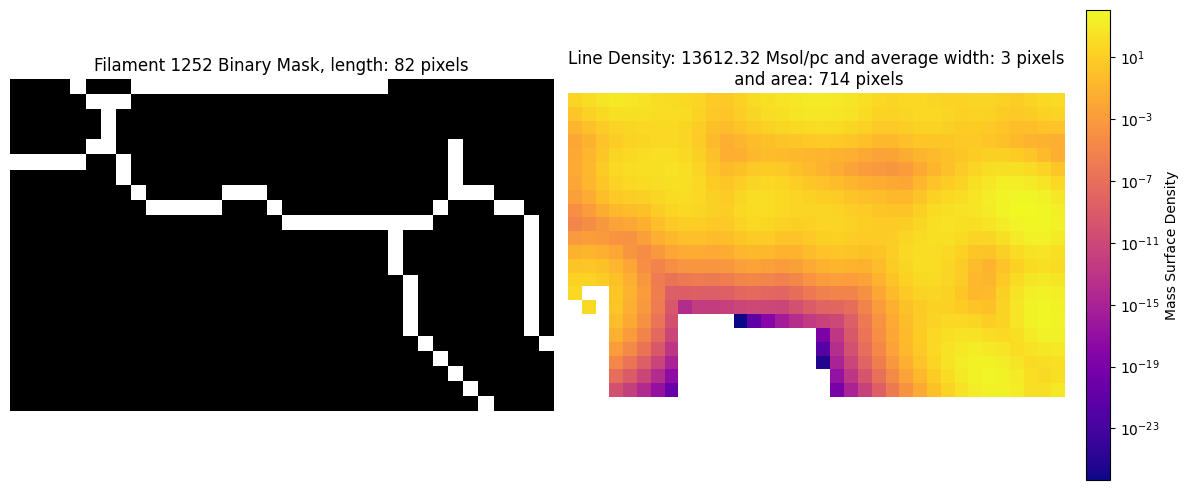

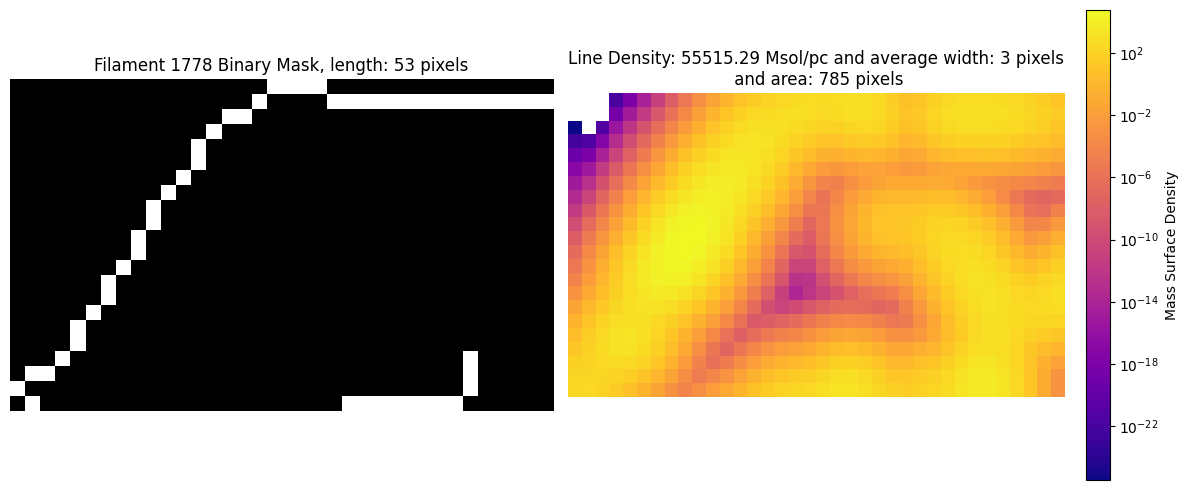

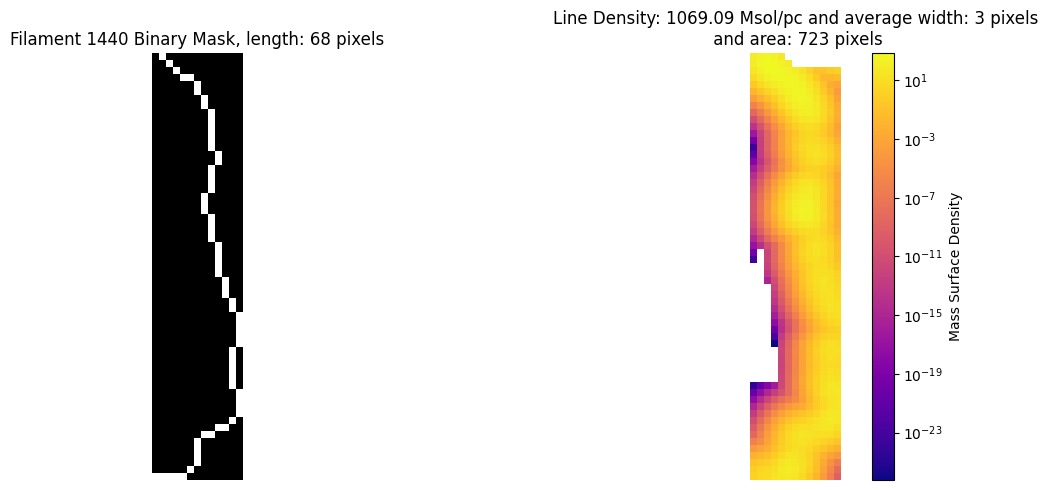

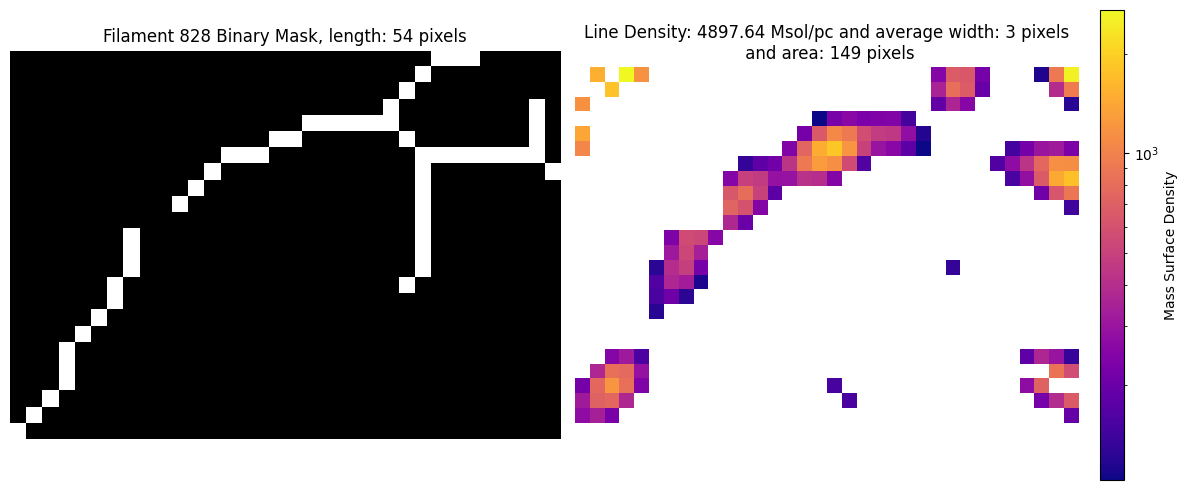

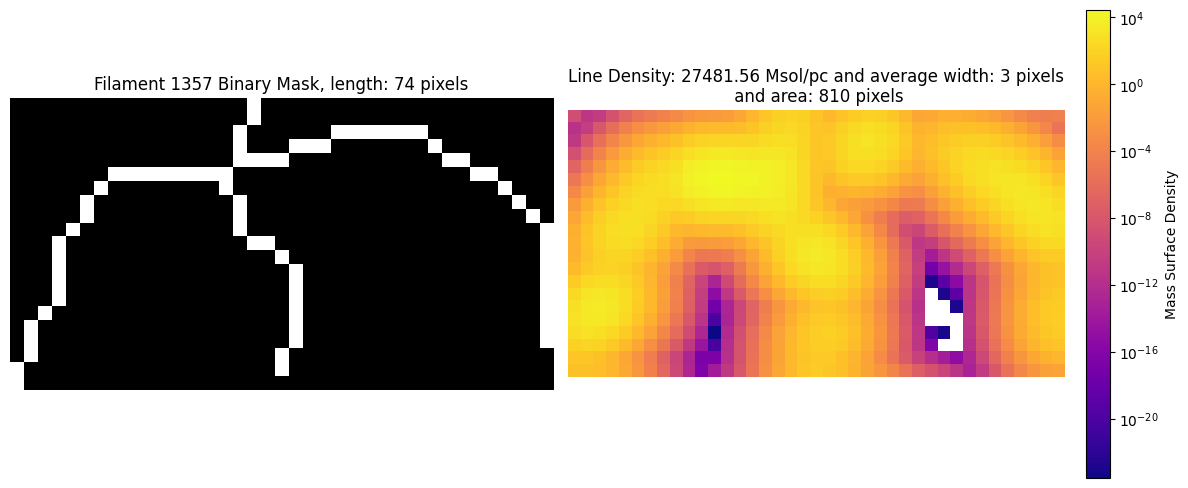

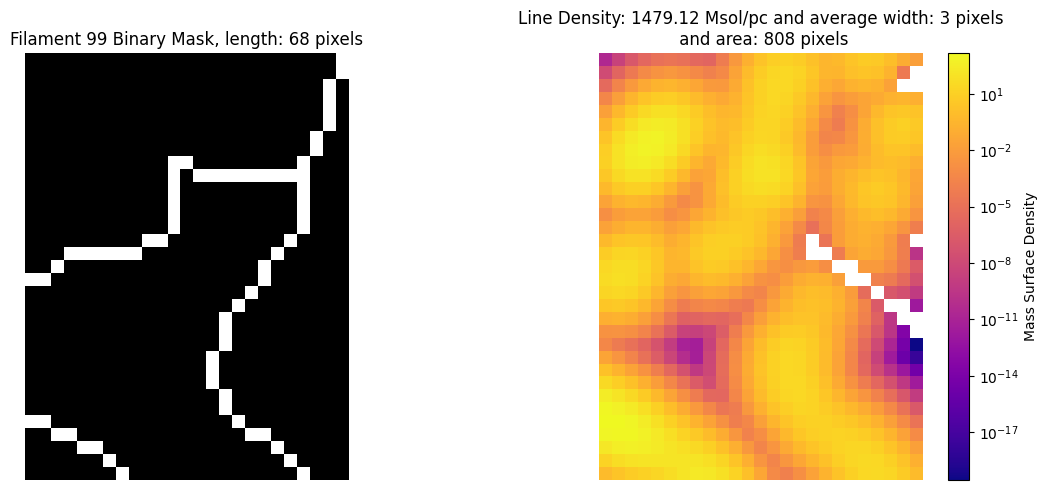

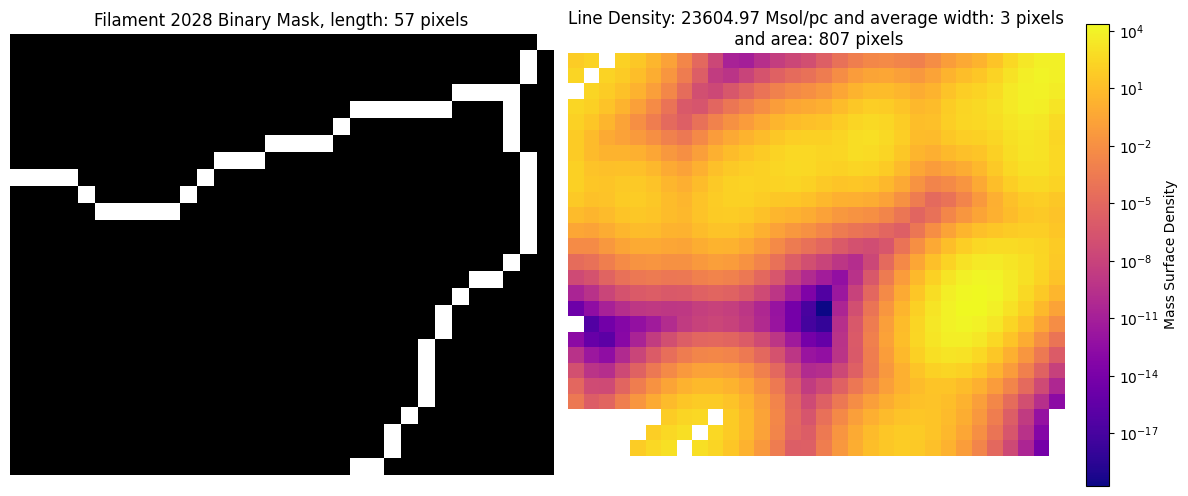

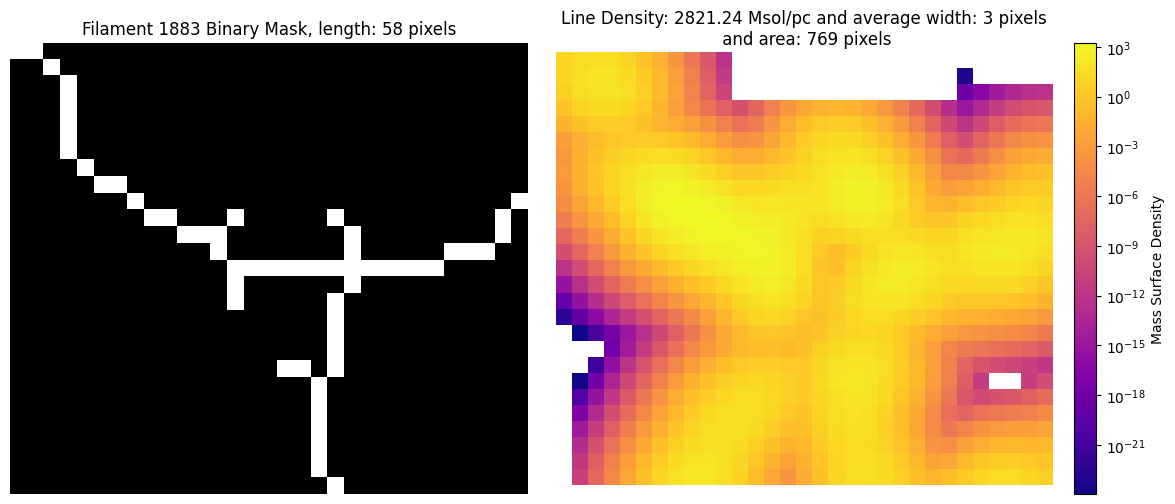

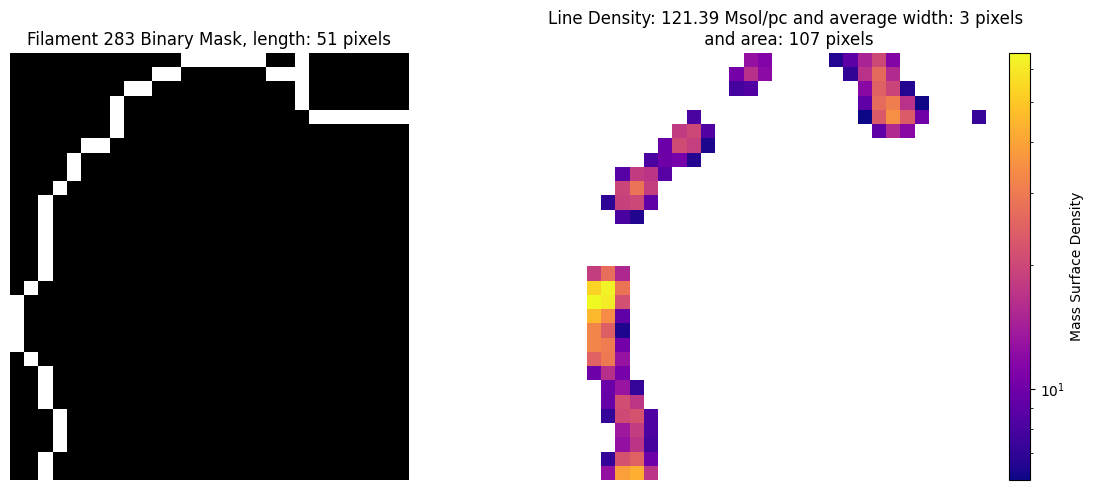

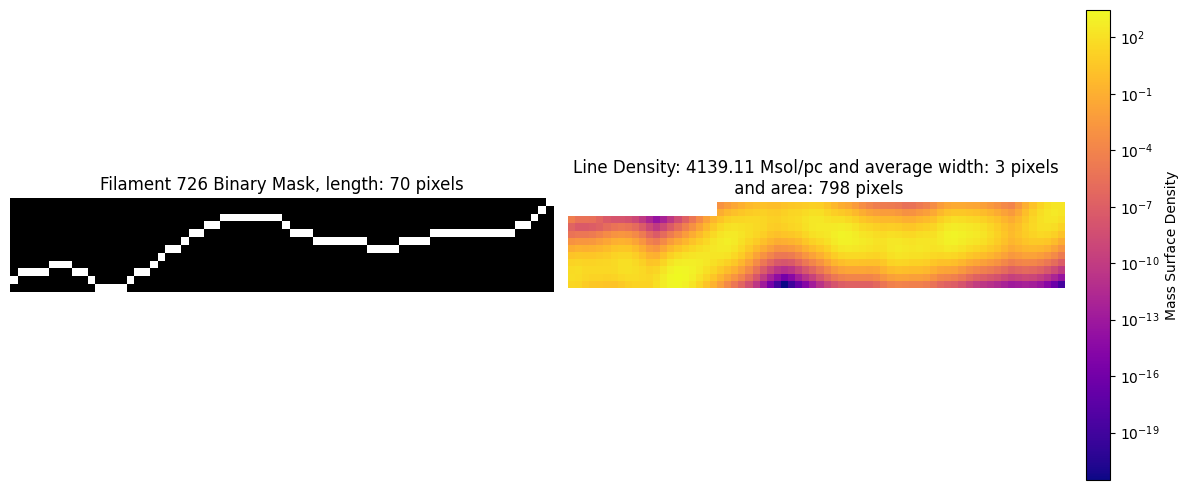

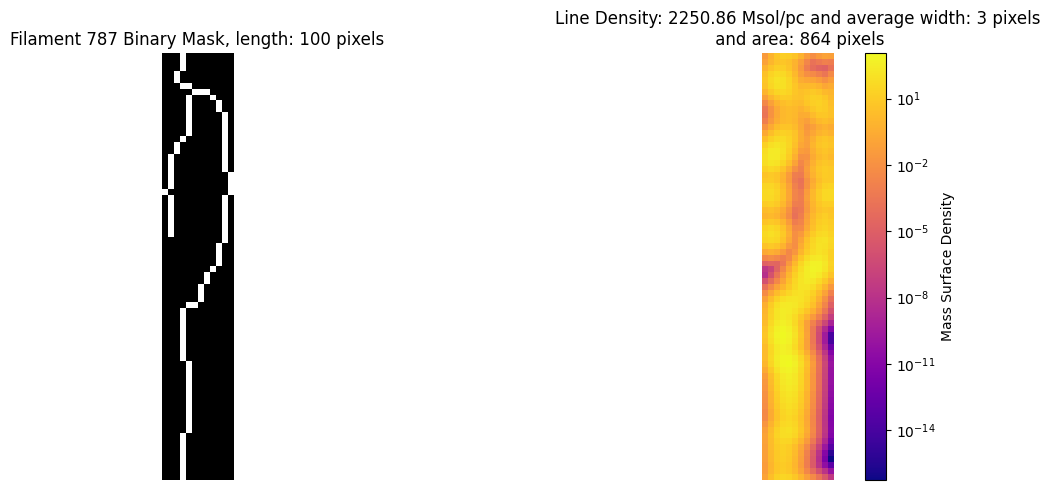

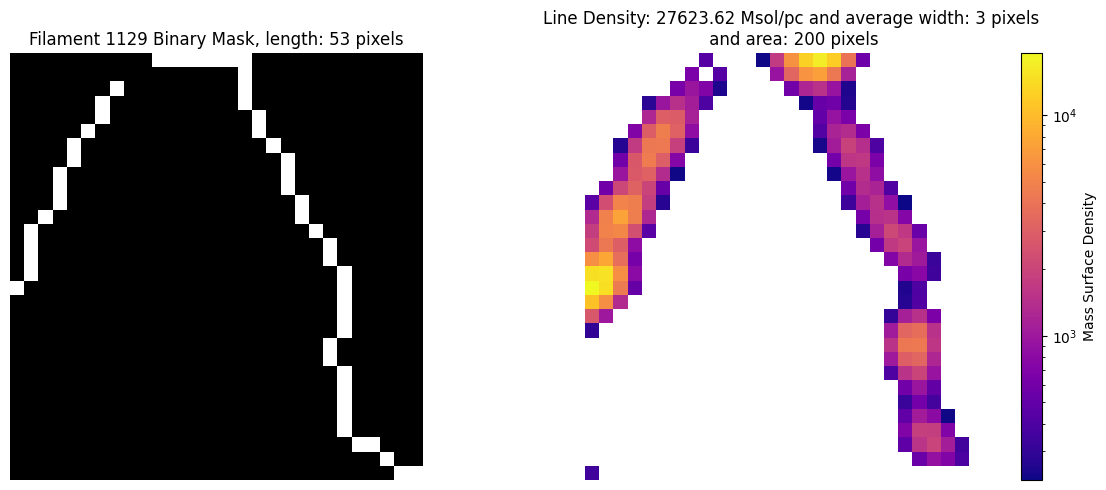

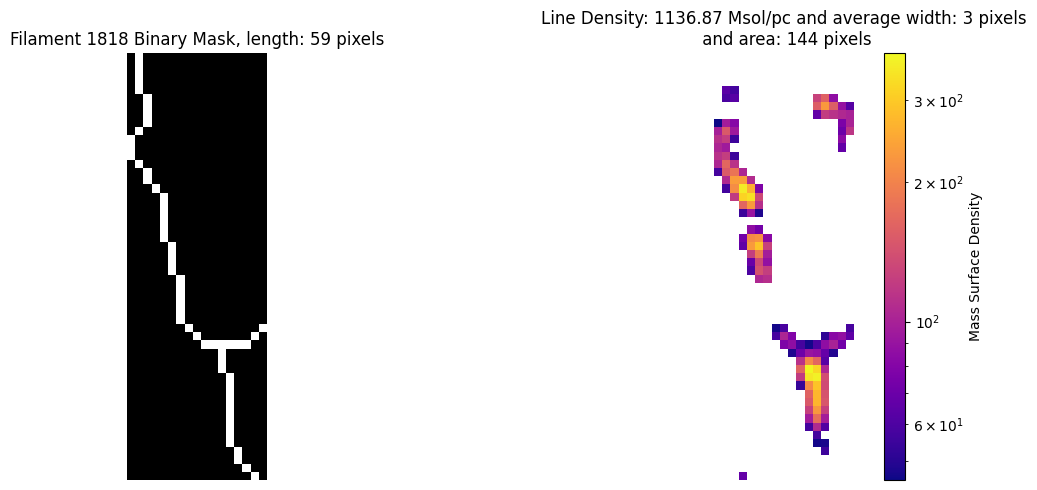

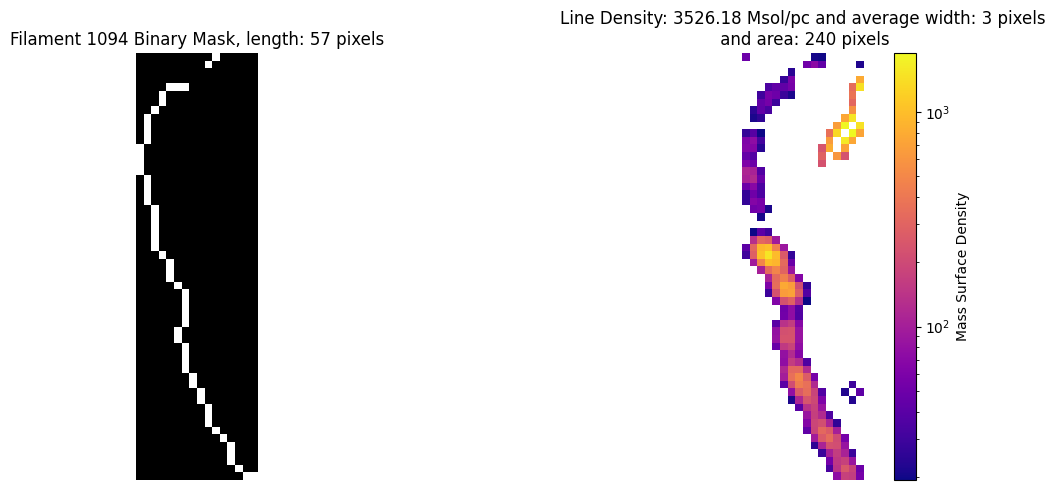

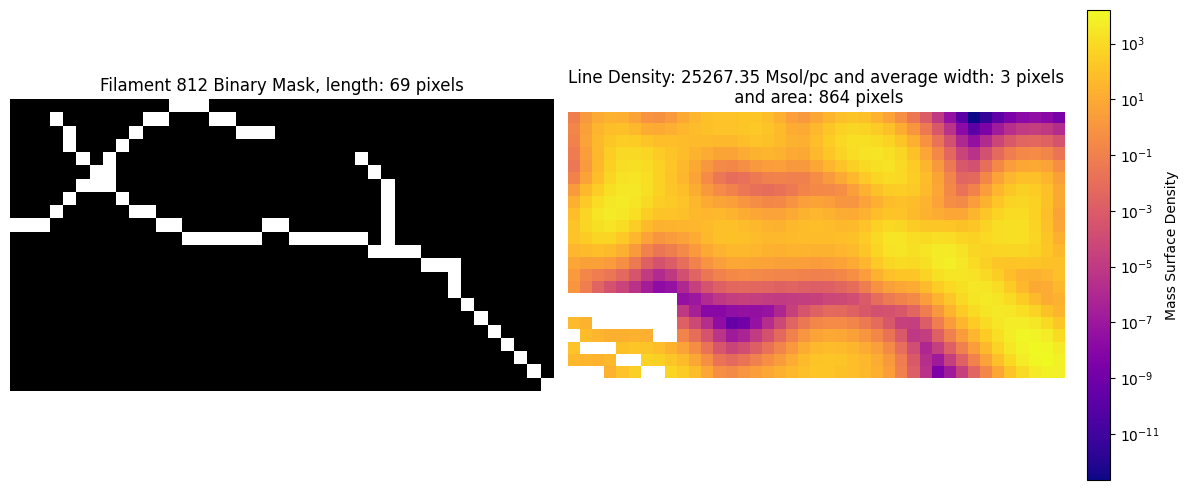

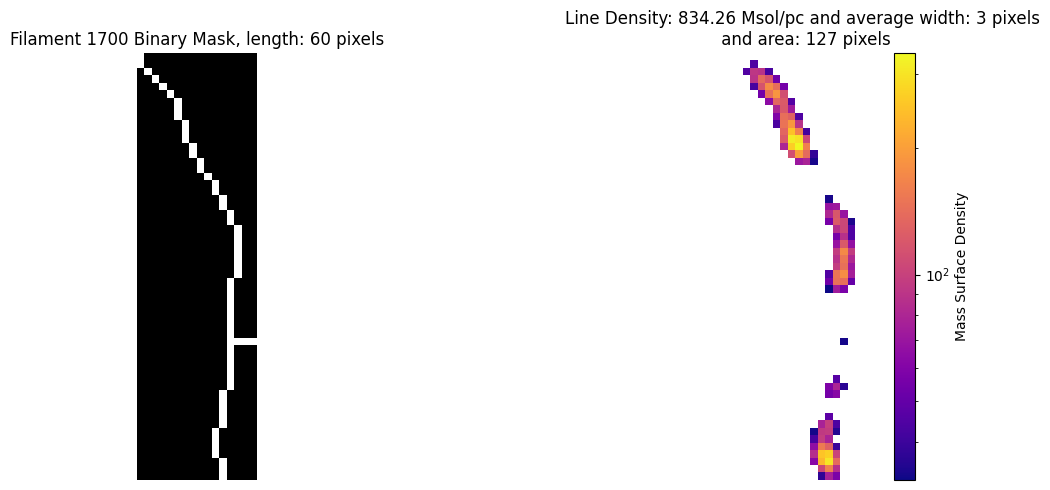

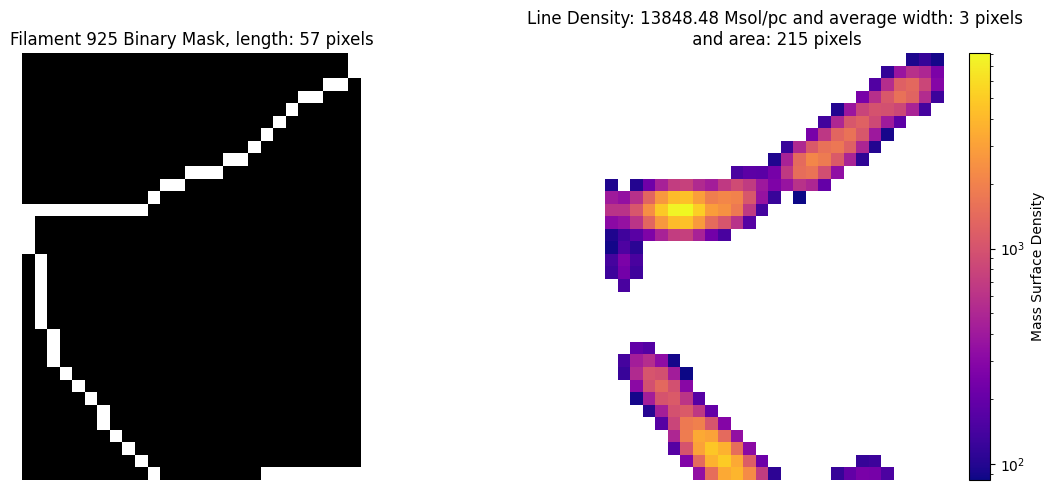

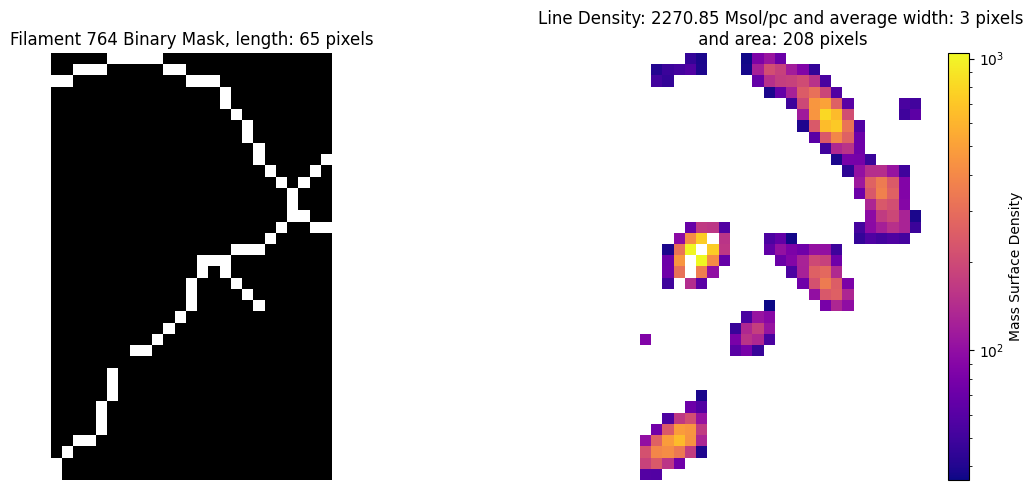

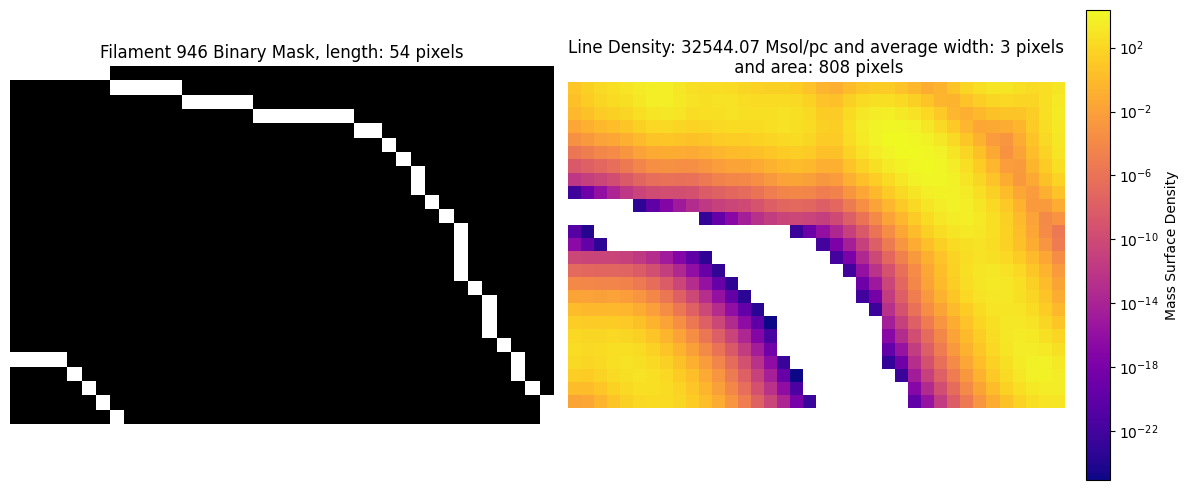

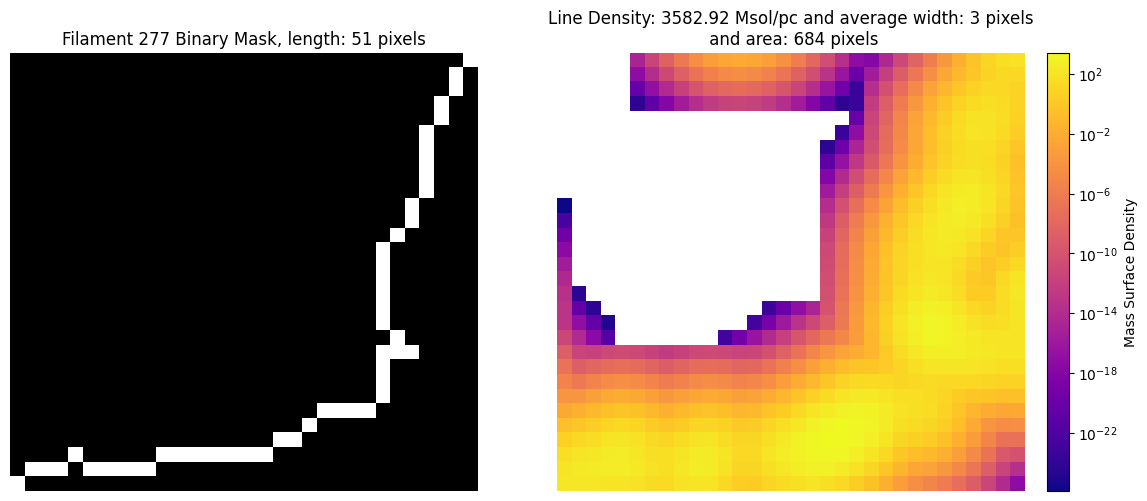

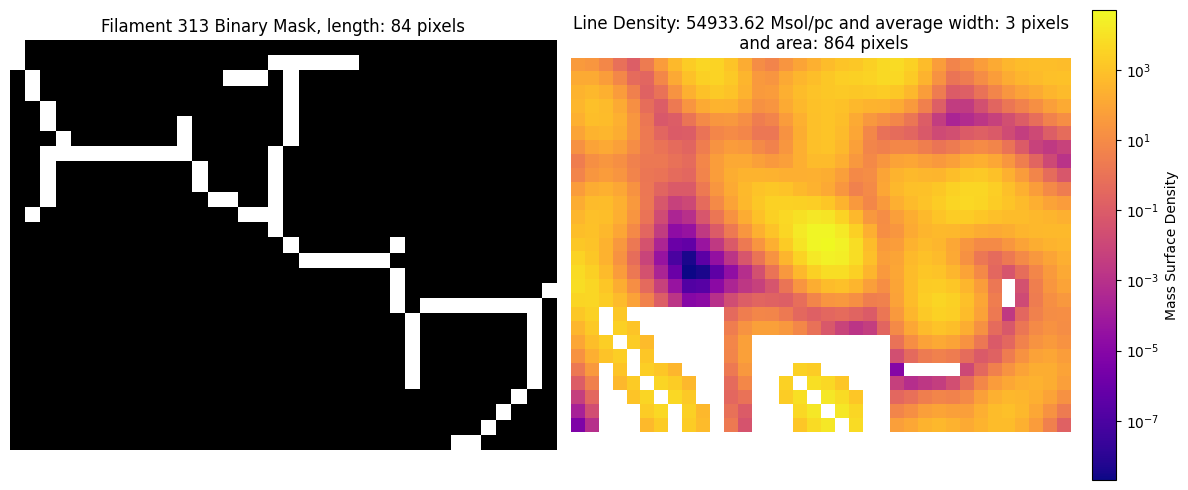

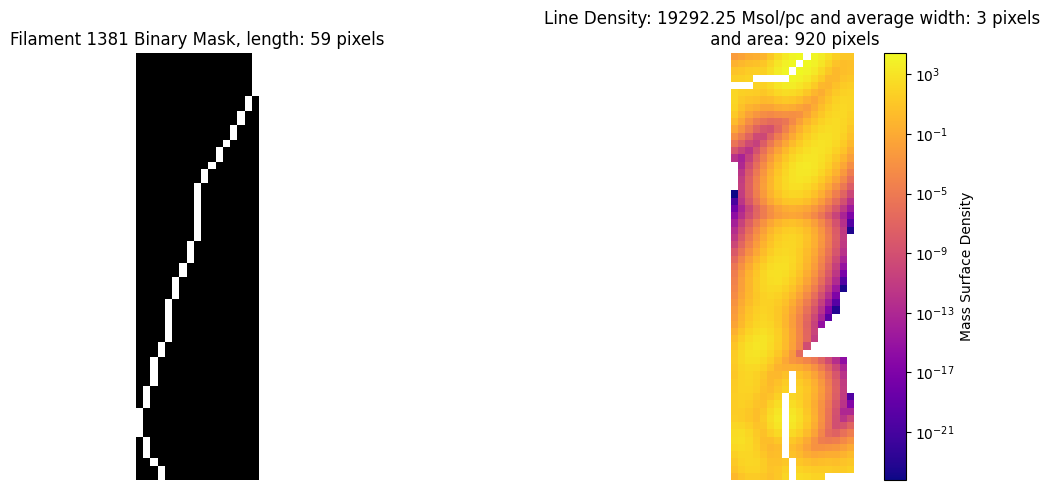

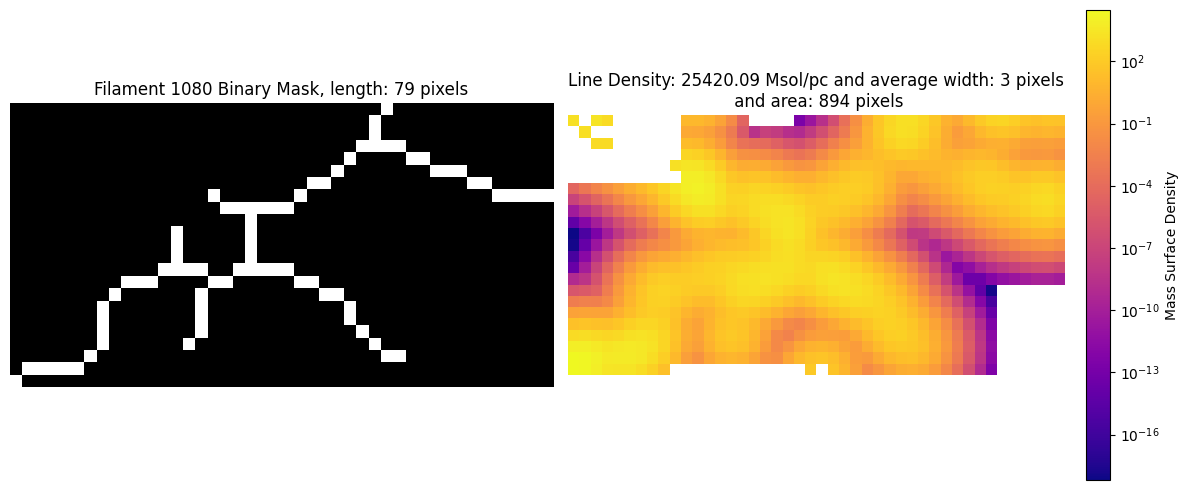

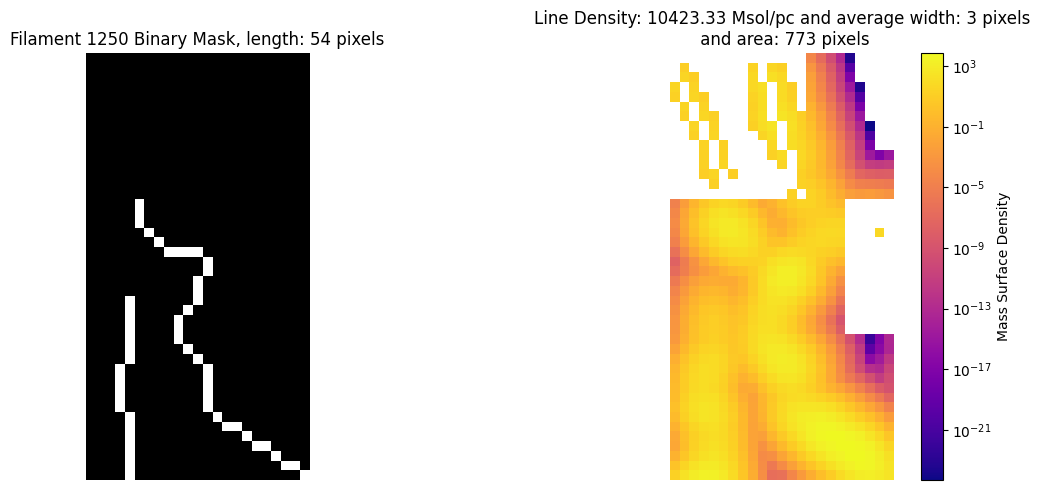

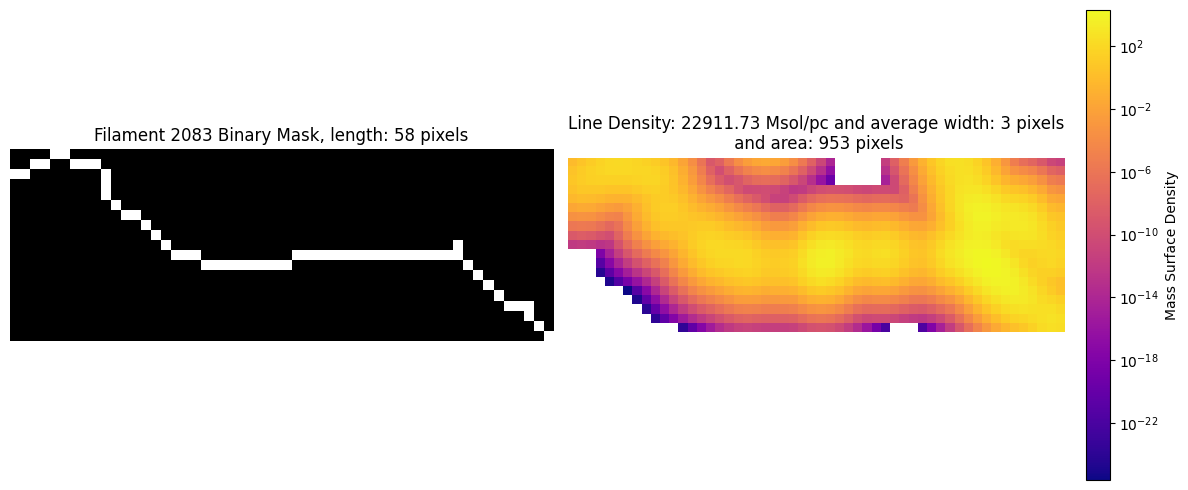

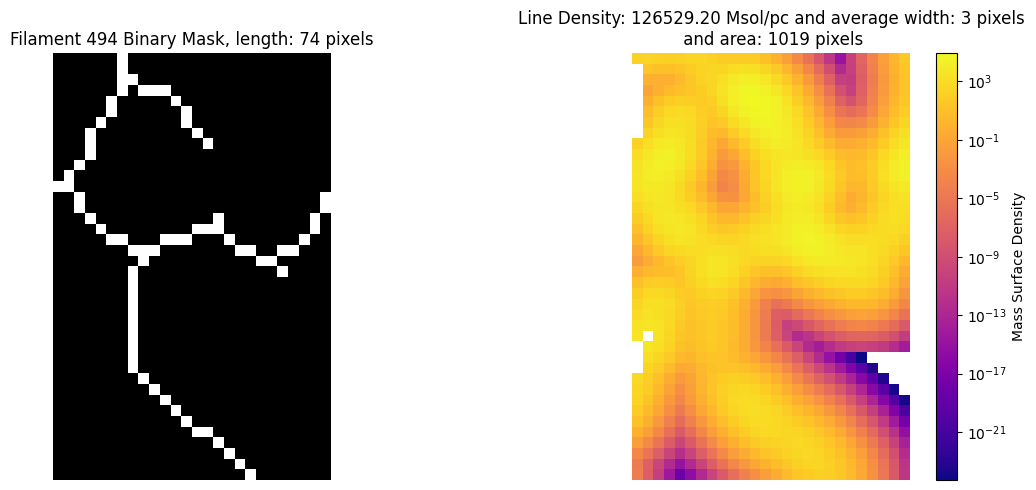

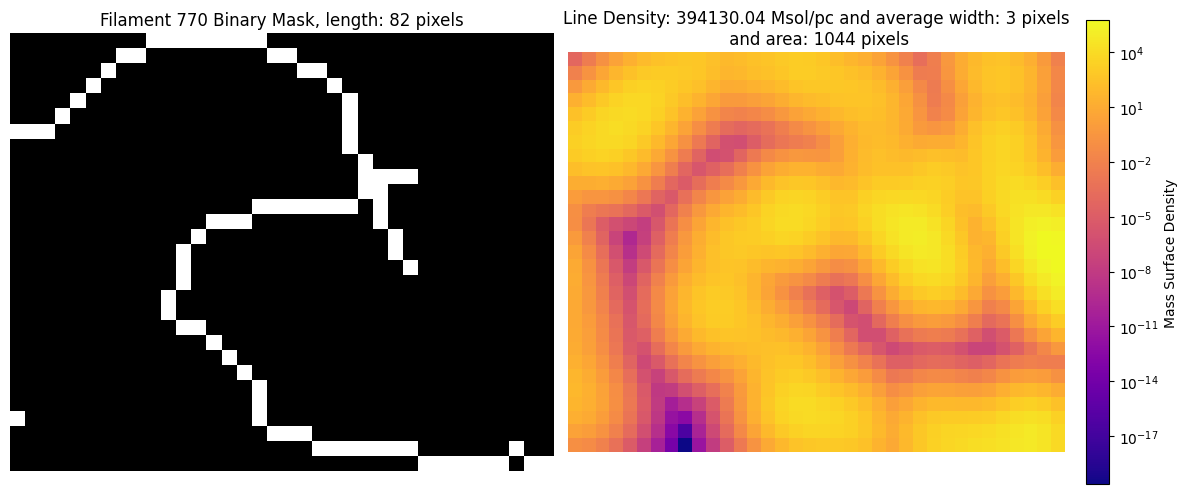

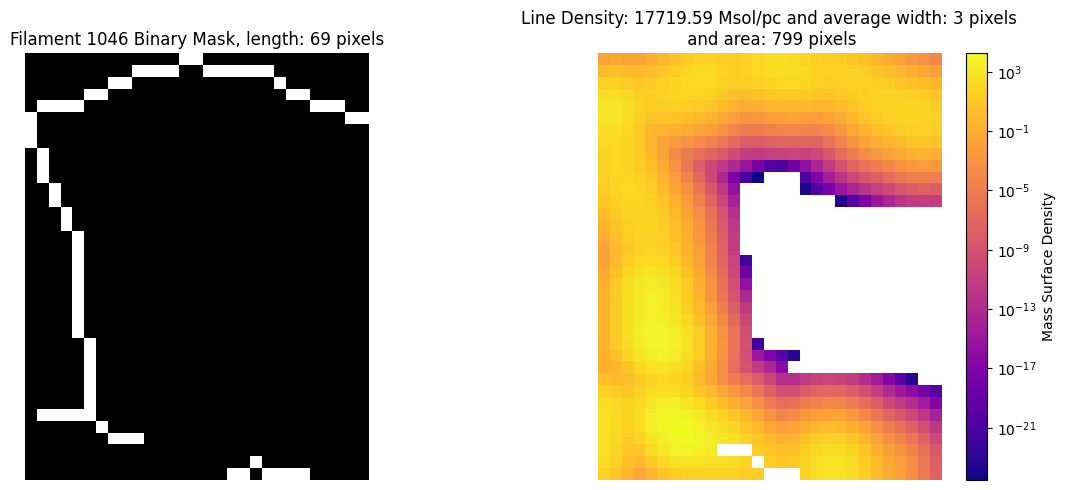

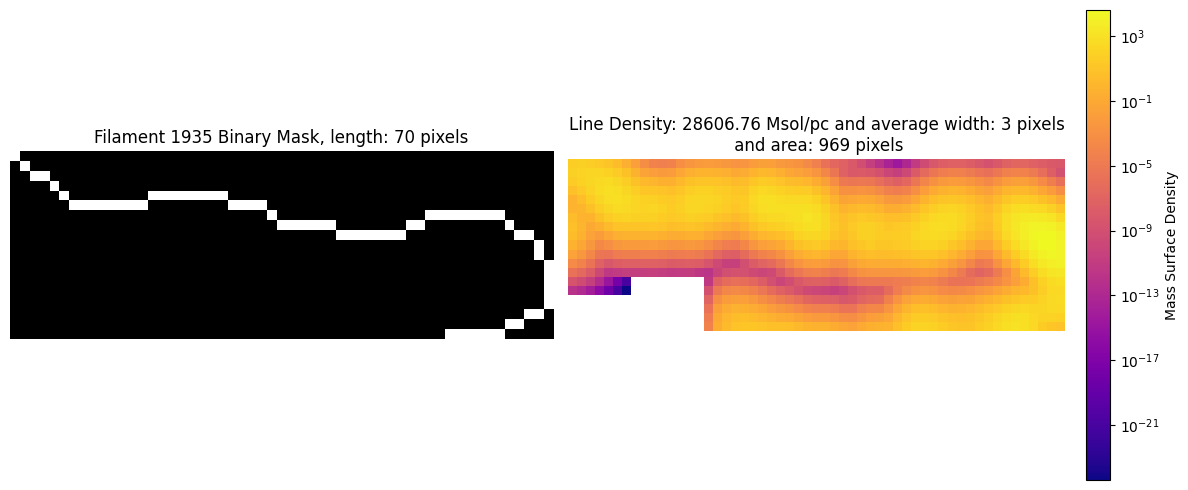

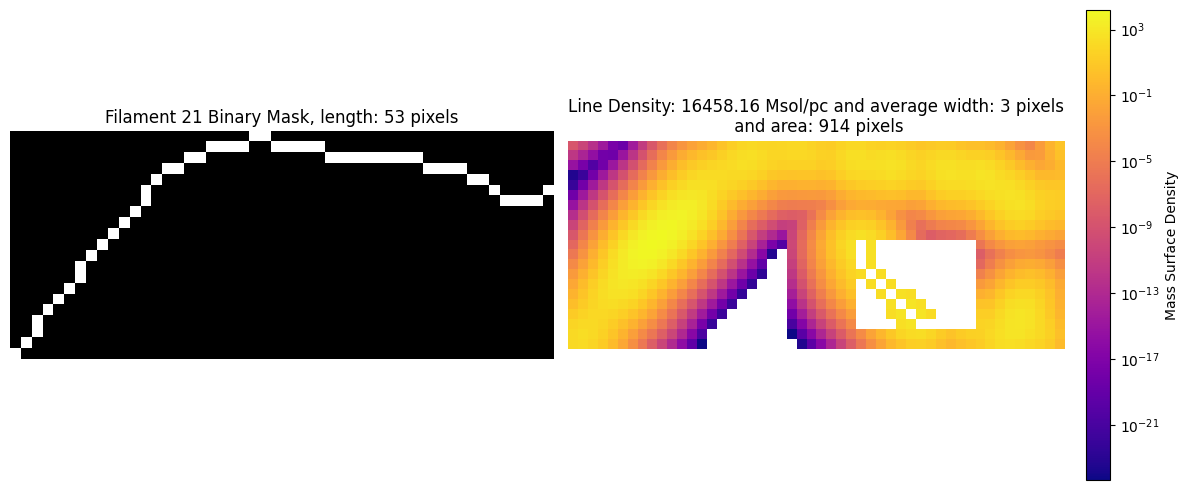

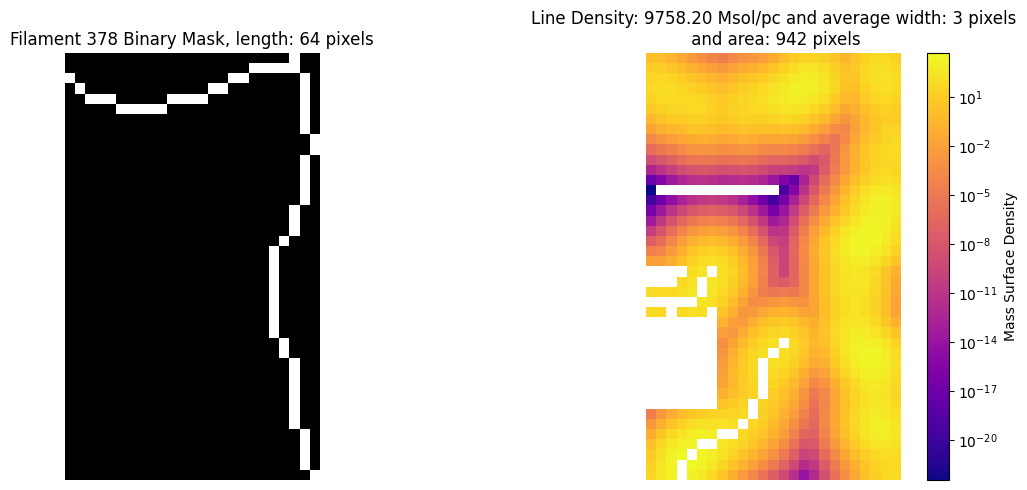

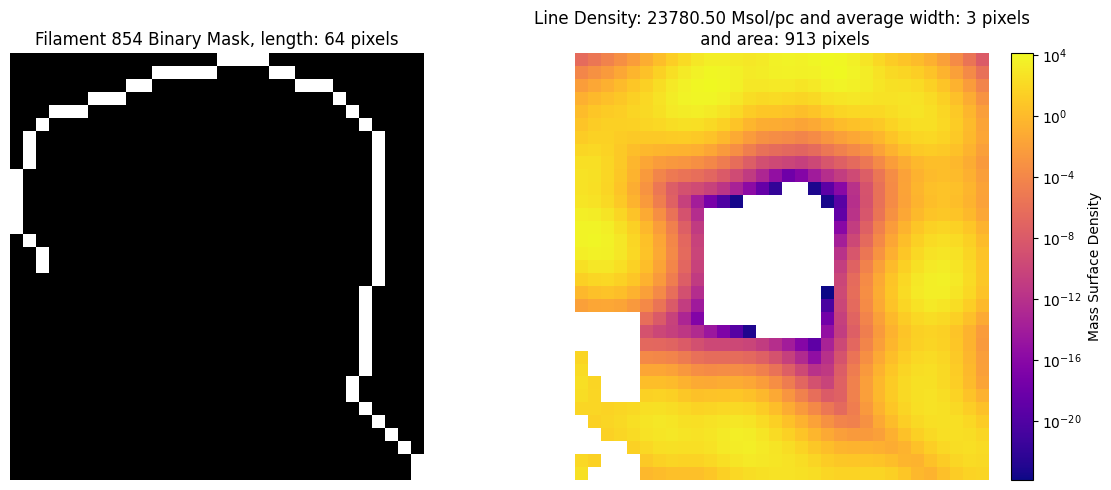

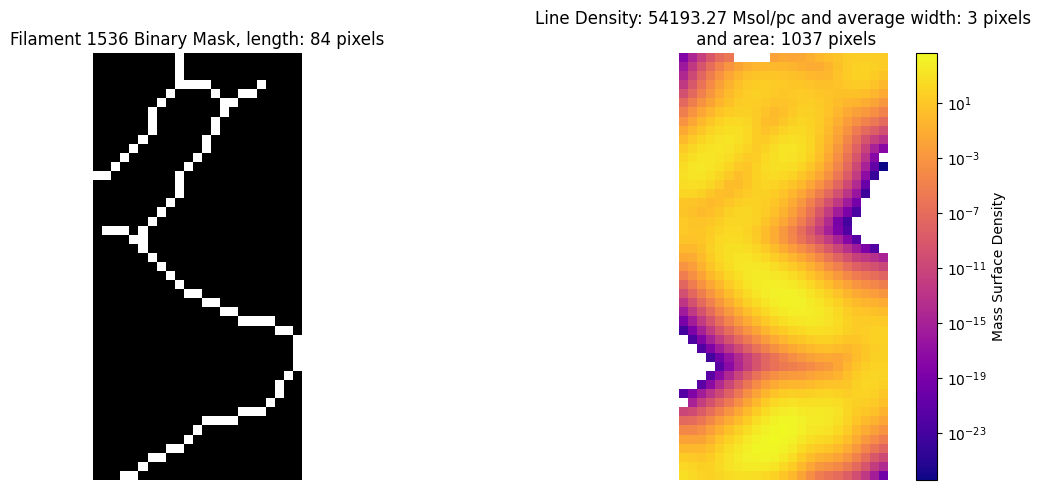

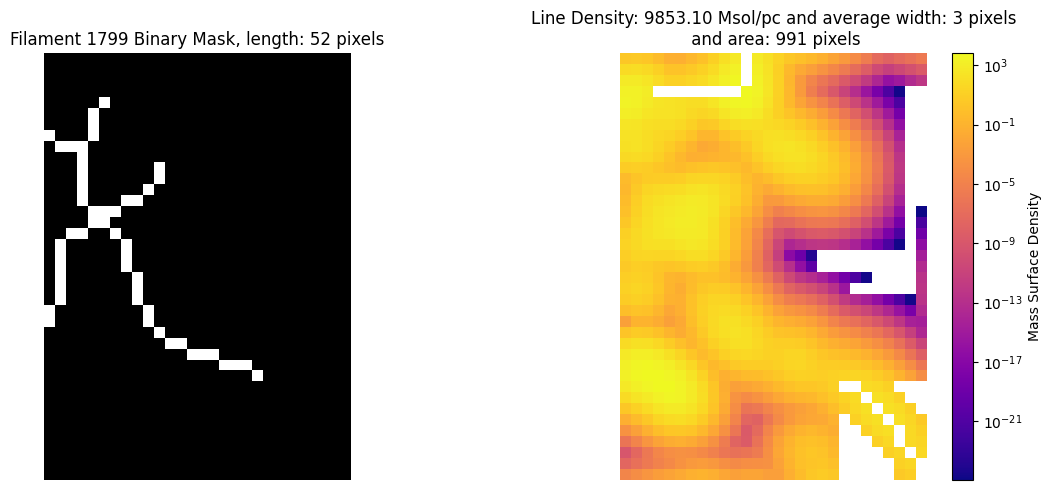

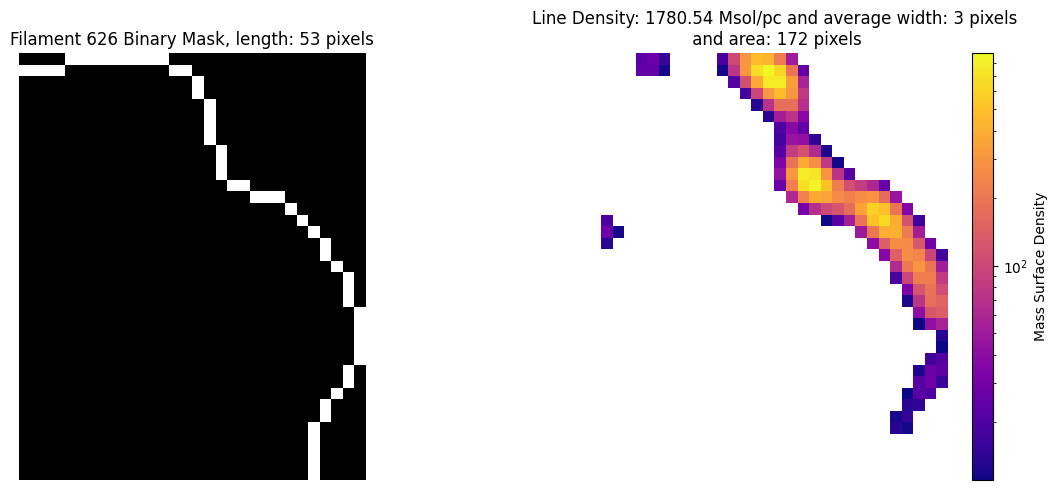

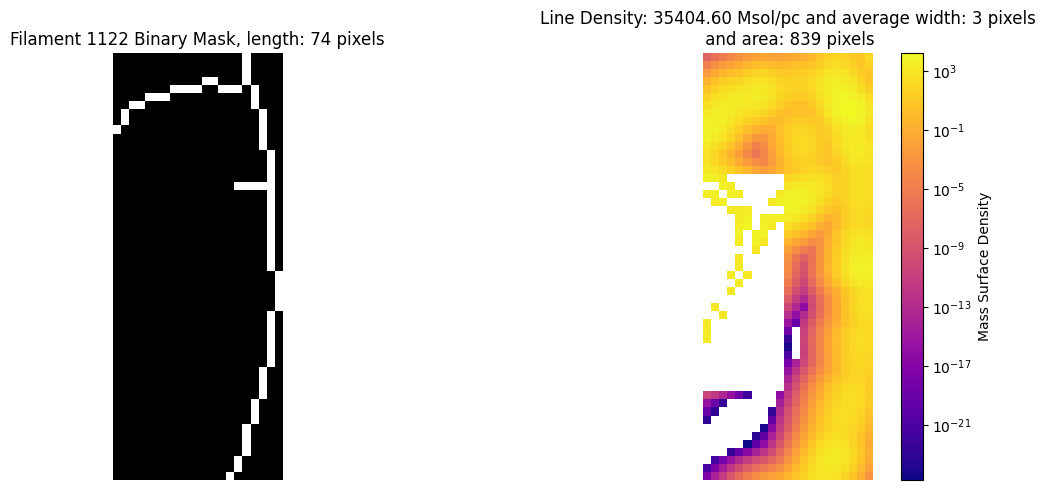

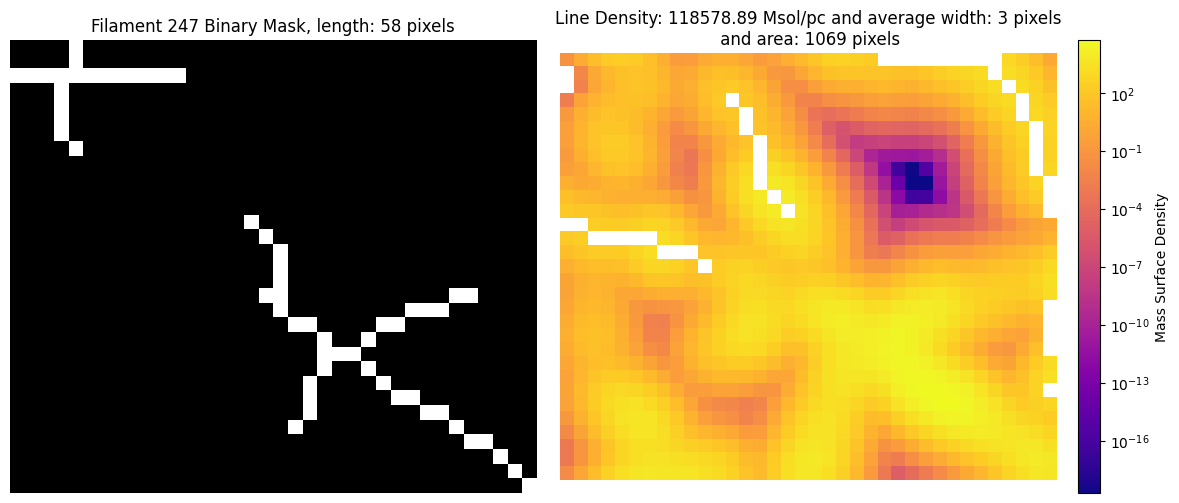

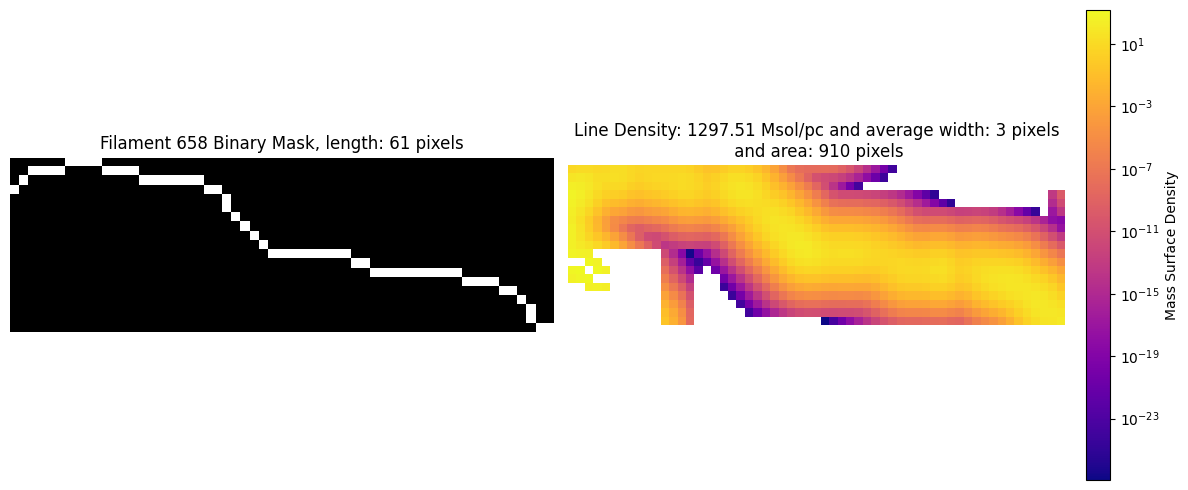

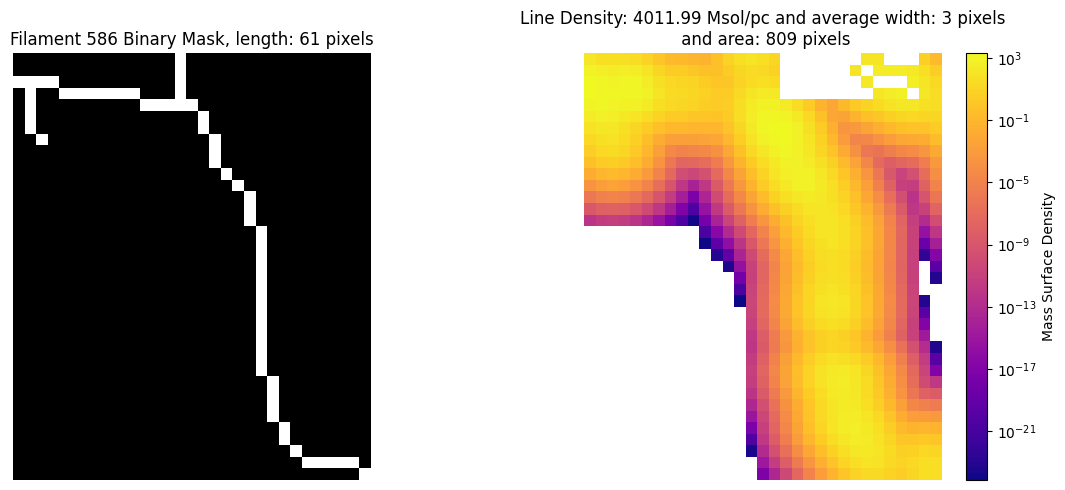

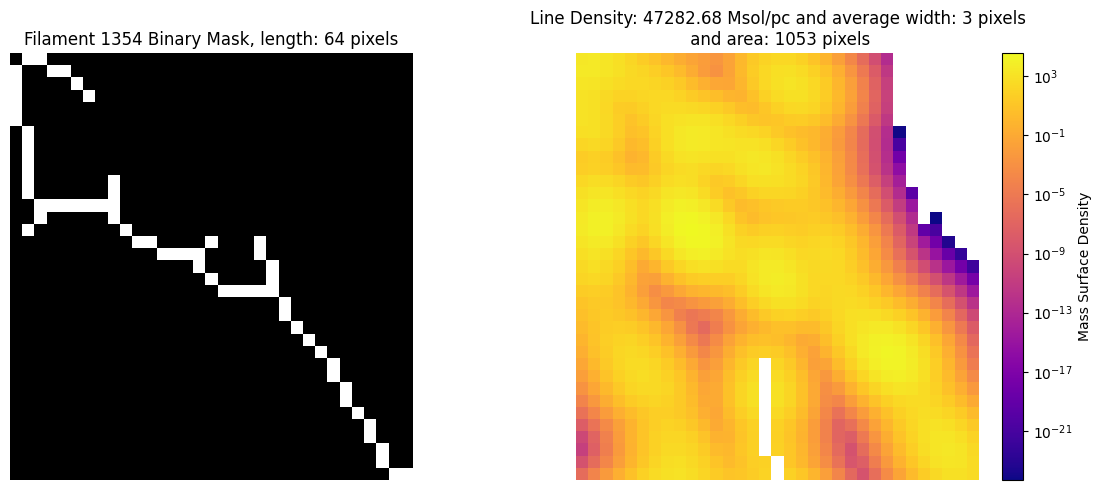

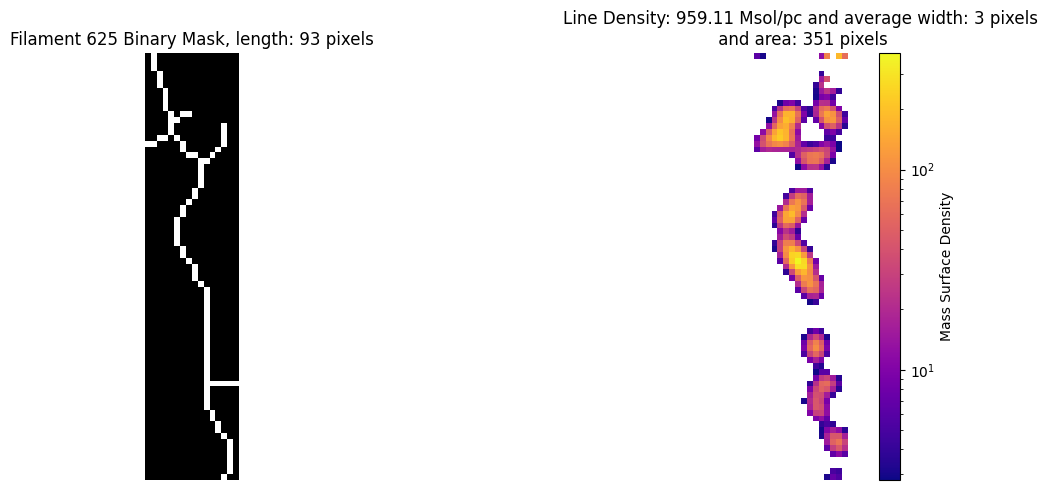

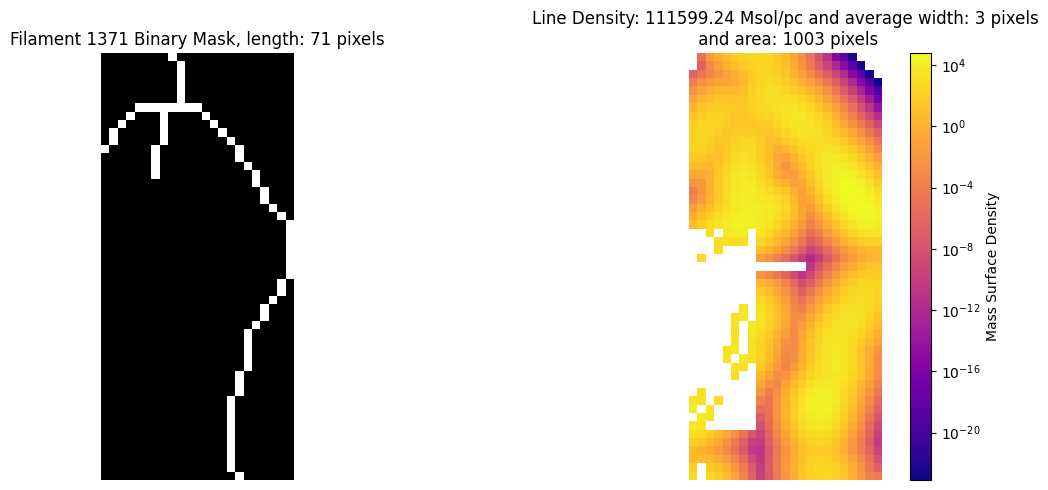

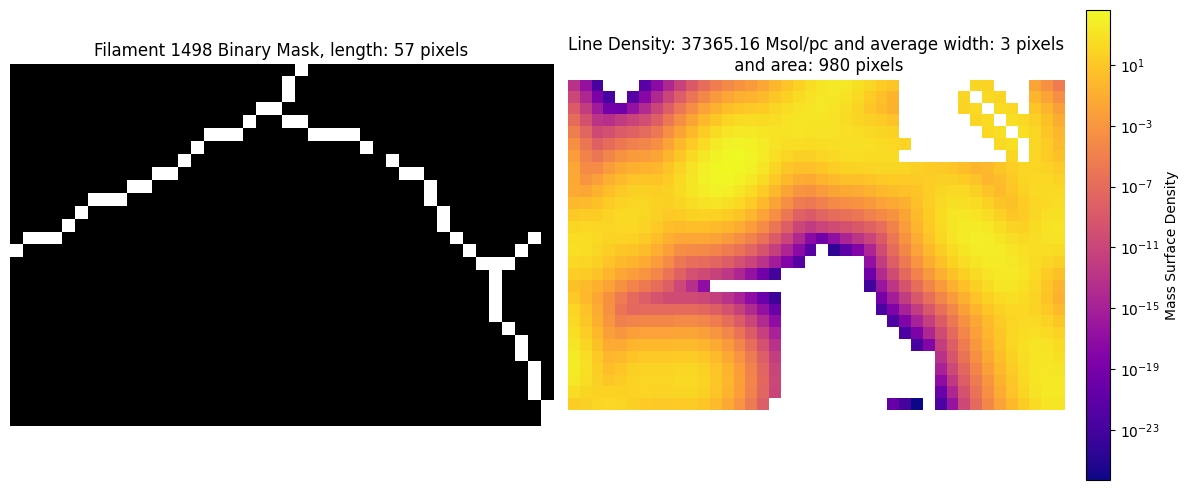

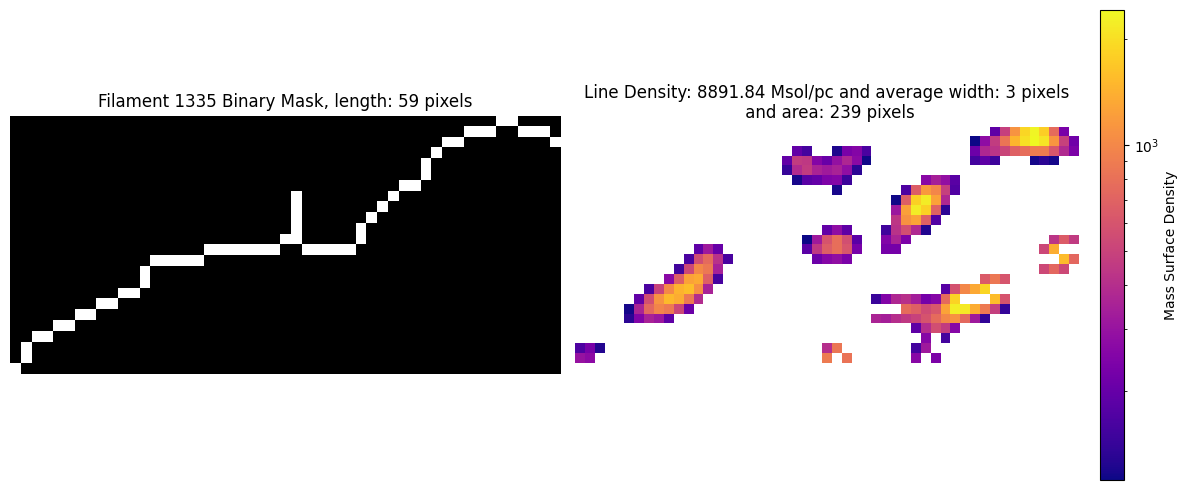

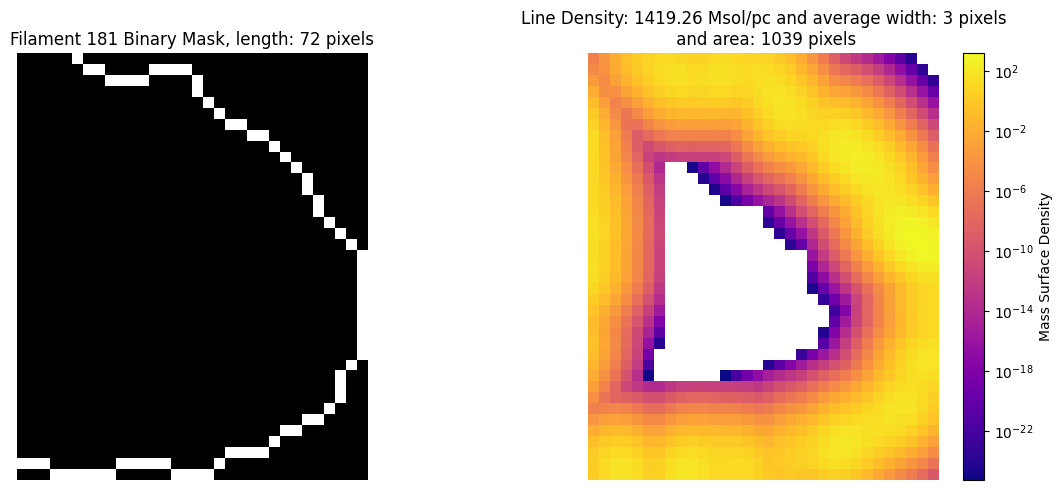

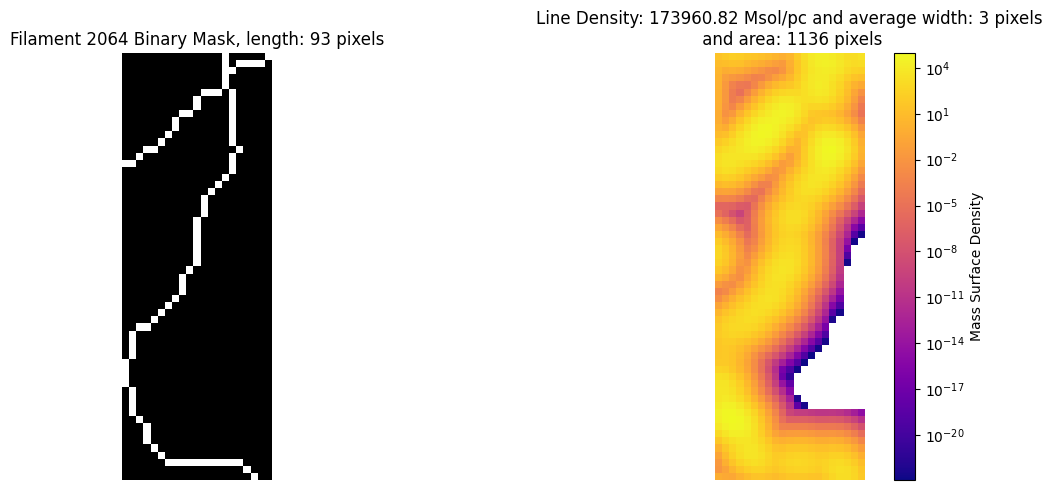

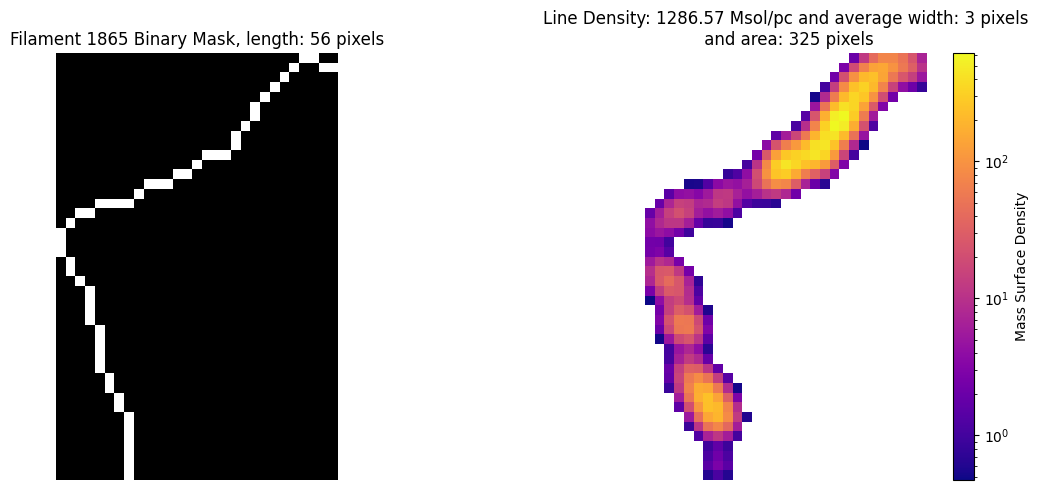

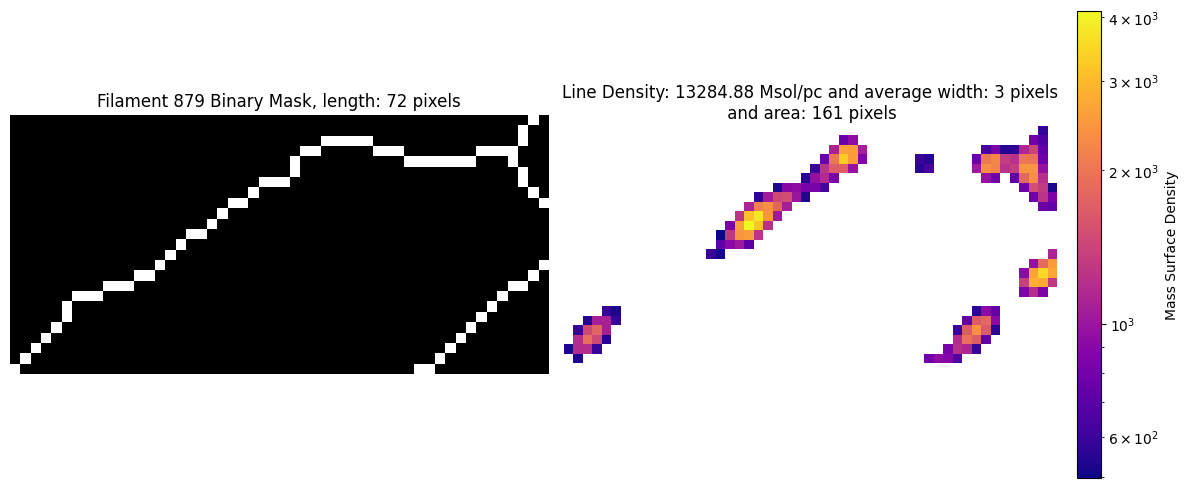

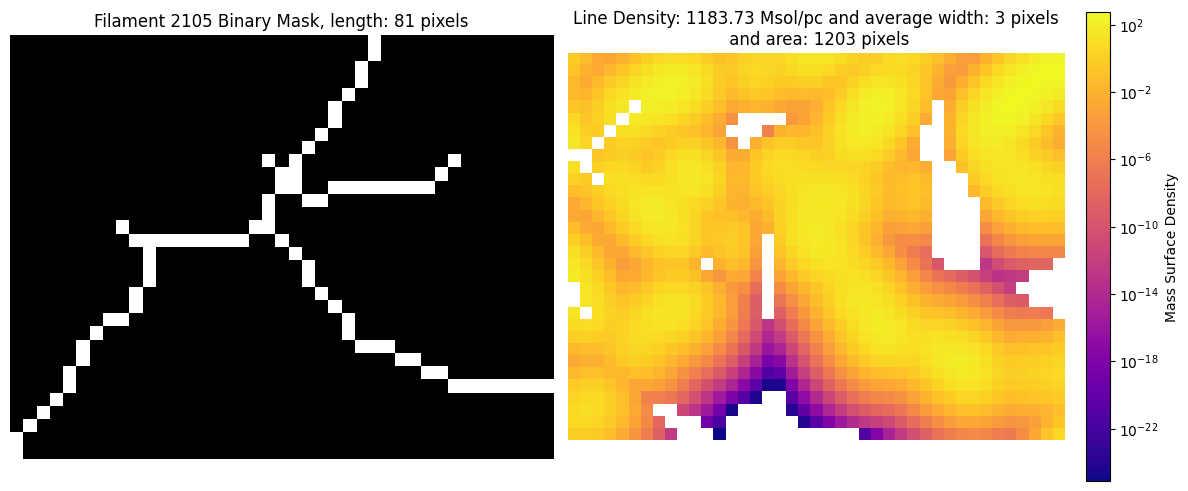

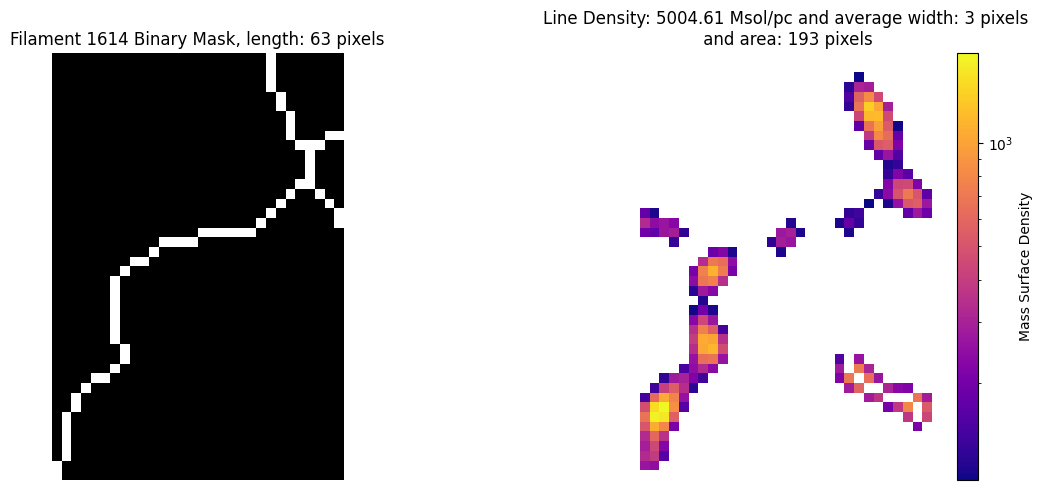

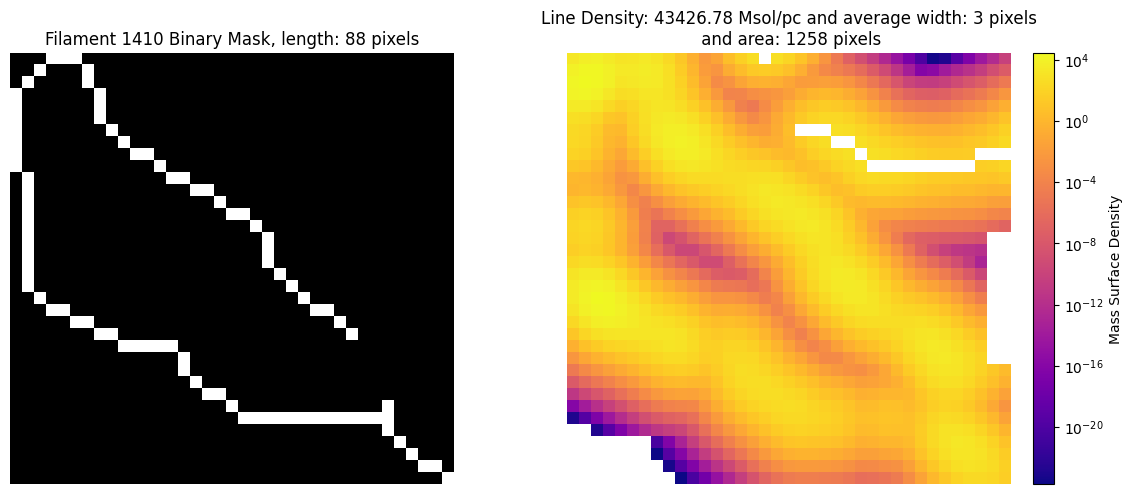

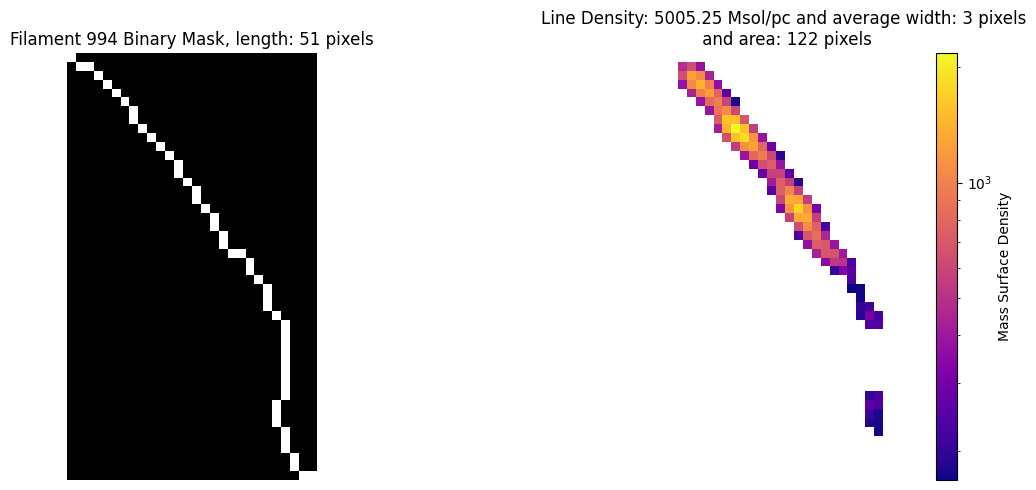

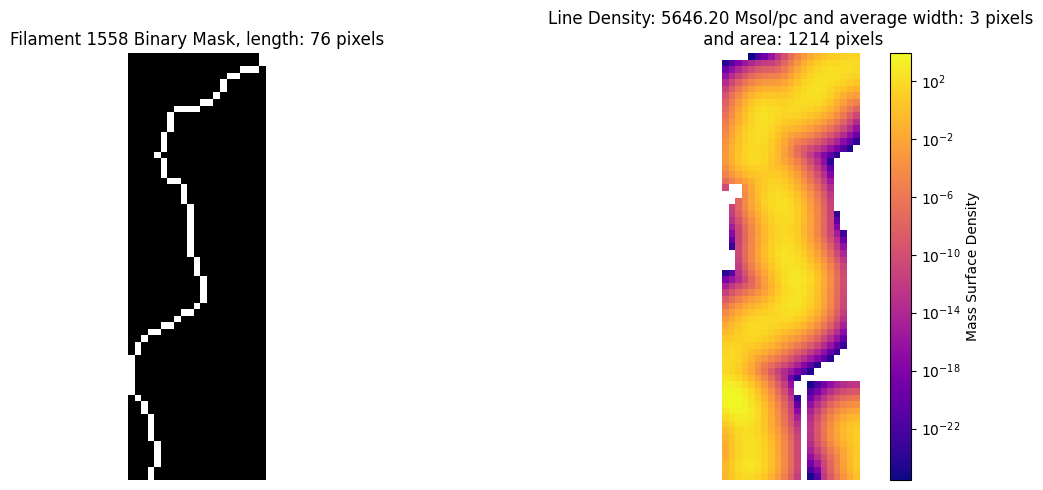

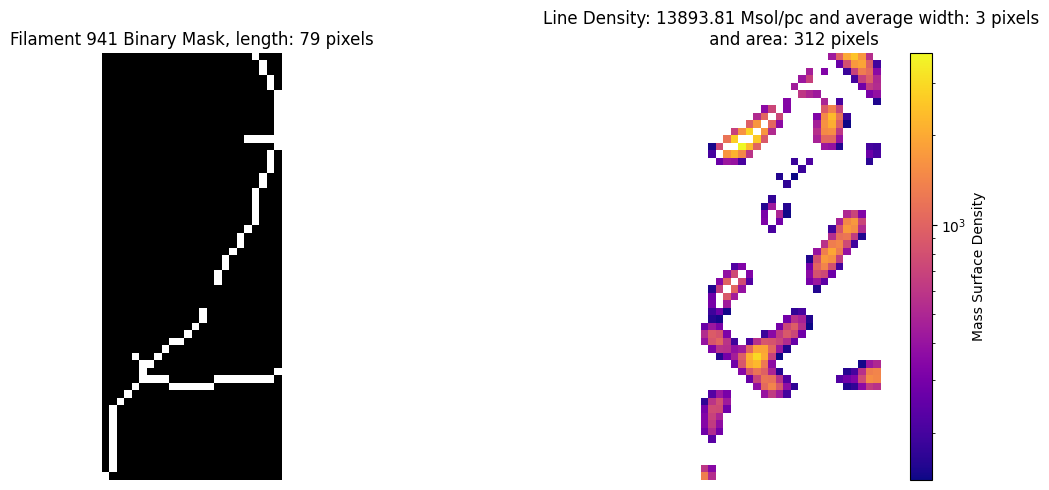

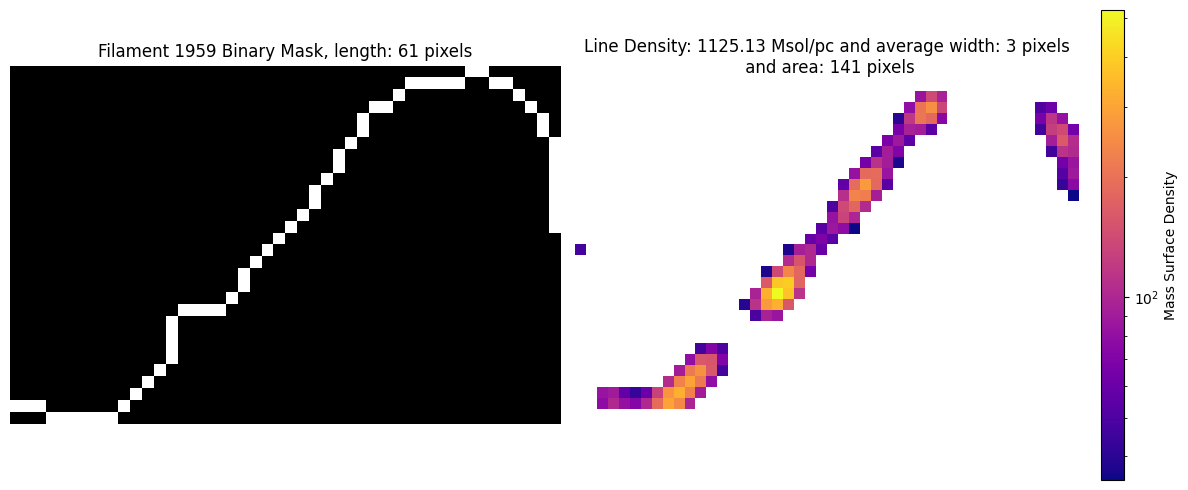

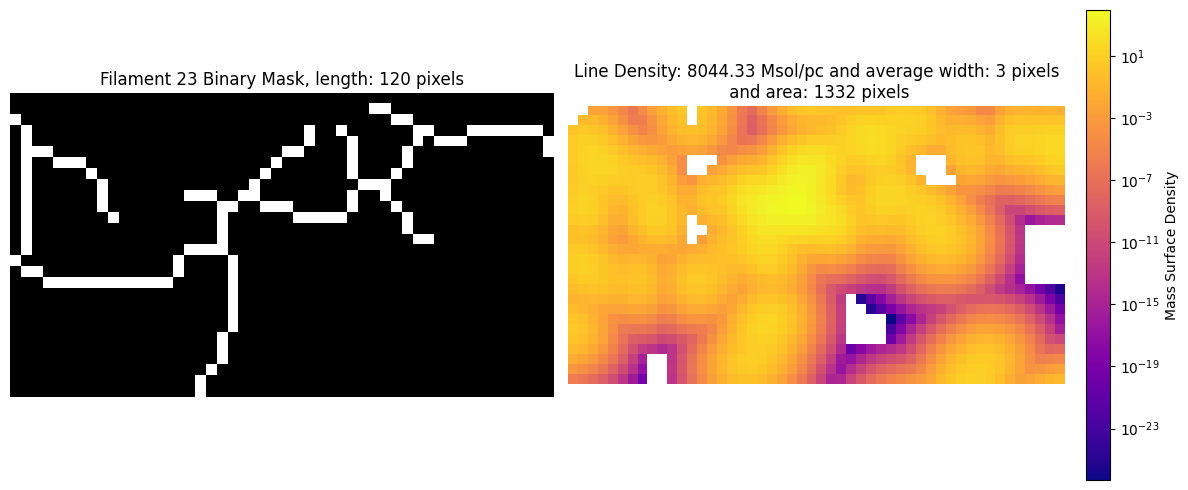

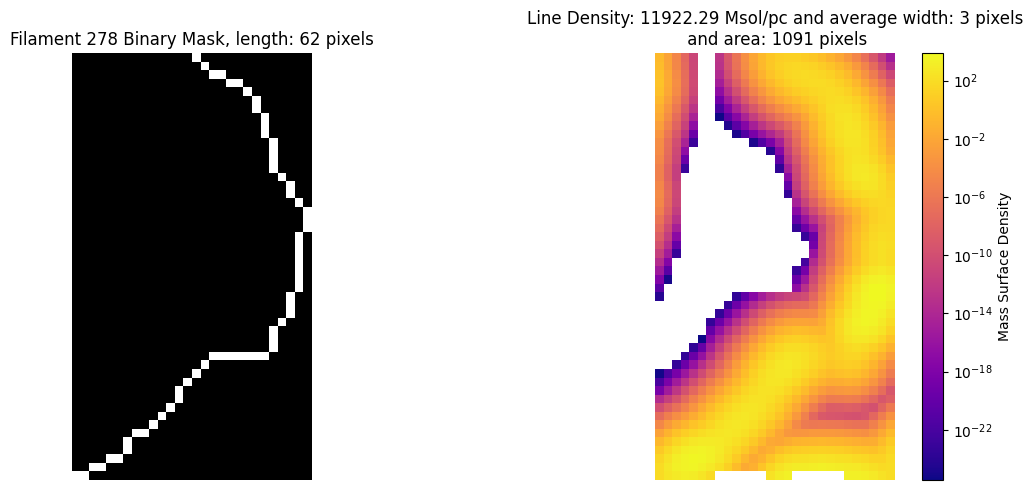

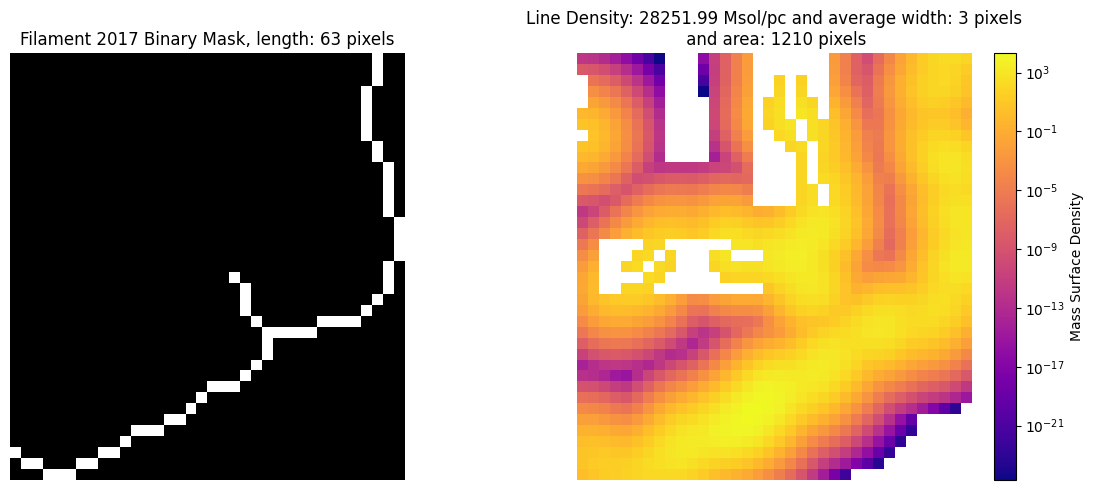

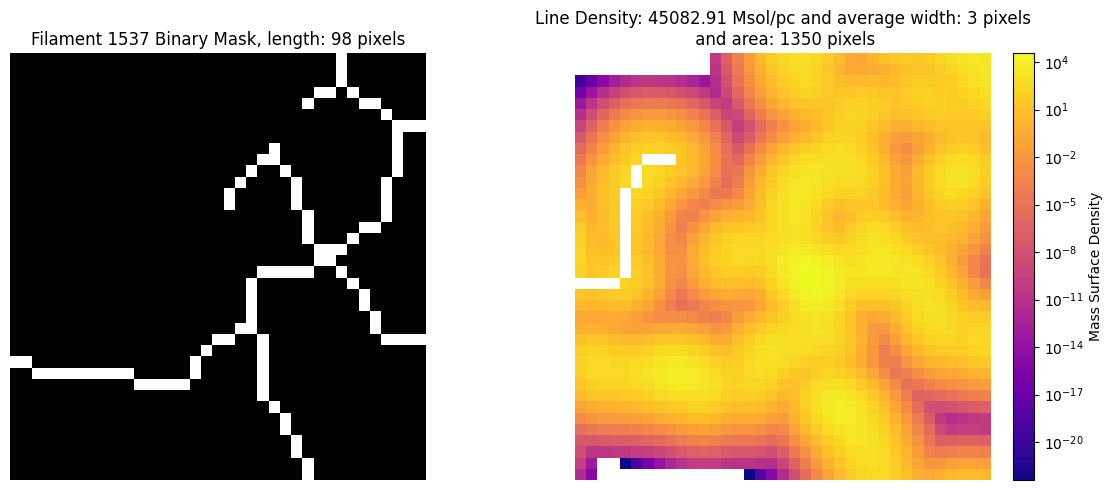

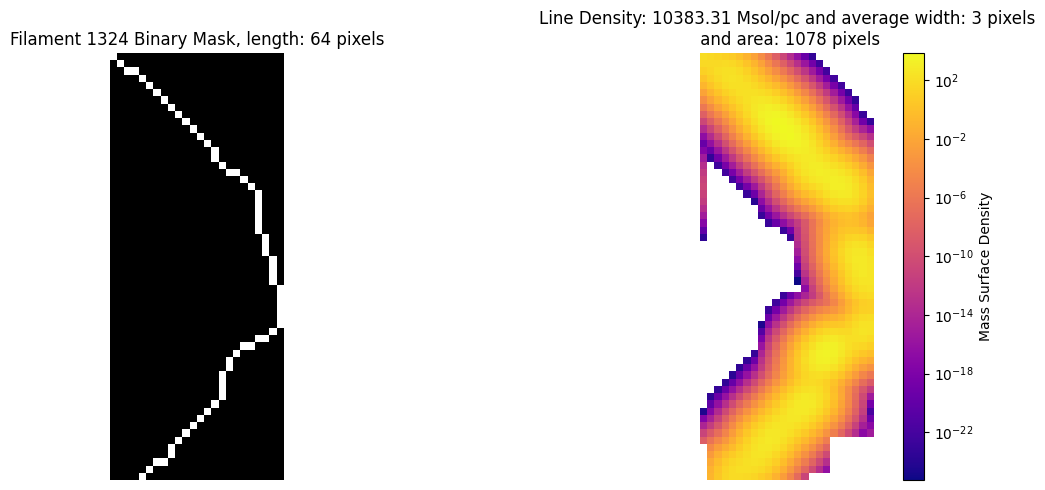

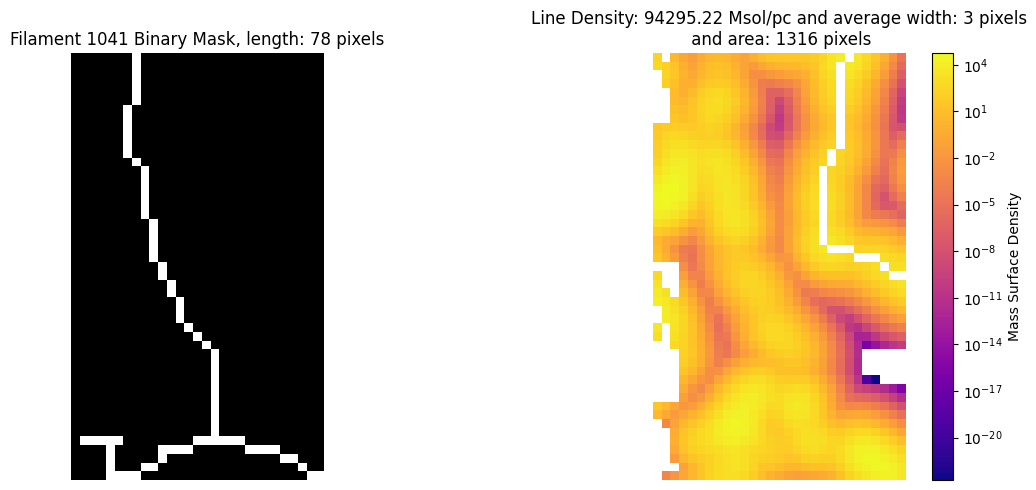

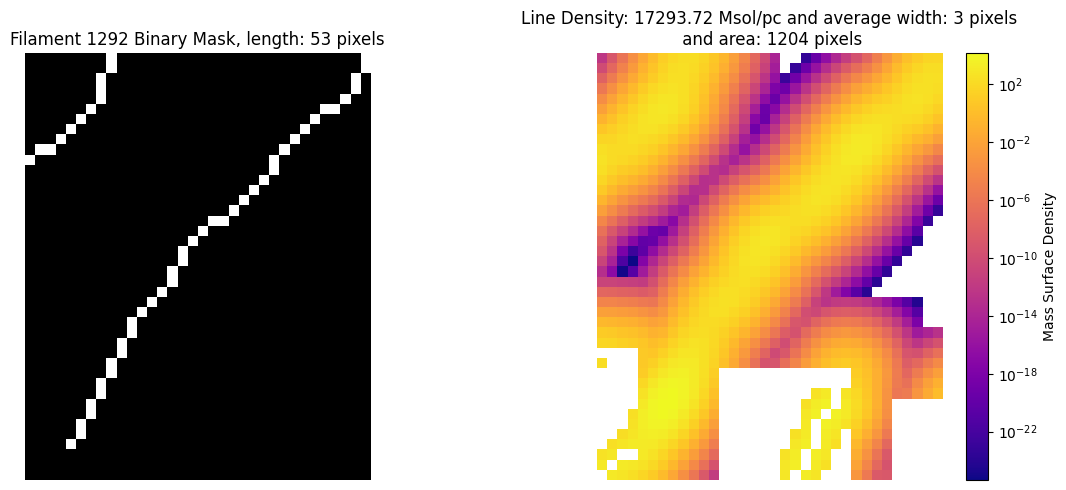

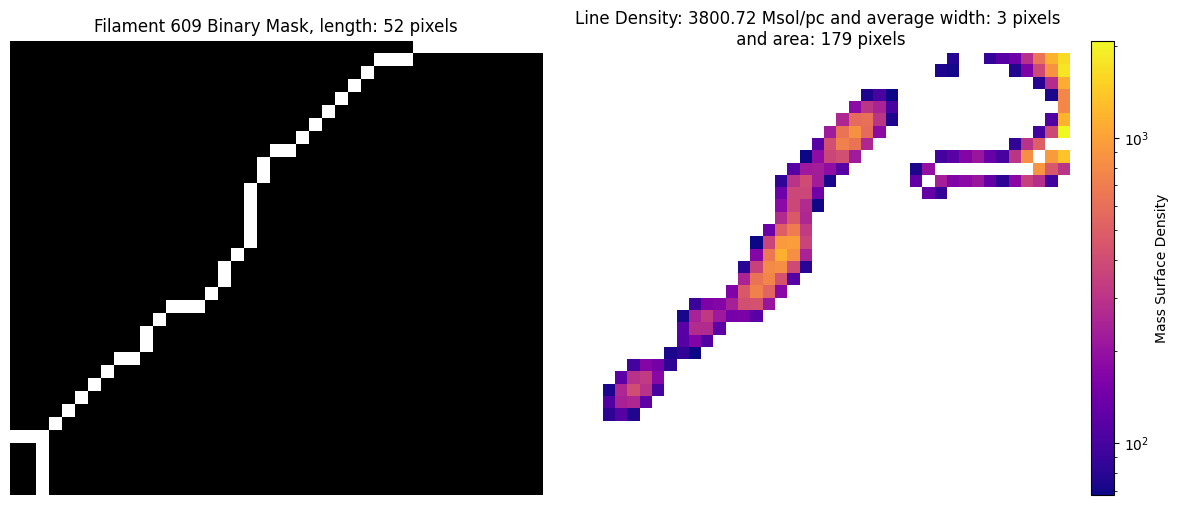

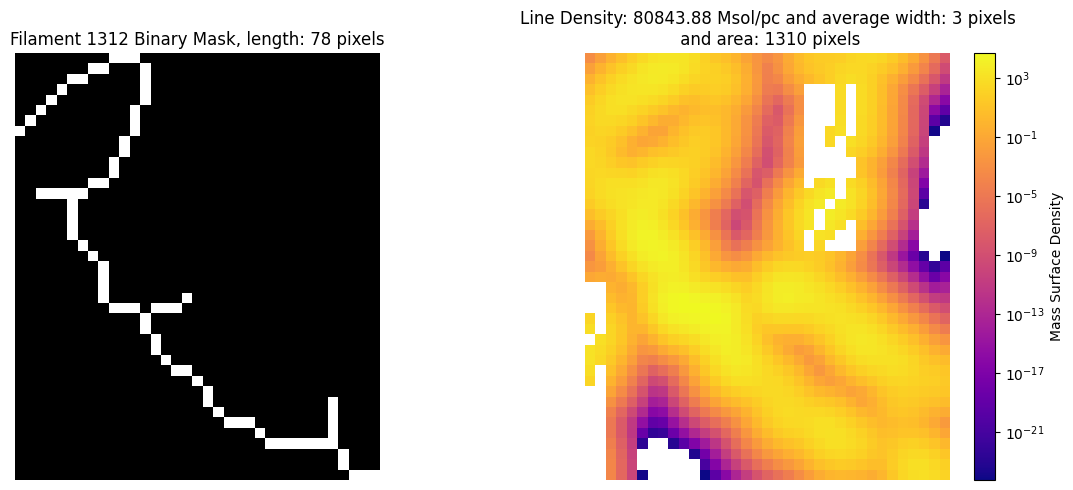

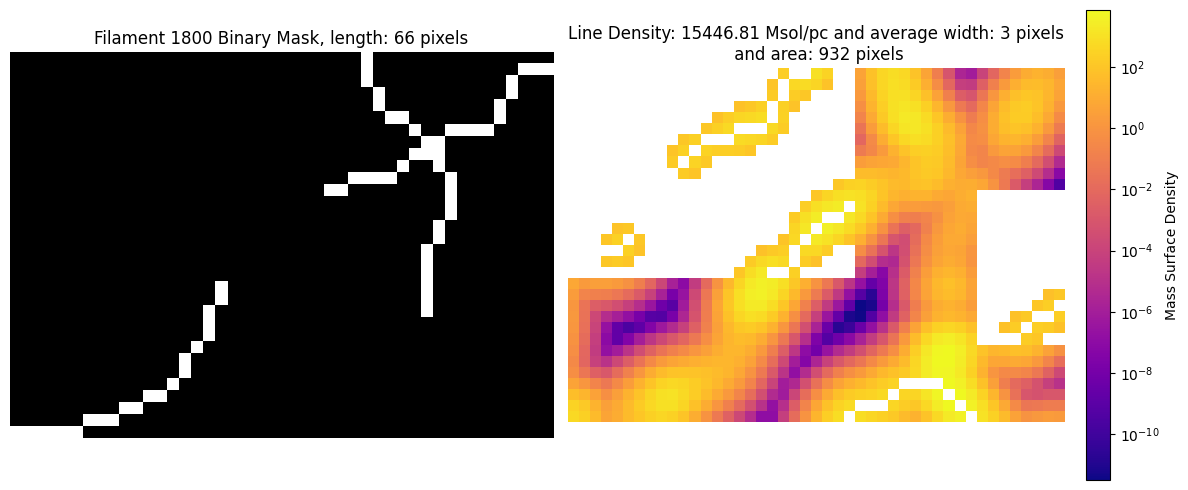

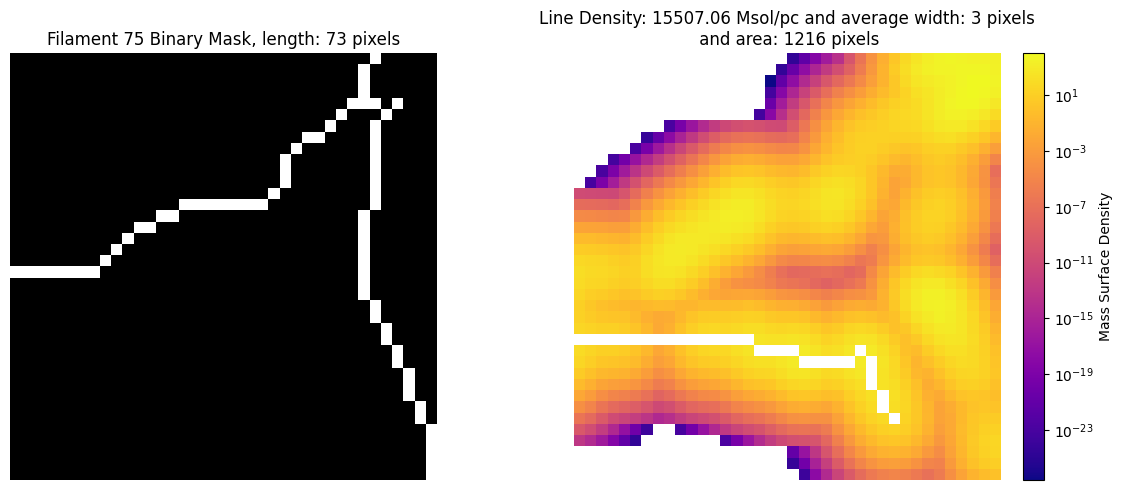

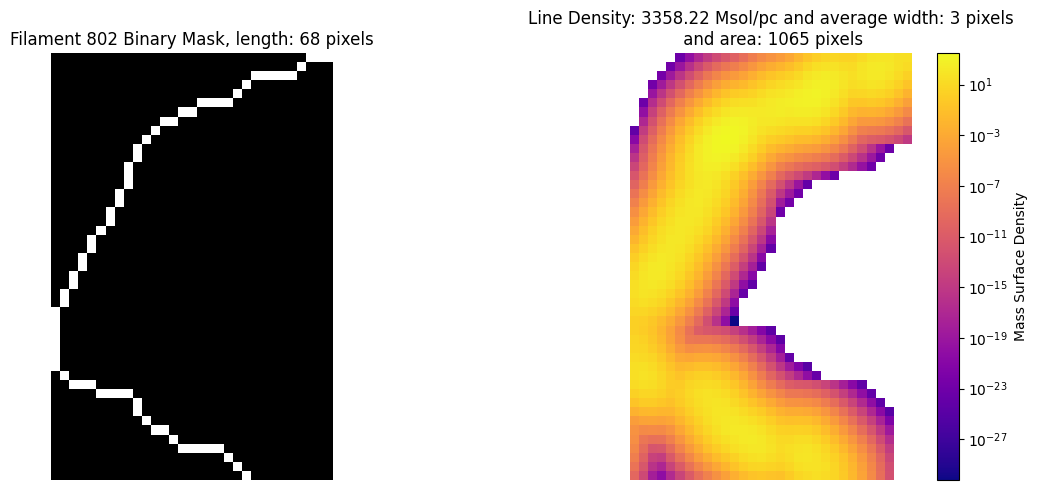

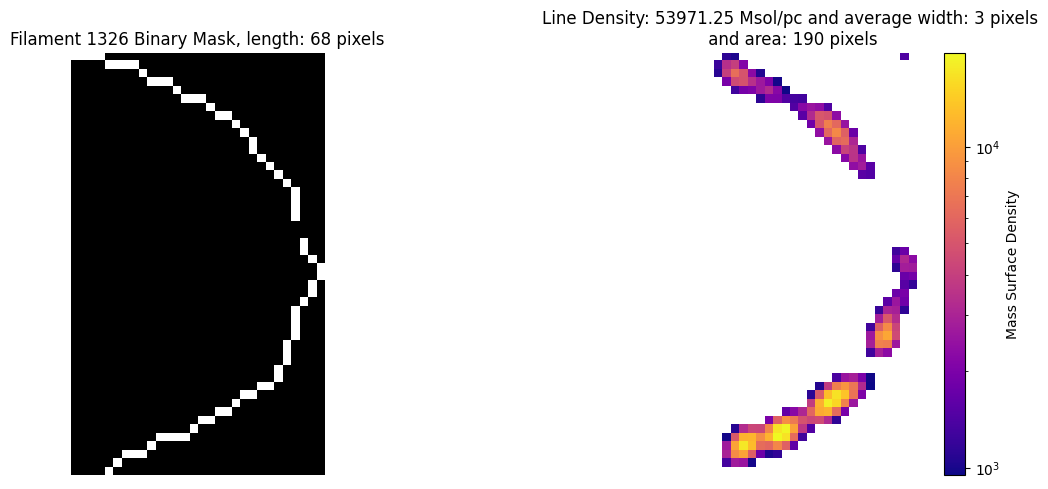

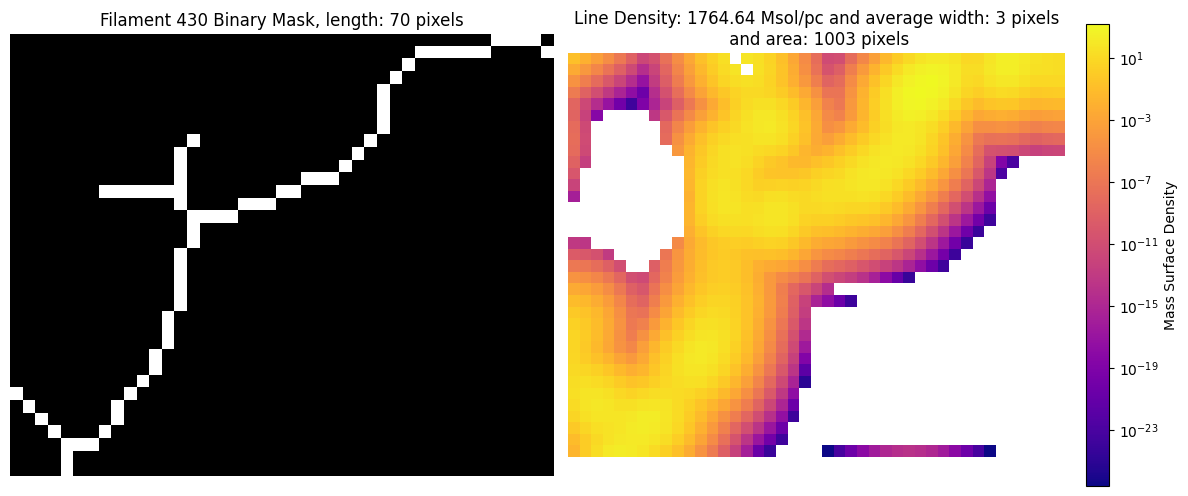

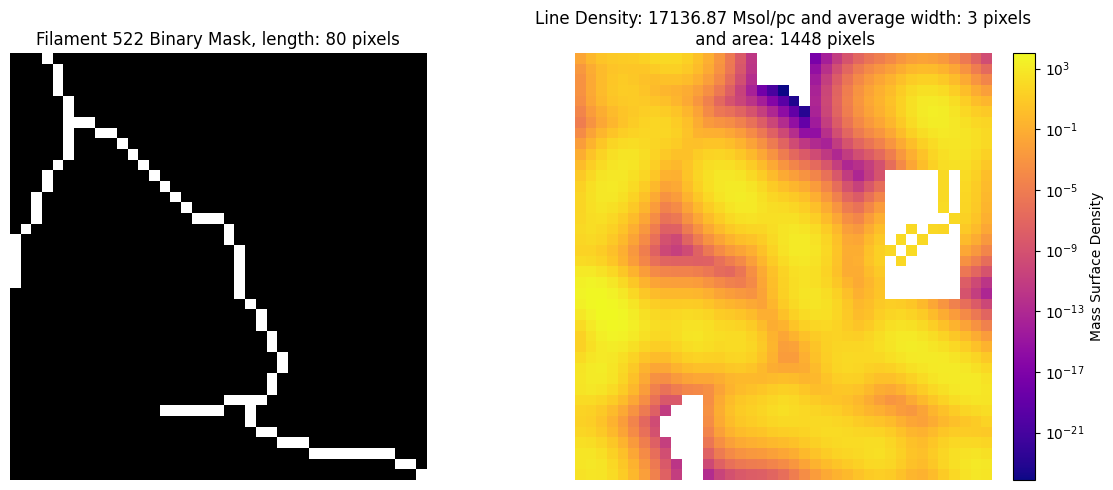

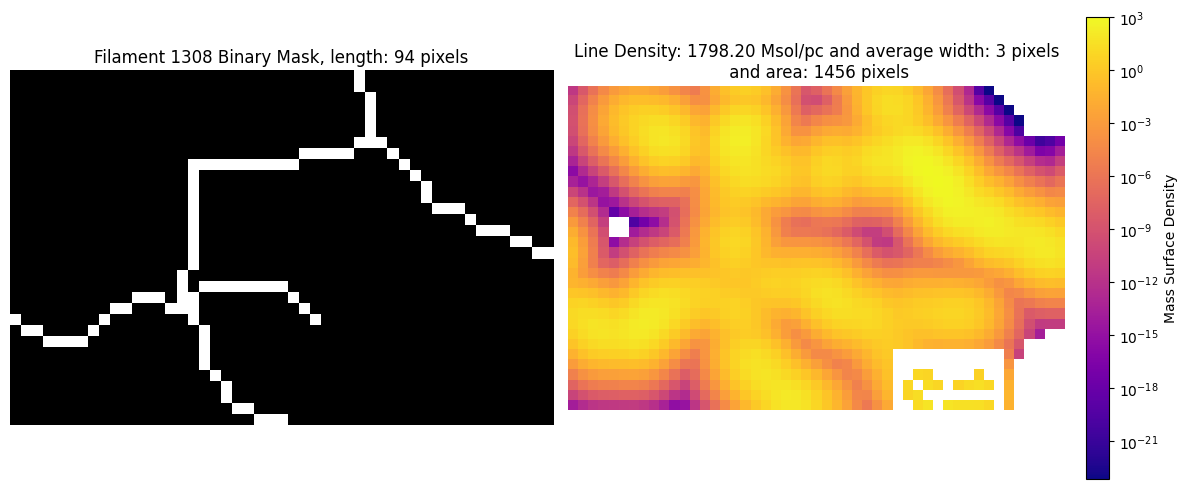

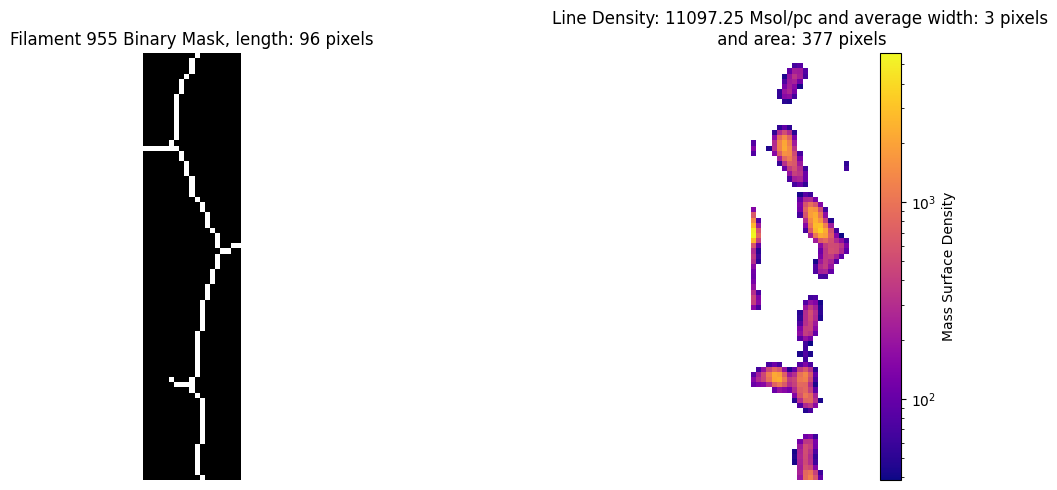

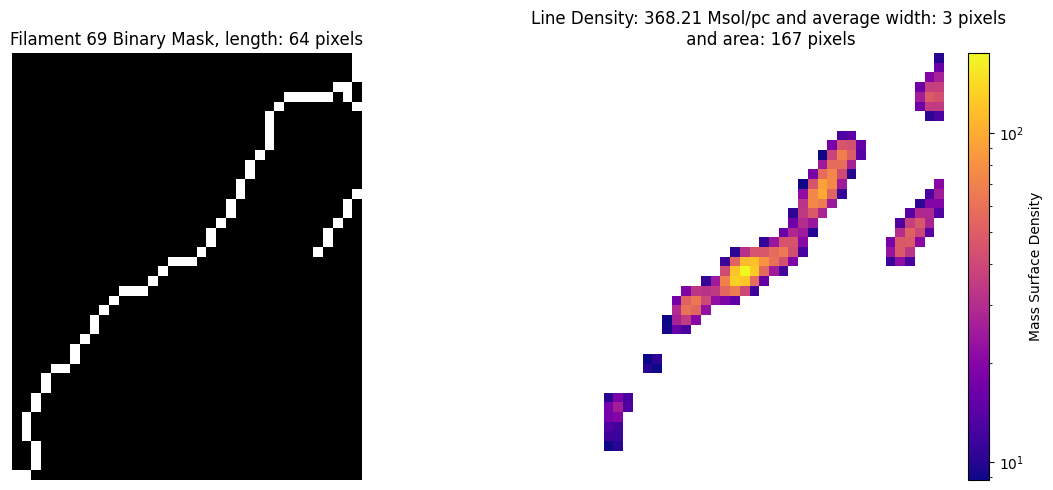

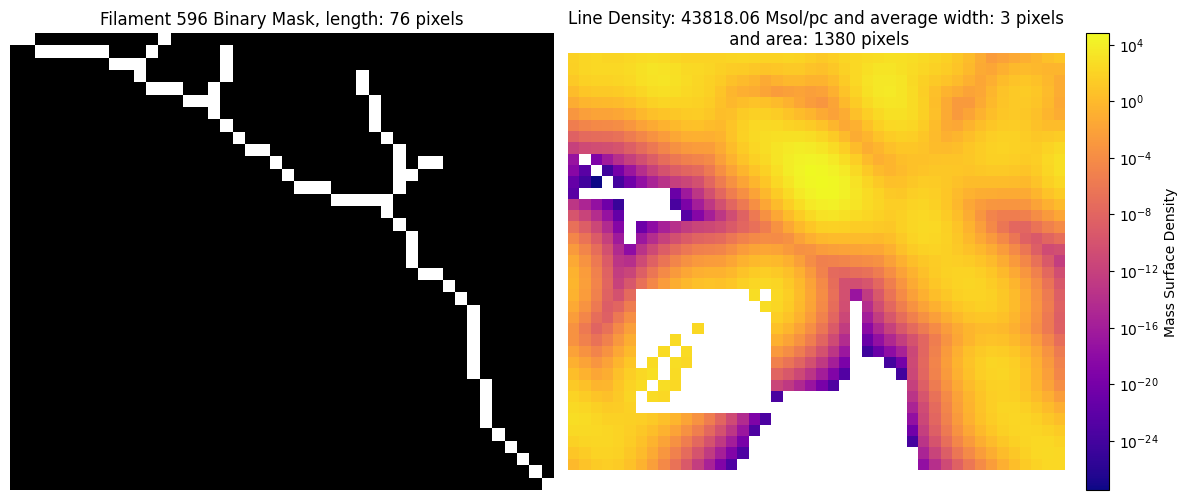

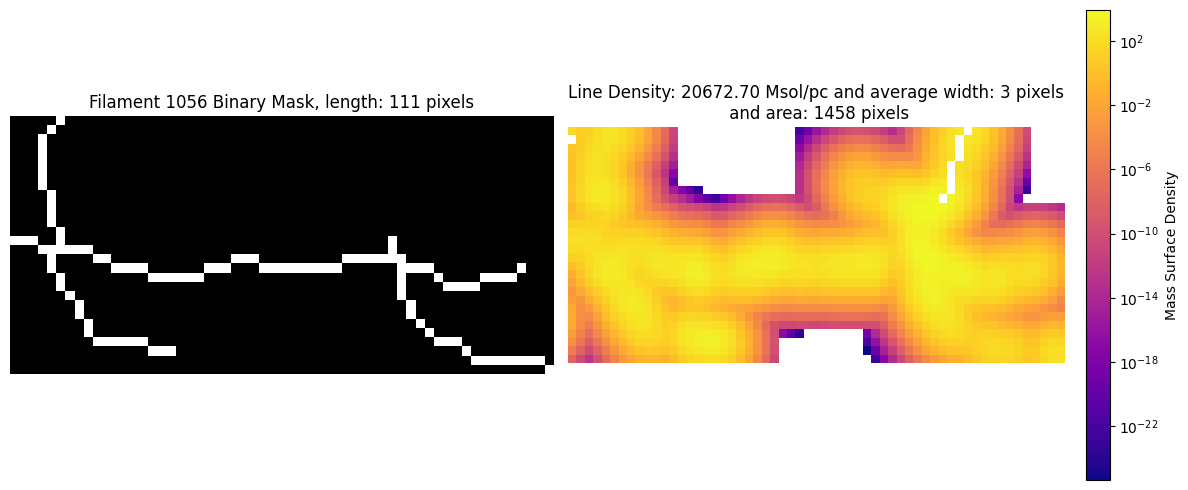

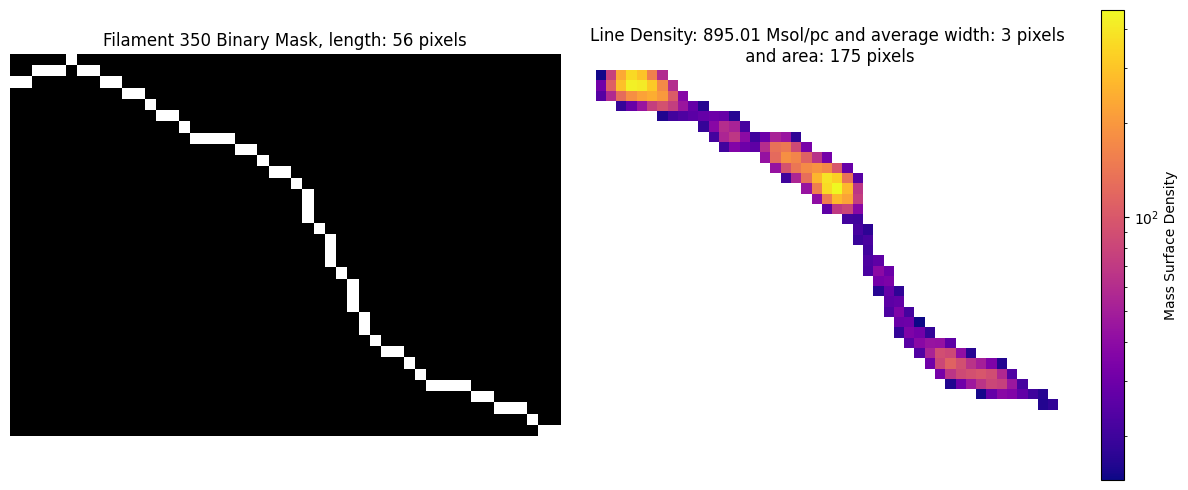

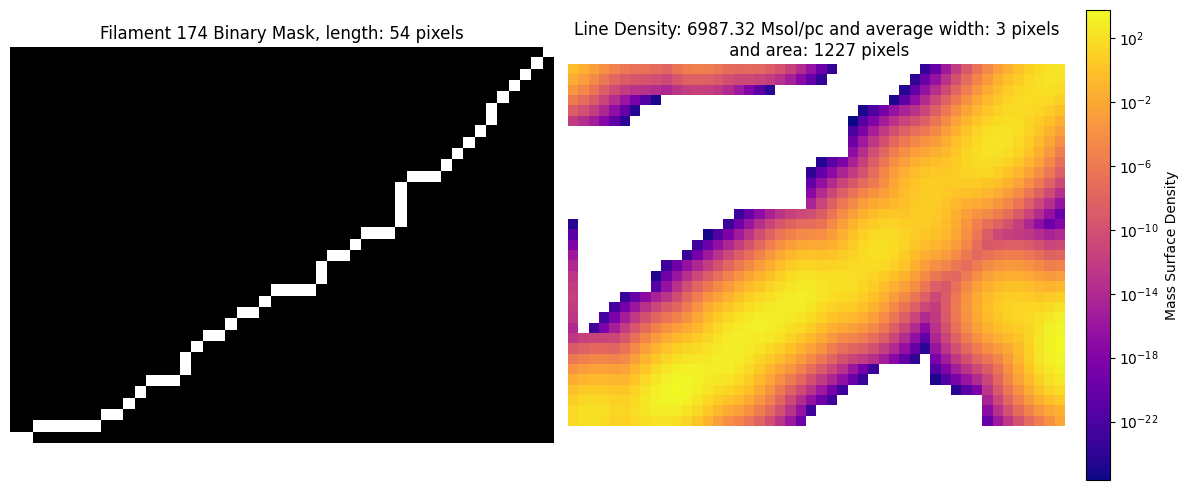

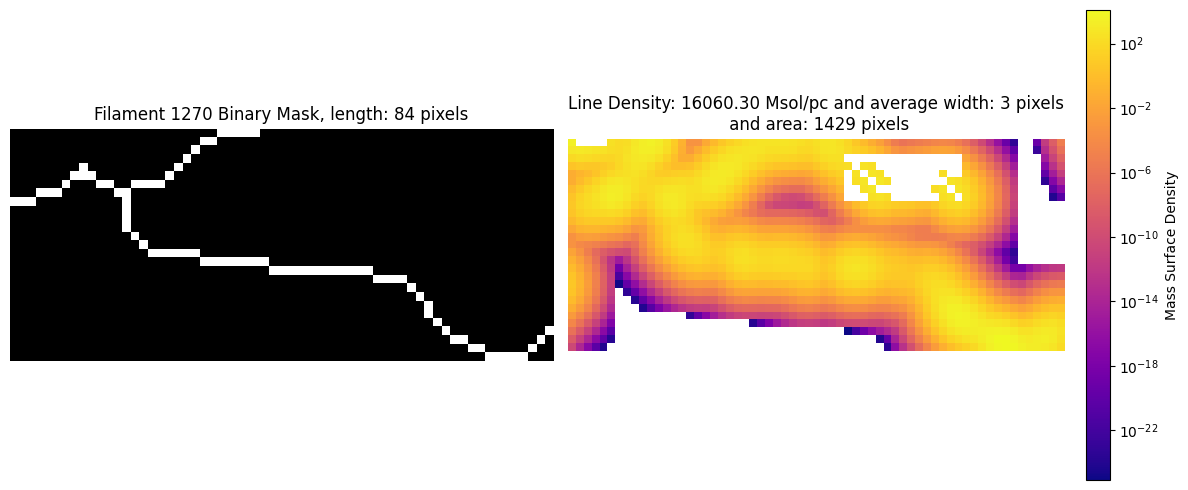

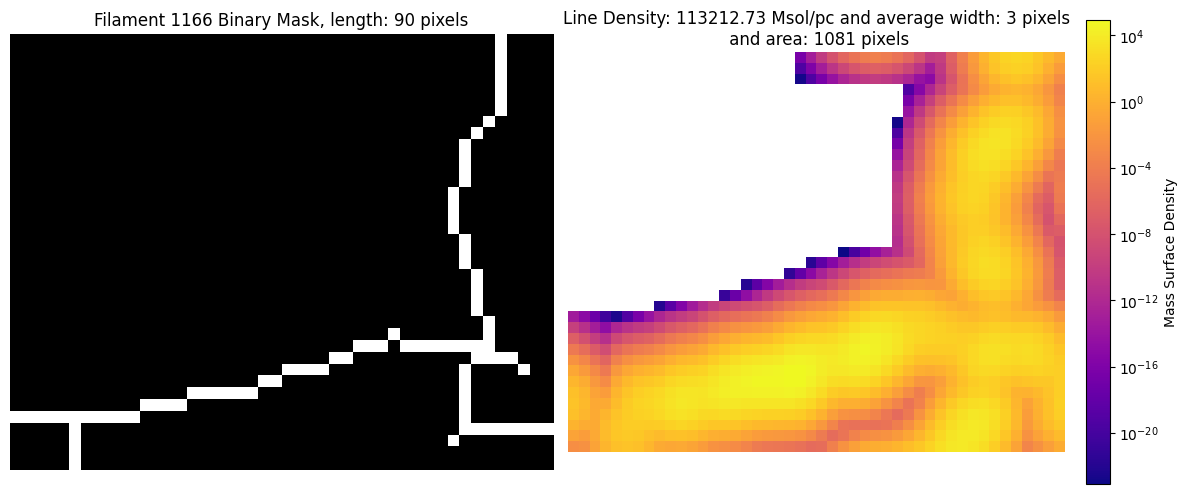

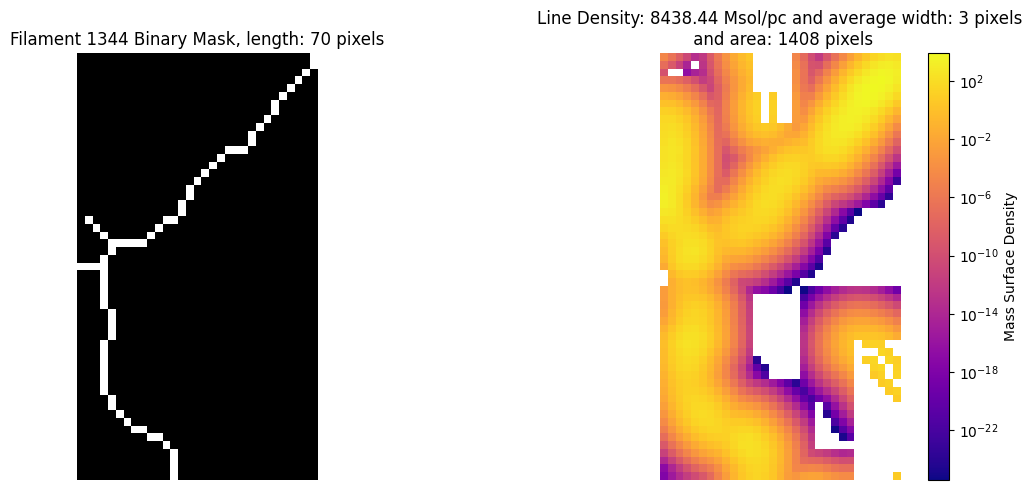

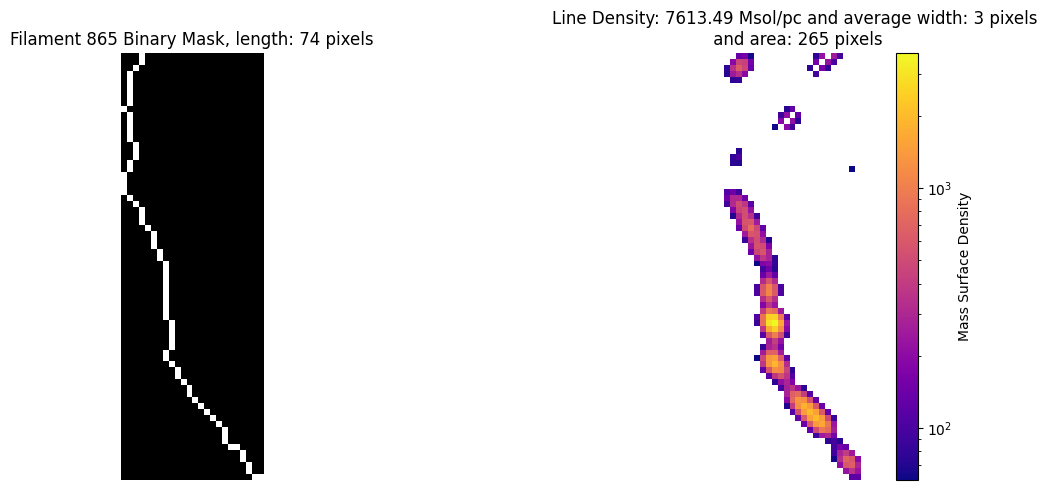

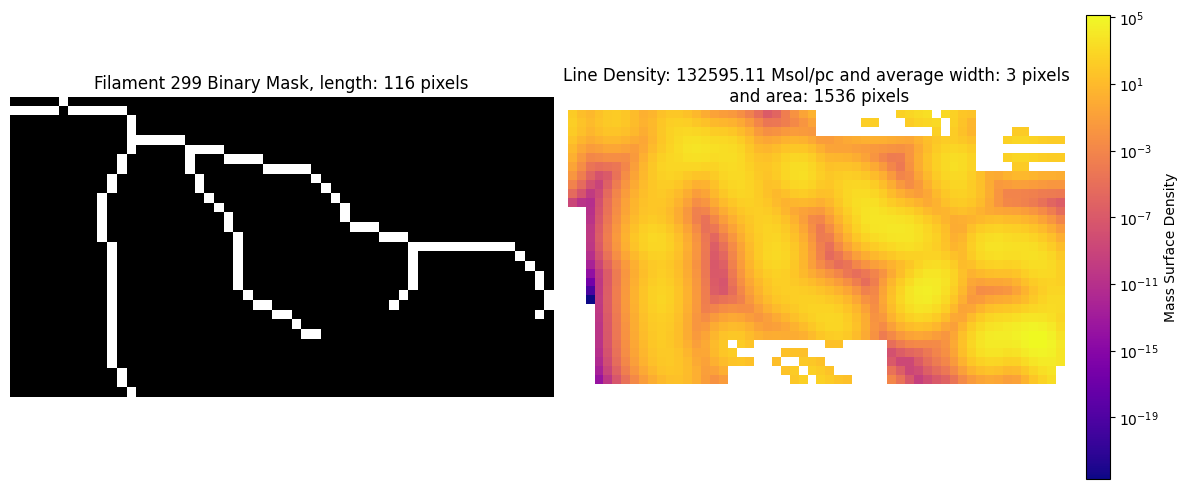

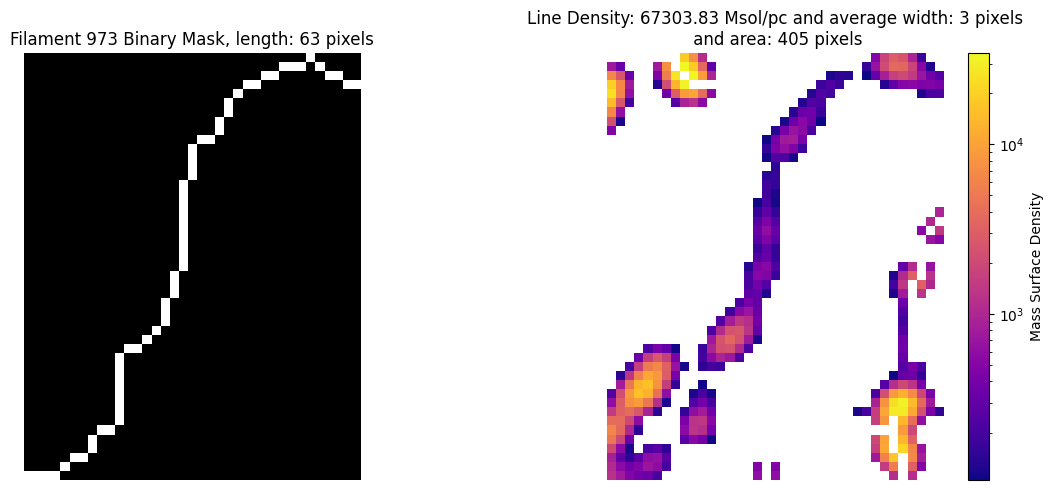

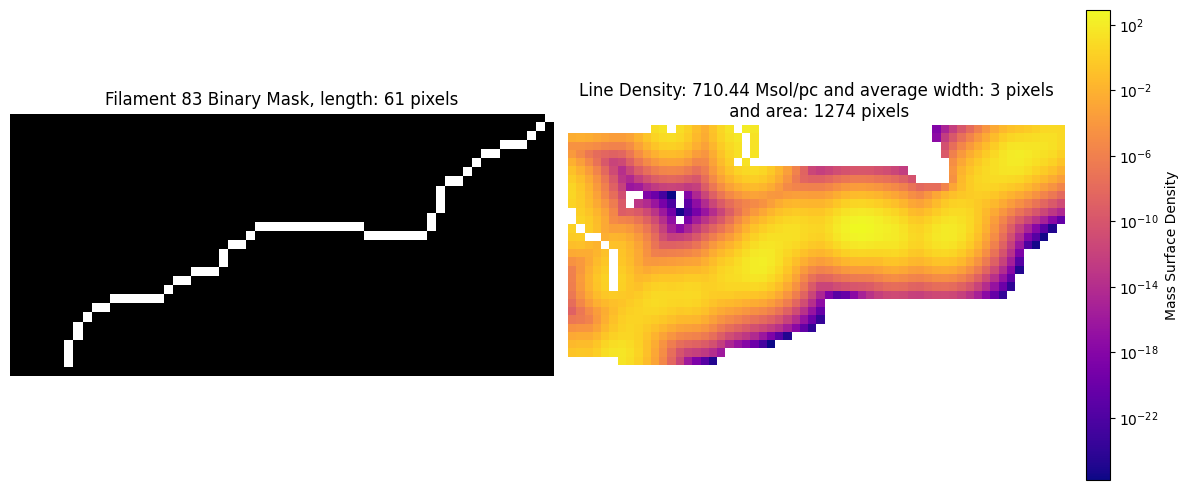

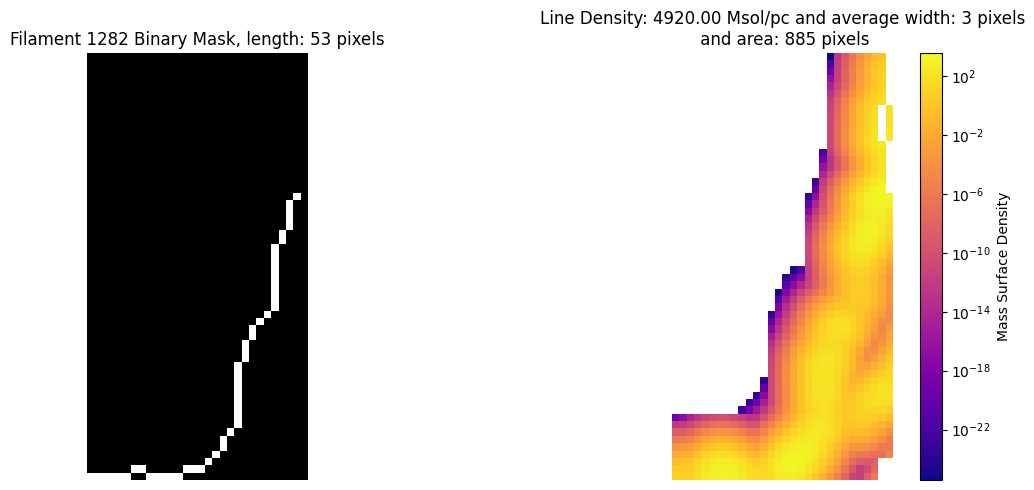

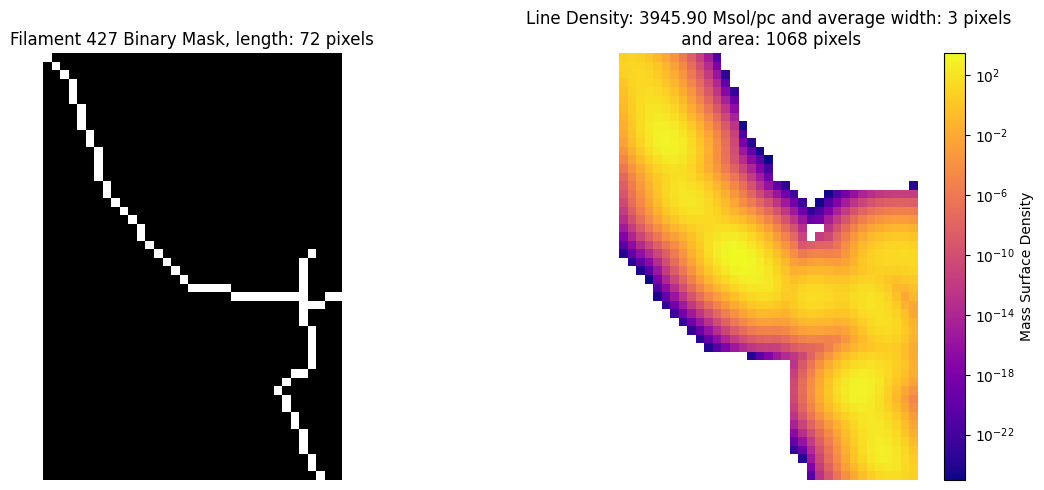

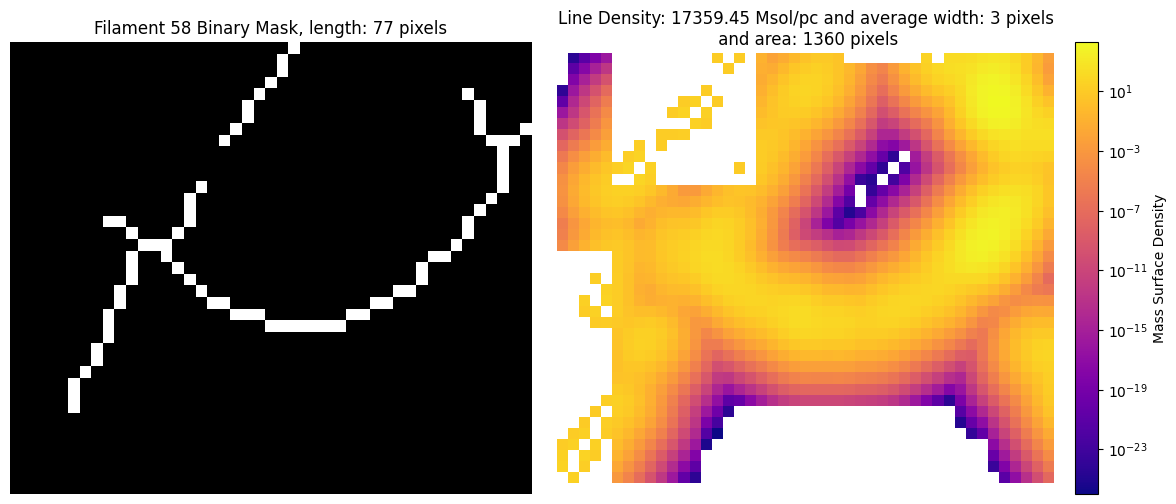

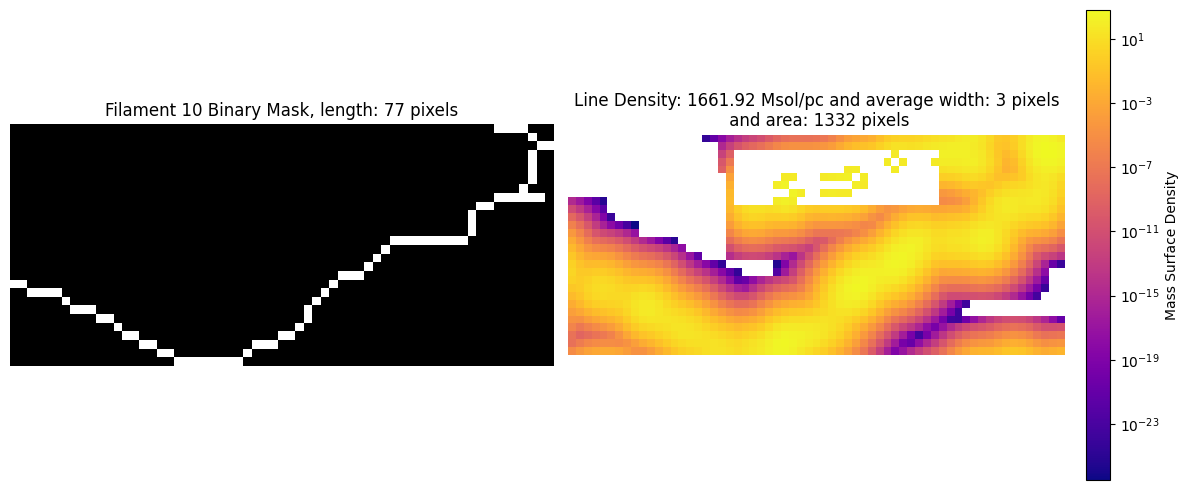

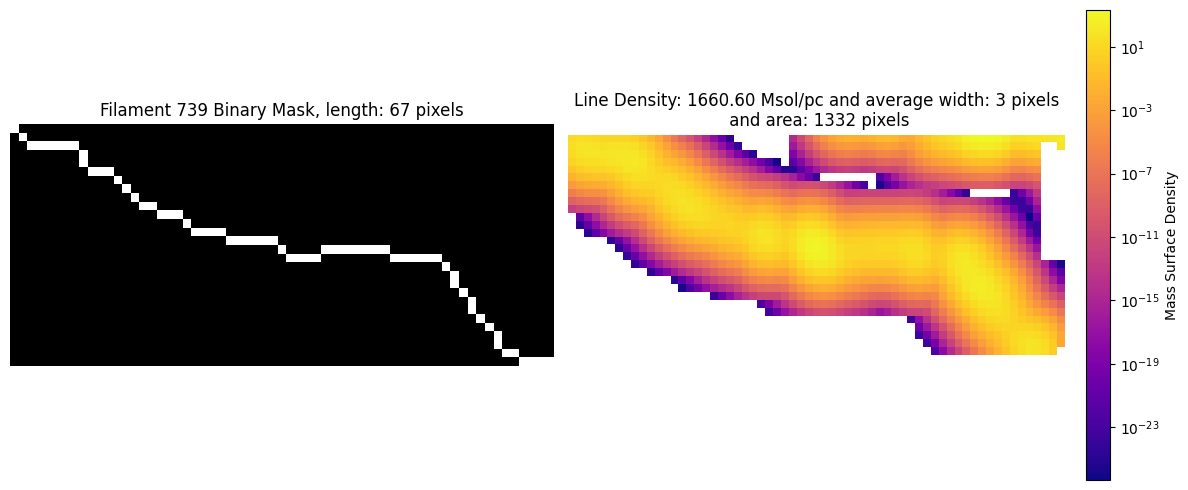

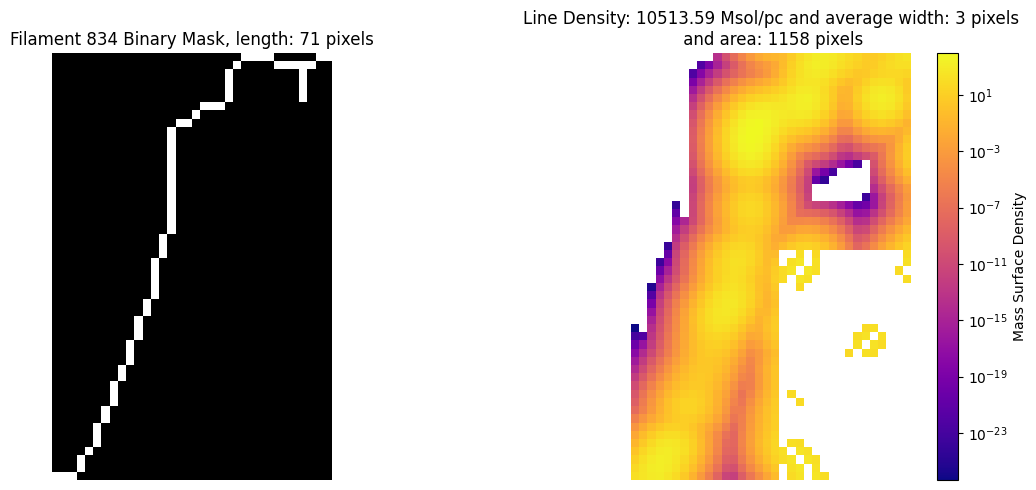

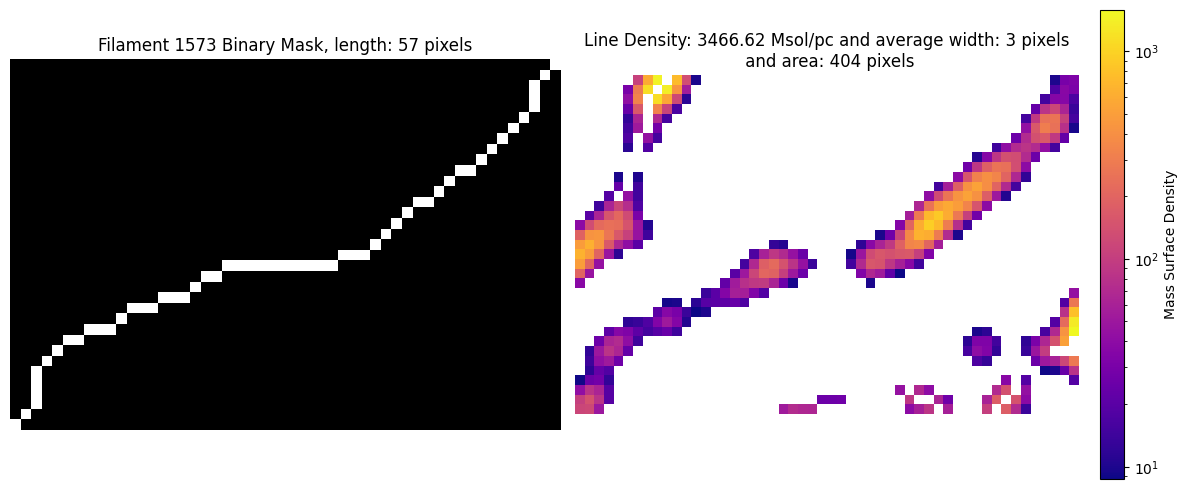

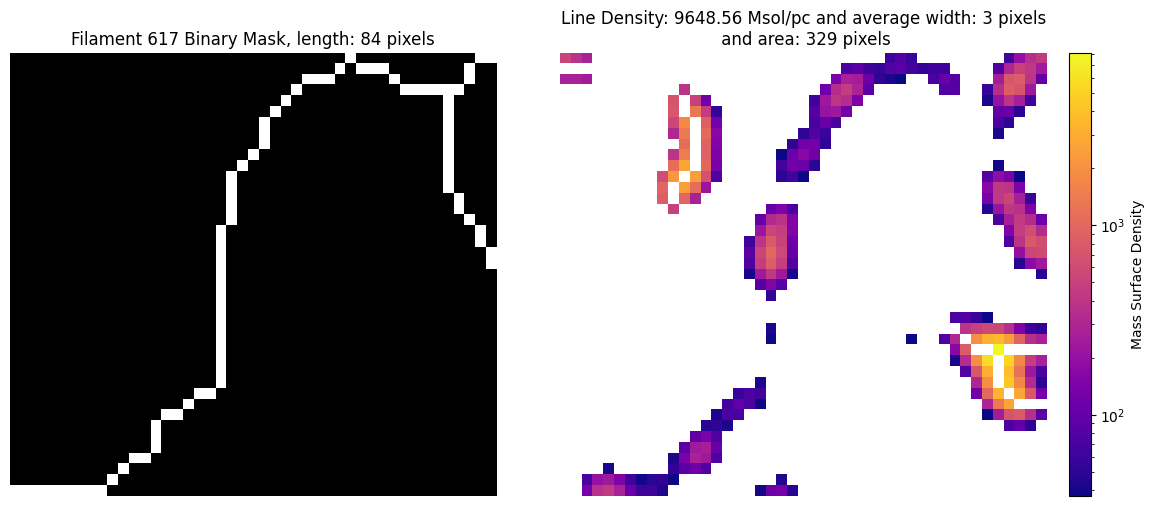

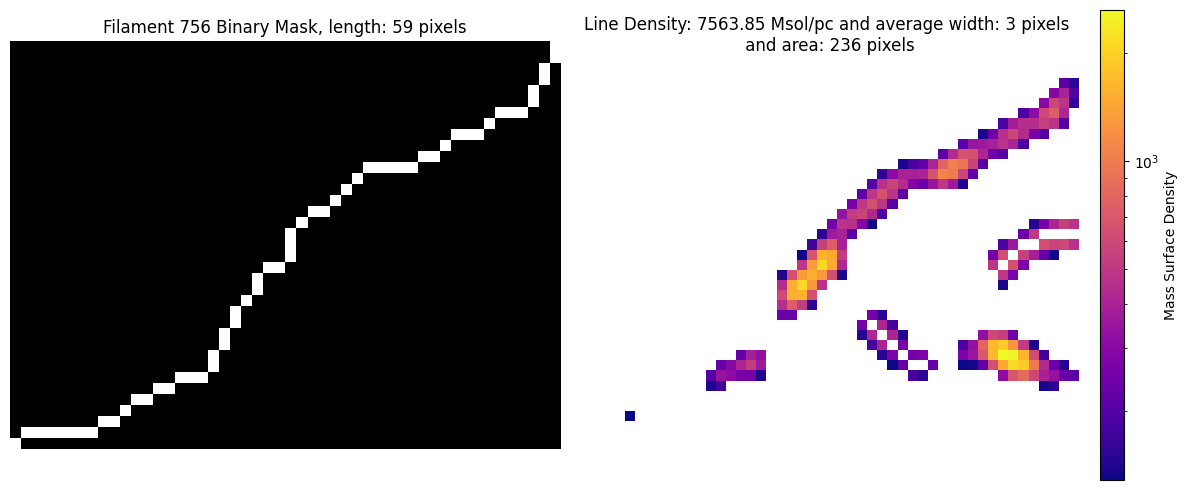

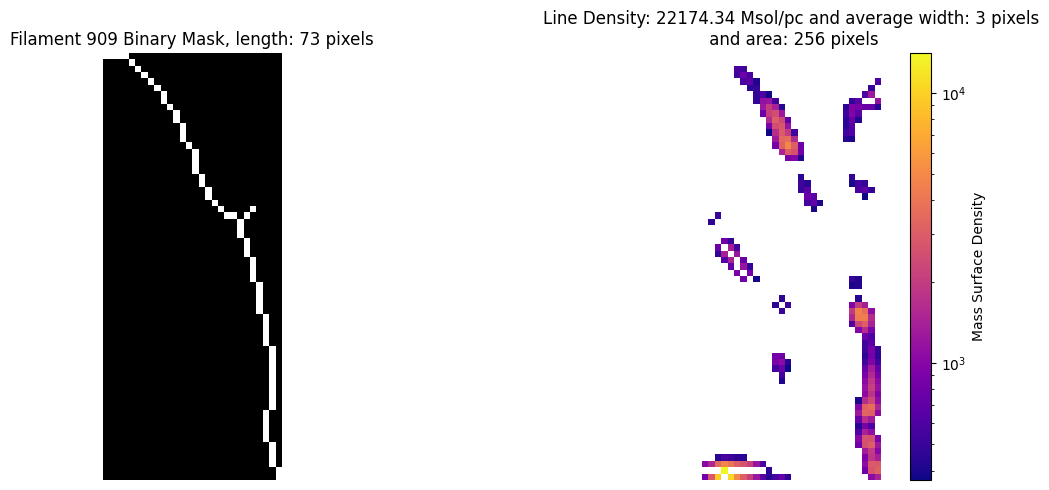

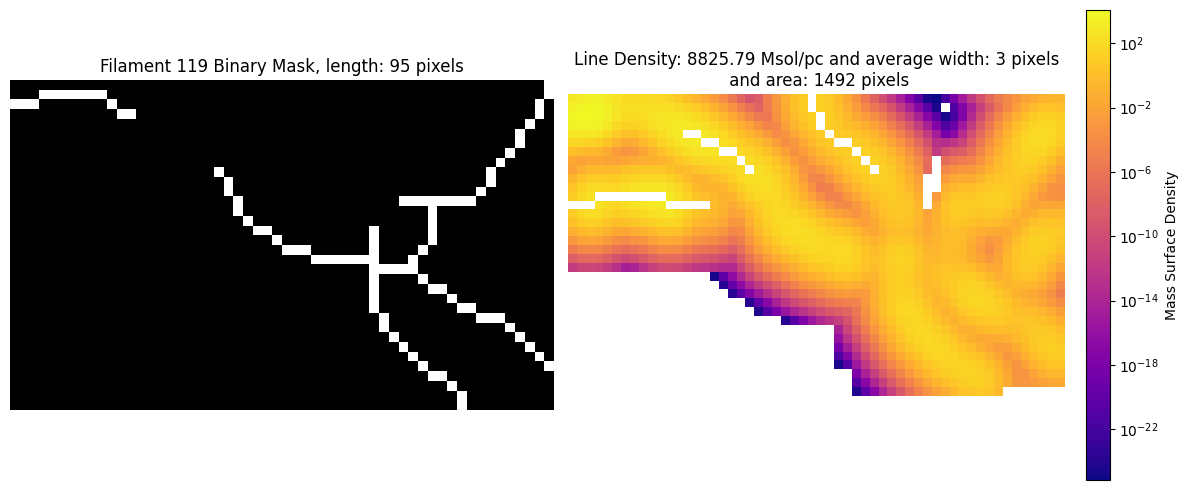

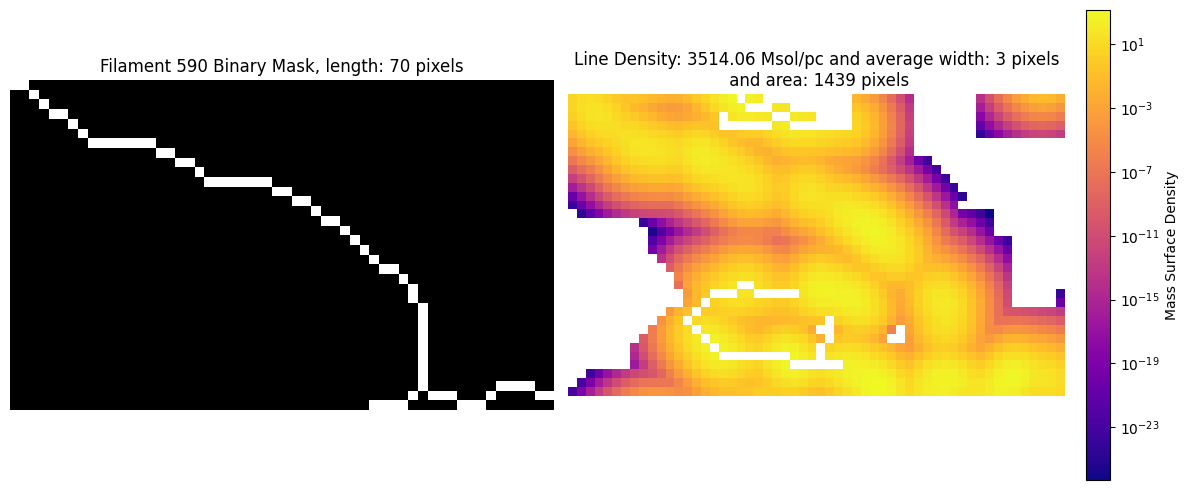

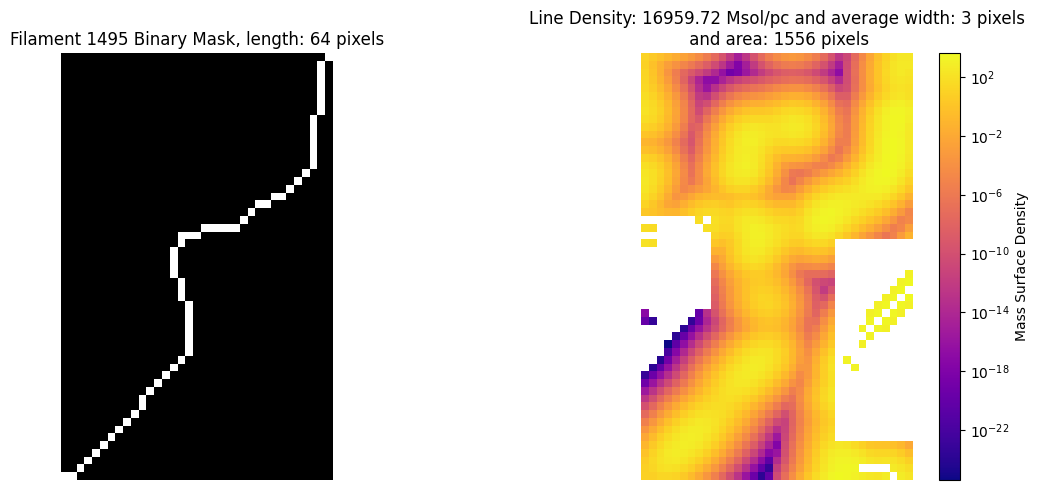

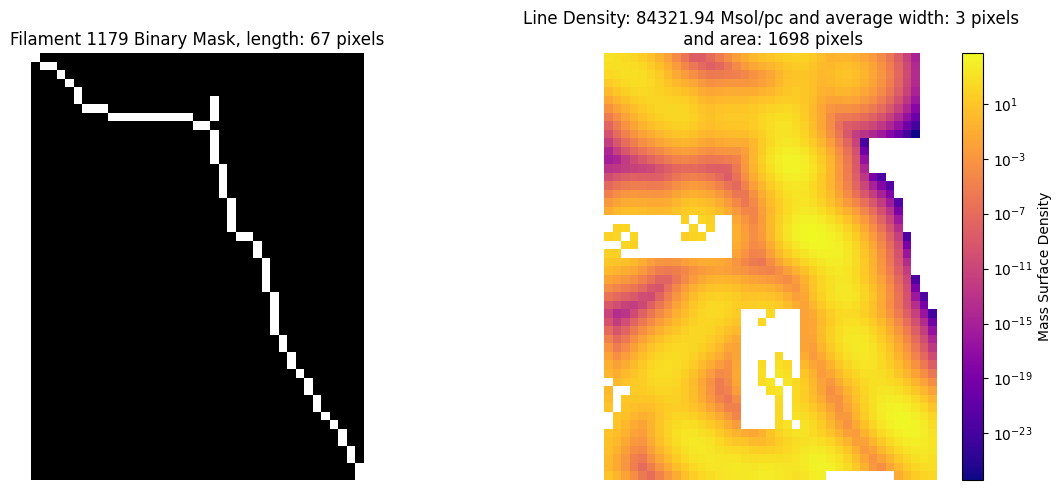

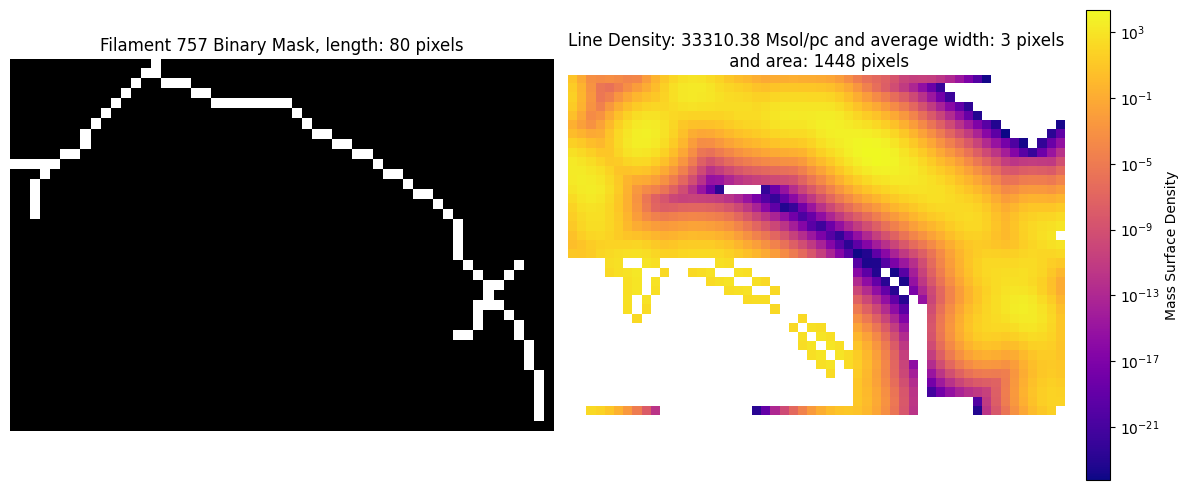

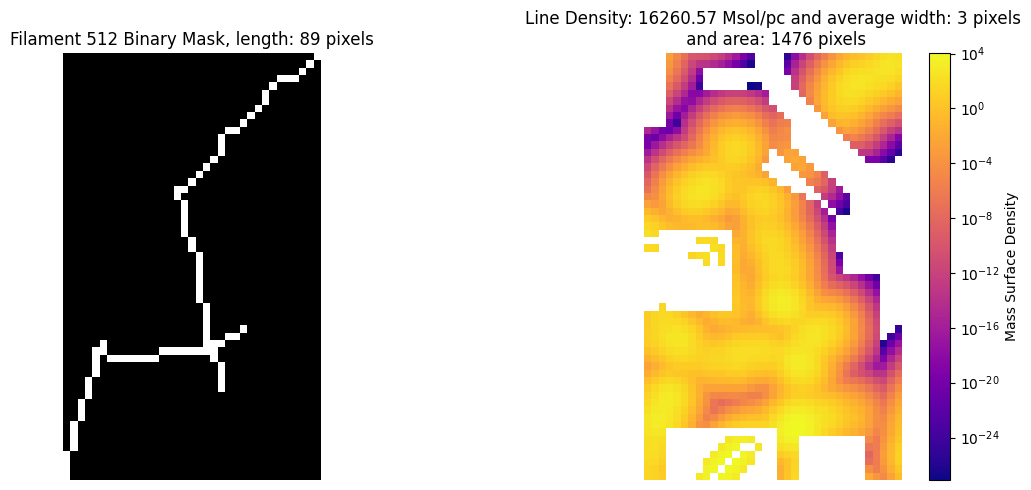

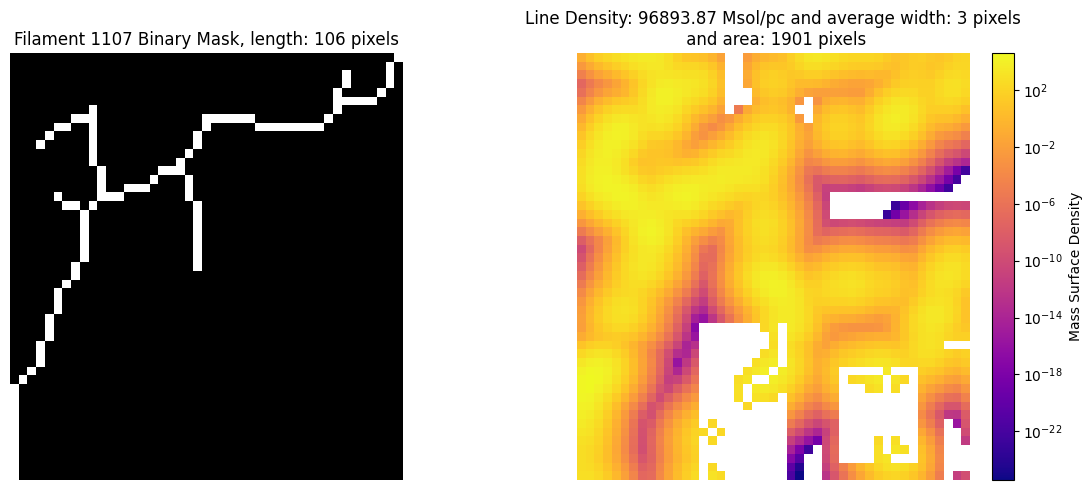

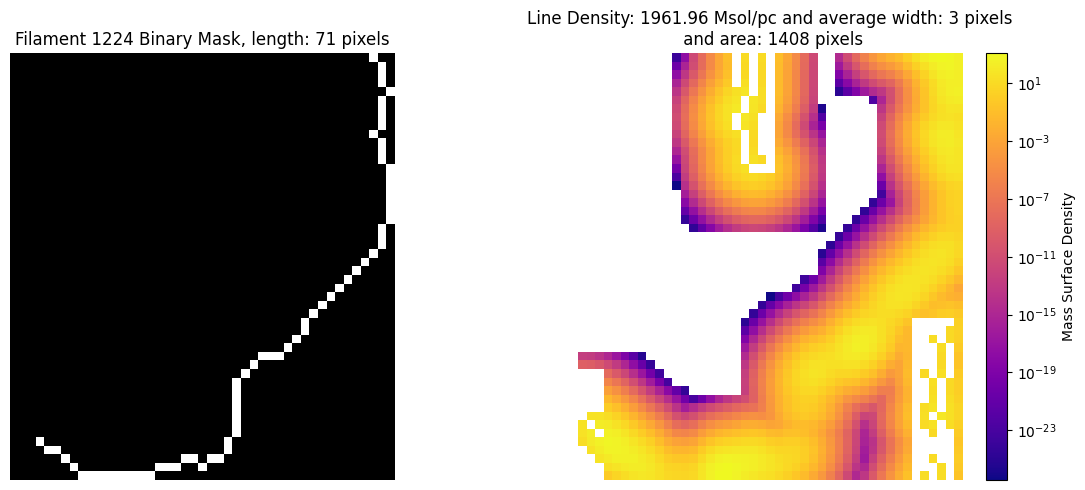

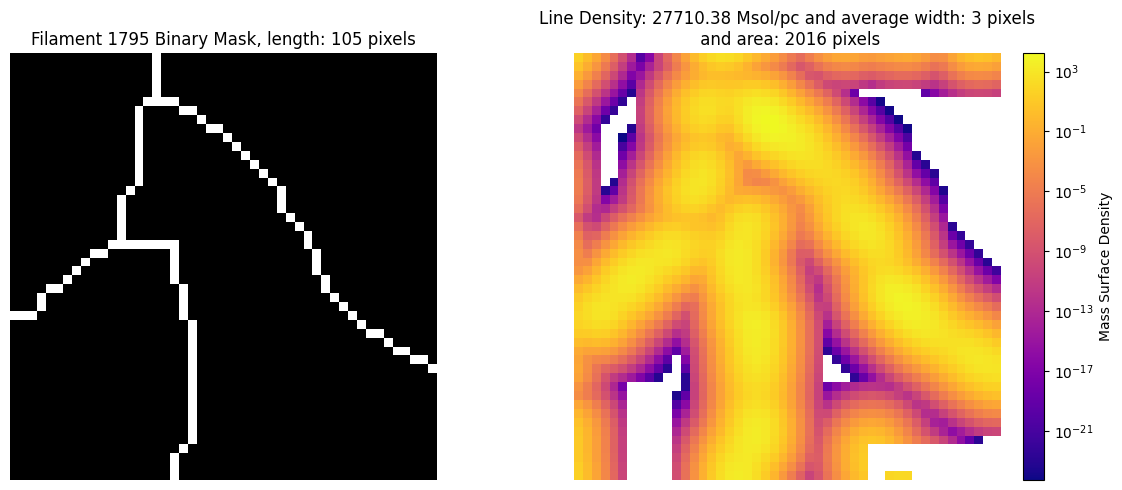

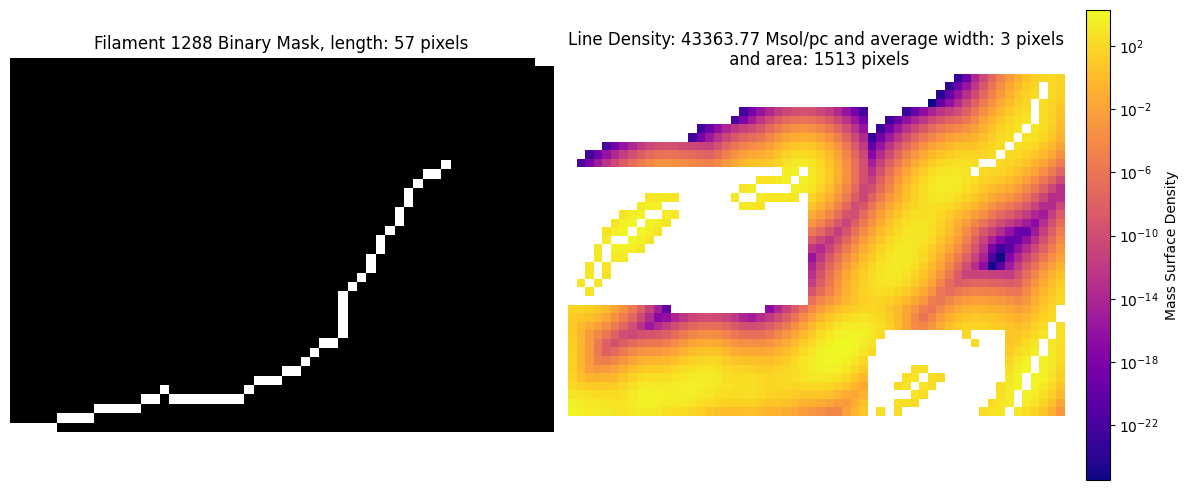

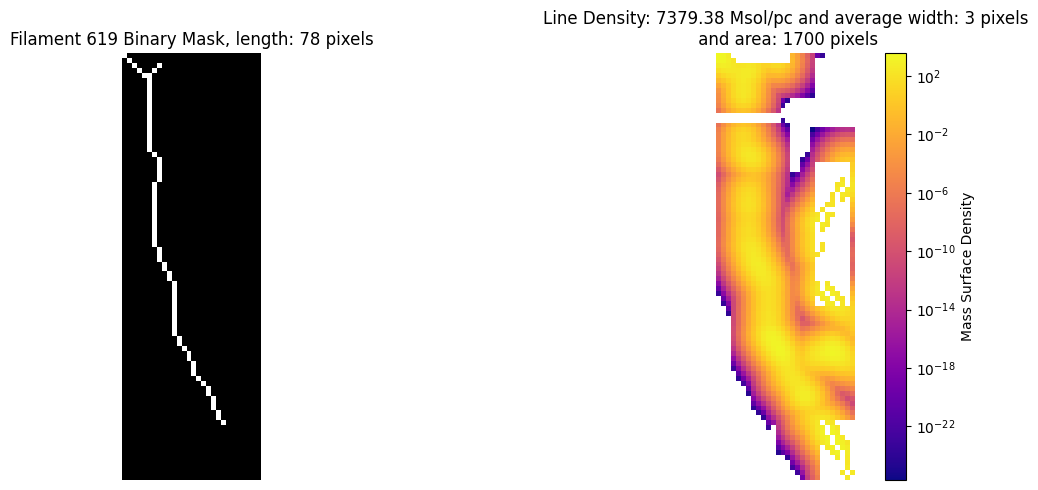

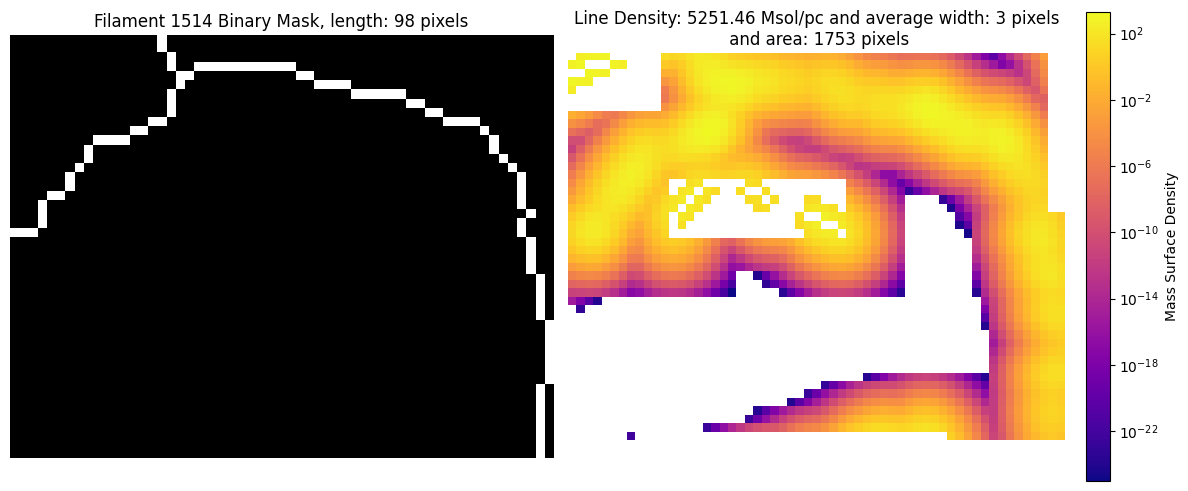

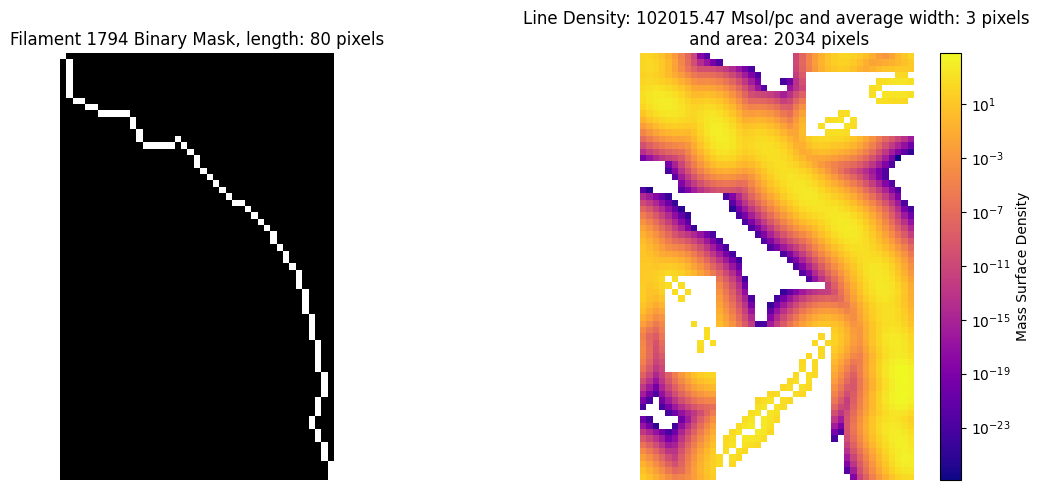

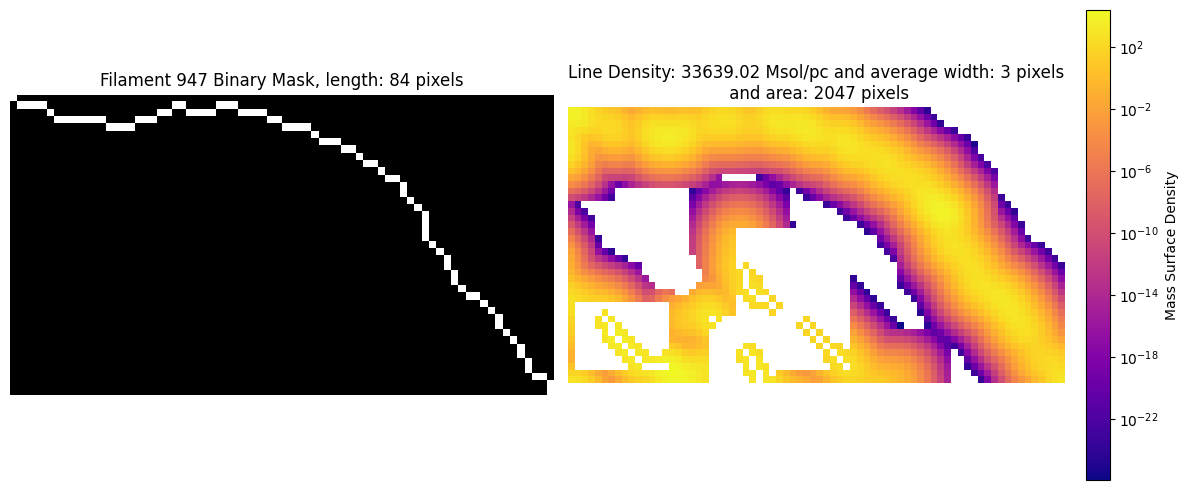

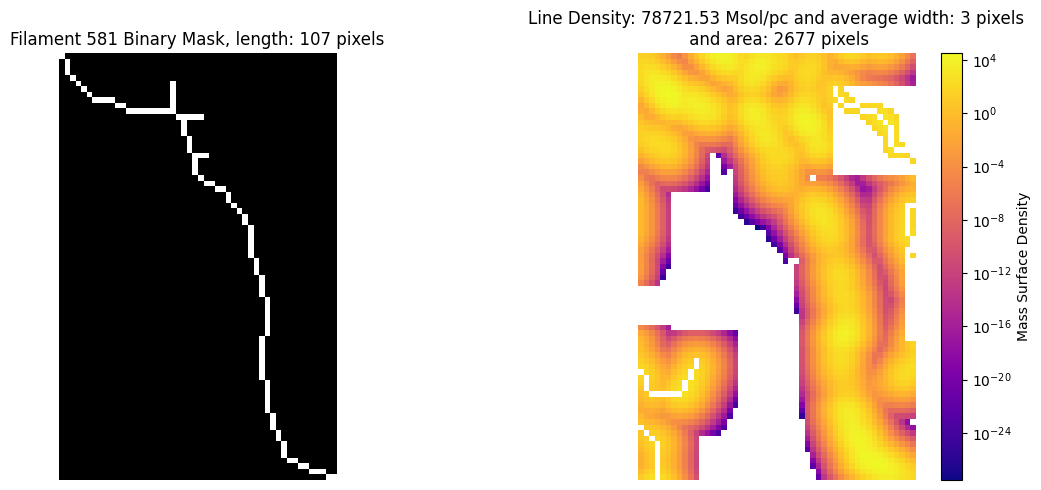

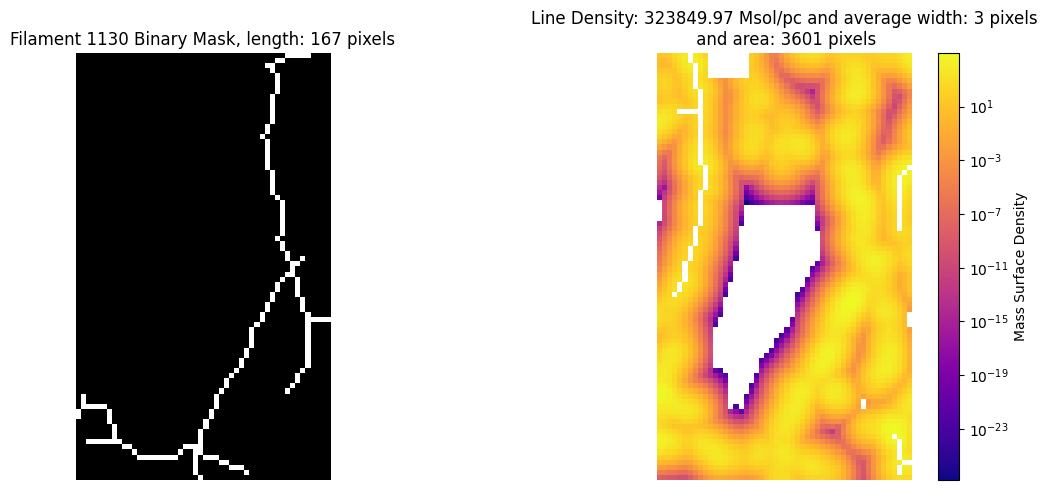

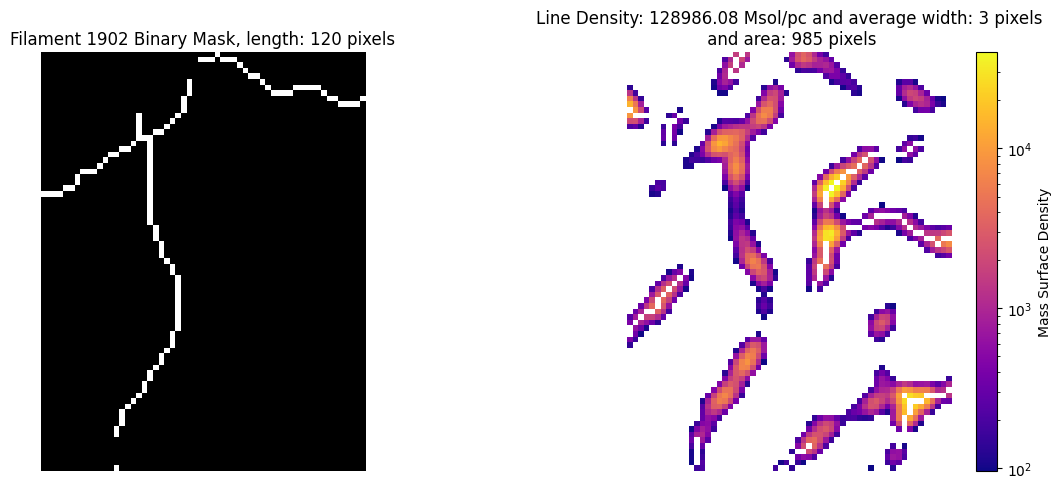

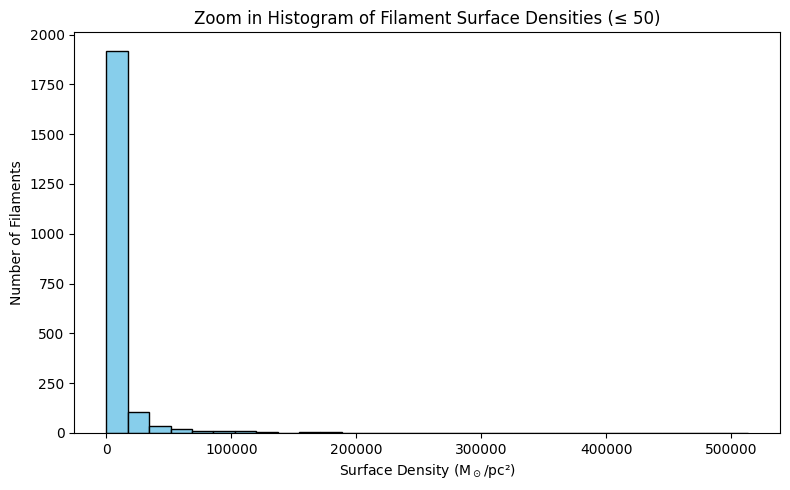

Average Surface Density (all filaments contribute equally): 7631.43 Msol/pc^2
Surface Density Median: 1233.81 Msol/pc^2
Surface Density Standard Deviation: 25028.06 Msol/pc^2
Skipped 2 filaments due to small area or width


In [526]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import AnalysisFuncs as AF
skip = 0

Surface_Densities = []

label_dict = {}
filament_bounds_dict = {}
fil_num = 0

# Extract all bounding boxes in the image
labels, stats, num_labels = AF.identify_connected_components(np.array(fil_centers.astype(np.uint8)))

# Store label areas for sorting
for label_id in range(1, num_labels):
    width = stats[label_id, cv2.CC_STAT_WIDTH]
    height = stats[label_id, cv2.CC_STAT_HEIGHT]
    area = width * height
    label_dict[label_id] = area

# Sort bounding boxes by area (smallest to largest)
sorted_labels = sorted(label_dict.keys(), key=lambda k: label_dict[k])

# Keep track of a binary mask of previously counted regions
global_mask = np.zeros_like(Molecular_Mass, dtype=bool)

for label_id in sorted_labels:
    left = stats[label_id, cv2.CC_STAT_LEFT] 
    top = stats[label_id, cv2.CC_STAT_TOP] 
    width = stats[label_id, cv2.CC_STAT_WIDTH] 
    height = stats[label_id, cv2.CC_STAT_HEIGHT]

    # Ensure bounding box is within image bounds
    y_end = min(top + height, Molecular_Mass.shape[0])
    x_end = min(left + width, Molecular_Mass.shape[1])

    # Extract region in binary image 
    centers_mask = fil_centers[top:y_end, left:x_end]
    assert(np.max(centers_mask) == 1)
    # Zero out any pixels already counted in other filaments
    glob_mask_slice = global_mask[top:y_end, left:x_end]

    centers_mask[glob_mask_slice] = 0

    fil_length = np.sum(centers_mask > 0) #get filament length

    if fil_length < 10:
         skip+=1
         continue
    
    Mass_Region = Molecular_Mass[top:y_end, left:x_end]
    Mass_Region[glob_mask_slice] = 0

    center_vals = Mass_Region[centers_mask > 0] #get masses of centers along filament

    thresh = np.mean(center_vals) - .75*np.std(center_vals)
    Mass_Region[Mass_Region < thresh] = 0 #threshold low value pixels by 1.5 std from center
    
    filament_area_pix = np.count_nonzero(Mass_Region)
    avg_width = 3
    
    avg_density = np.sum(Mass_Region) / (5.24*avg_width)
    Surface_Densities.append(avg_density)

    if fil_length > 50:
        fig, axs = plt.subplots(1, 2, figsize=(12, 5))

        # Plot the binary mask
        axs[0].imshow(centers_mask, cmap='gray')
        axs[0].set_title(f"Filament {label_id} Binary Mask, length: {fil_length} pixels")
        axs[0].axis('off')

        # Plot the product with mass region
        # pf  = centers_mask * Mass_Region
        im = axs[1].imshow(Mass_Region, cmap='plasma', norm = 'log')
        axs[1].set_title(f"Line Density: {avg_density:.2f} Msol/pc and average width: {avg_width} pixels\n and area: {filament_area_pix} pixels")
        axs[1].axis('off')

        # Add colorbar to the second plot
        cbar = fig.colorbar(im, ax=axs[1], fraction=0.046, pad=0.04)
        cbar.set_label('Mass Surface Density')

        plt.tight_layout()
        plt.show()

        # Save to FITS if it's the target filament
        if label_id == 326:
            save_path = "/Users/jakehoffmann/Documents/JHU_Research/FilPHANGS_Main/ngc0628_filament962_check.fits"
            hdu = fits.PrimaryHDU(centers_mask, header=header)
            hdu.writeto(save_path, overwrite=True)


    # Store the new mask into the global mask to avoid double-counting
    global_mask[top:y_end, left:x_end] += centers_mask.astype(bool)

    # Store bounding box for reference
    filament_bounds_dict[fil_num] = (left, top, x_end, y_end)



plt.figure(figsize=(8, 5))
plt.hist(Surface_Densities, bins=30, color='skyblue', edgecolor='black')
plt.title("Zoom in Histogram of Filament Surface Densities (≤ 50)")
plt.xlabel("Surface Density (M$_\odot$/pc²)")
plt.ylabel("Number of Filaments")
plt.tight_layout()
plt.show()


print(f"Average Surface Density (all filaments contribute equally): {np.mean(Surface_Densities):.2f} Msol/pc^2")
print(f"Surface Density Median: {np.median(Surface_Densities):.2f} Msol/pc^2")
print(f"Surface Density Standard Deviation: {np.std(Surface_Densities):.2f} Msol/pc^2")
print(f"Skipped {skip} filaments due to small area or width")
#look at densities on the skeleton only or on transverse components to get a mass/unit length. Extract values along the 


In [527]:
from astropy.table import QTable
import numpy as np
import matplotlib.pyplot as plt

# Assume `phot` is the result from psfphot(...)
# It contains: 'x_fit', 'y_fit', 'flux_fit' etc.
x_fit = phot['x_fit']
y_fit = phot['y_fit']
flux_fit = phot['flux_fit']

# Optional cleaning step: only keep valid, positive fluxes
valid_mask = np.isfinite(flux_fit) & (flux_fit > 0)
x_fit = x_fit[valid_mask]
y_fit = y_fit[valid_mask]
flux_fit = flux_fit[valid_mask]

# Create a 2D map to associate flux values with filament spine pixels
flux_map = np.zeros_like(Molecular_Mass, dtype=float)
for x, y, f in zip(x_fit.astype(int), y_fit.astype(int), flux_fit):
    flux_map[y, x] = f  # Note: numpy image convention is (row=y, col=x)

Surface_Densities = []
skip = 0
filament_bounds_dict = {}
fil_num = 0
global_mask = np.zeros_like(Molecular_Mass, dtype=bool)

for label_id in sorted_labels:
    left = stats[label_id, cv2.CC_STAT_LEFT]
    top = stats[label_id, cv2.CC_STAT_TOP]
    width = stats[label_id, cv2.CC_STAT_WIDTH]
    height = stats[label_id, cv2.CC_STAT_HEIGHT]

    y_end = min(top + height, Molecular_Mass.shape[0])
    x_end = min(left + width, Molecular_Mass.shape[1])

    centers_mask = fil_centers[top:y_end, left:x_end]
    glob_mask_slice = global_mask[top:y_end, left:x_end]

    centers_mask[glob_mask_slice] = 0
    fil_length = np.sum(centers_mask > 0)
    if fil_length < 10:
        skip += 1
        continue

    # Extract fitted fluxes only at spine positions within this bounding box
    flux_subregion = flux_map[top:y_end, left:x_end]
    spine_flux_vals = flux_subregion[centers_mask > 0]

    if np.sum(spine_flux_vals > 0) < 10:
        skip += 1
        continue

    # Optional: reject outliers or low-value fits (e.g., background contamination)
    thresh = np.mean(spine_flux_vals) - 0.75 * np.std(spine_flux_vals)
    spine_flux_vals = spine_flux_vals[spine_flux_vals >= thresh]

    filament_area_pix = np.count_nonzero(spine_flux_vals)
    avg_width = filament_area_pix // fil_length
    if avg_width < 3:
        skip += 1
        continue

    # Final line density (mass per unit length)
    pixel_scale_pc = 5.24  # adjust if needed
    avg_density = np.sum(spine_flux_vals) / (fil_length * pixel_scale_pc)
    Surface_Densities.append(avg_density)

    if fil_length > 50:
        fig, axs = plt.subplots(1, 2, figsize=(12, 5))
        axs[0].imshow(centers_mask, cmap='gray')
        axs[0].set_title(f"Filament {label_id} Binary Mask, length: {fil_length} pixels")
        axs[0].axis('off')

        im = axs[1].imshow(flux_subregion * centers_mask, cmap='plasma', norm='log')
        axs[1].set_title(
            f"Line Density: {avg_density:.2f} Msol/pc\n"
            f"Average width: {avg_width} pixels, Area: {filament_area_pix} pixels"
        )
        axs[1].axis('off')
        cbar = fig.colorbar(im, ax=axs[1], fraction=0.046, pad=0.04)
        cbar.set_label('PSF Fitted Flux')

        plt.tight_layout()
        plt.show()

    global_mask[top:y_end, left:x_end] += centers_mask.astype(bool)
    filament_bounds_dict[fil_num] = (left, top, x_end, y_end)

# Plot final histogram
plt.figure(figsize=(8, 5))
plt.hist(Surface_Densities, bins=30, color='skyblue', edgecolor='black')
plt.title("Zoom in Histogram of Filament Surface Densities (≤ 50)")
plt.xlabel("Surface Density (M$_\odot$/pc²)")
plt.ylabel("Number of Filaments")
plt.tight_layout()
plt.show()

print(f"Average Surface Density (all filaments contribute equally): {np.mean(Surface_Densities):.2f} Msol/pc^2")
print(f"Surface Density Median: {np.median(Surface_Densities):.2f} Msol/pc^2")
print(f"Surface Density Standard Deviation: {np.std(Surface_Densities):.2f} Msol/pc^2")
print(f"Skipped {skip} filaments due to small area or width")


<>:94: SyntaxWarning: invalid escape sequence '\o'
<>:94: SyntaxWarning: invalid escape sequence '\o'
/var/folders/5p/156pd2n9725b58sg8kk5wwv40000gn/T/ipykernel_14696/2467730354.py:94: SyntaxWarning: invalid escape sequence '\o'
  plt.xlabel("Surface Density (M$_\odot$/pc²)")


NameError: name 'phot' is not defined